# FrameAxis Analysis

In this notebook the process of calculating the FrameAxis values are explained, furthmore the FrameAxis values are evluated for the given datasets.

## Media Frames Corpus (MFC) Dataset

Evaluation for the Media Frames Corpus (MFC). 

### Analyse the frameaxis 

I used the generated list of words above to calculate for the whole labeled MFC dataset the frameaxis value (bias and intensity). Now I want to analyse if the value show some pattern in connection to the primary frame of the articles.

In [1]:
frameaxis_file_name = "frameaxis_semeval_mft"

In [2]:
label_fontsize = 12
title_fontsize = 16
ticks_fontsize = 12
legend_fontsize = 12

In [3]:
import pandas as pd
import json
import pickle
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pickle
import io
import torch

In [146]:
class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else:
            return super().find_class(module, name)

In [147]:
# load frameaxis data
with open(f'../../data/frameaxis/semeval/{frameaxis_file_name}.pkl', 'rb') as f:
    df_frameaxis = CPU_Unpickler(f).load()

# load mfc data
df_mfc = pd.DataFrame(json.load(open("../../data/semeval/muse-dlf/semeval_train.json")))

In [148]:
df_mfc.set_index('article_id', inplace=True)
df_frameaxis.set_index('article_id', inplace=True)

In [149]:
# join df_mfc and df_frameaxis row by row
df_merged = pd.concat([df_mfc, df_frameaxis], axis=1)

df_merged['type'] = pd.Categorical(df_merged['type'], categories=["opinion", "reporting", "satire"], ordered=True)

df = df_merged

In [150]:
frame_columns = ['Capacity_and_resources', 'Crime_and_punishment', 'Cultural_identity', 'Economic',
                 'External_regulation_and_reputation', 'Fairness_and_equality', 'Health_and_safety',
                 'Legality_Constitutionality_and_jurisprudence', 'Morality', 'Policy_prescription_and_evaluation',
                 'Political', 'Public_opinion', 'Quality_of_life', 'Security_and_defense']

# Create an empty list to store the new rows
new_rows = []

# Iterate through each row in the dataframe
for idx, row in df.iterrows():
    # For each row, iterate through the frame columns and check if they have a value of 1
    for frame in frame_columns:
        if row[frame] == 1:
            # Create a new row with the 'frames' column set to the current frame
            new_row = row.drop(frame_columns).copy()
            new_row['frames'] = frame
            new_rows.append(new_row)

# Create a new dataframe from the new rows
new_df = pd.DataFrame(new_rows)

In [151]:
len(new_df) > len(df), len(new_df), len(df)

(True, 63436, 16892)

In [152]:
df = new_df

In [153]:
for col in ['authority_bias', 'authority_intensity', 'care_bias',
       'care_intensity', 'fairness_bias', 'fairness_intensity', 'loyalty_bias',
       'loyalty_intensity', 'sanctity_bias', 'sanctity_intensity']:
    if isinstance(df[col][0], torch.Tensor):
        df[col] = df[col].apply(lambda x: x.item() if isinstance(x, torch.Tensor) else x)


C:\Users\elias\AppData\Local\Temp\ipykernel_12376\1835060878.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if isinstance(df[col][0], torch.Tensor):


In [154]:
bias_columns = [
    "care_bias",
    "loyalty_bias",
    "authority_bias",
    "fairness_bias",
    "sanctity_bias",
]

intensity_columns = [
    "care_intensity",
    "loyalty_intensity",
    "authority_intensity",
    "fairness_intensity",
    "sanctity_intensity",
]

In [155]:
microframe_map = {
    "care": "Care/Harm",
    "loyalty": "Loyalty/Betrayal",
    "authority": "Authority/Subversion",
    "fairness": "Fairness/Cheating",
    "sanctity": "Sanctity/Degradation",
}

In [156]:
df.columns

Index(['text', 'type', 'authority_bias', 'authority_intensity', 'care_bias',
       'care_intensity', 'fairness_bias', 'fairness_intensity', 'loyalty_bias',
       'loyalty_intensity', 'sanctity_bias', 'sanctity_intensity', 'frames'],
      dtype='object')

In [157]:
df['frame_type'] = df['frames'] + " - " + df['type'].astype(str)

In [158]:
df['text'] = df['text'].astype(str)

In [159]:
# add article_id as col from row index
df['article_id'] = df.index

In [160]:
df_sentences = df

In [161]:
df_agg = df.groupby(['article_id', 'frames']).agg({
    'authority_bias': 'mean',
    'authority_intensity': 'mean',
    'care_bias': 'mean',
    'care_intensity': 'mean',
    'fairness_bias': 'mean',
    'fairness_intensity': 'mean',
    'loyalty_bias': 'mean',
    'loyalty_intensity': 'mean',
    'sanctity_bias': 'mean',
    'sanctity_intensity': 'mean',
    'text': ' '.join,  # Append the values in 'text' column
    'type': 'first',  # Take the first, assuming all are the same
    'frame_type': 'first'  # Take the first, assuming all are the same
}).reset_index()


In [162]:
df = df_agg

In [163]:
df["frames"].value_counts()

frames
Political                                       235
Crime_and_punishment                            227
Legality_Constitutionality_and_jurisprudence    203
Morality                                        203
Security_and_defense                            187
External_regulation_and_reputation              121
Fairness_and_equality                           115
Quality_of_life                                  87
Policy_prescription_and_evaluation               65
Health_and_safety                                61
Cultural_identity                                31
Capacity_and_resources                           29
Economic                                         28
Public_opinion                                   23
Name: count, dtype: int64

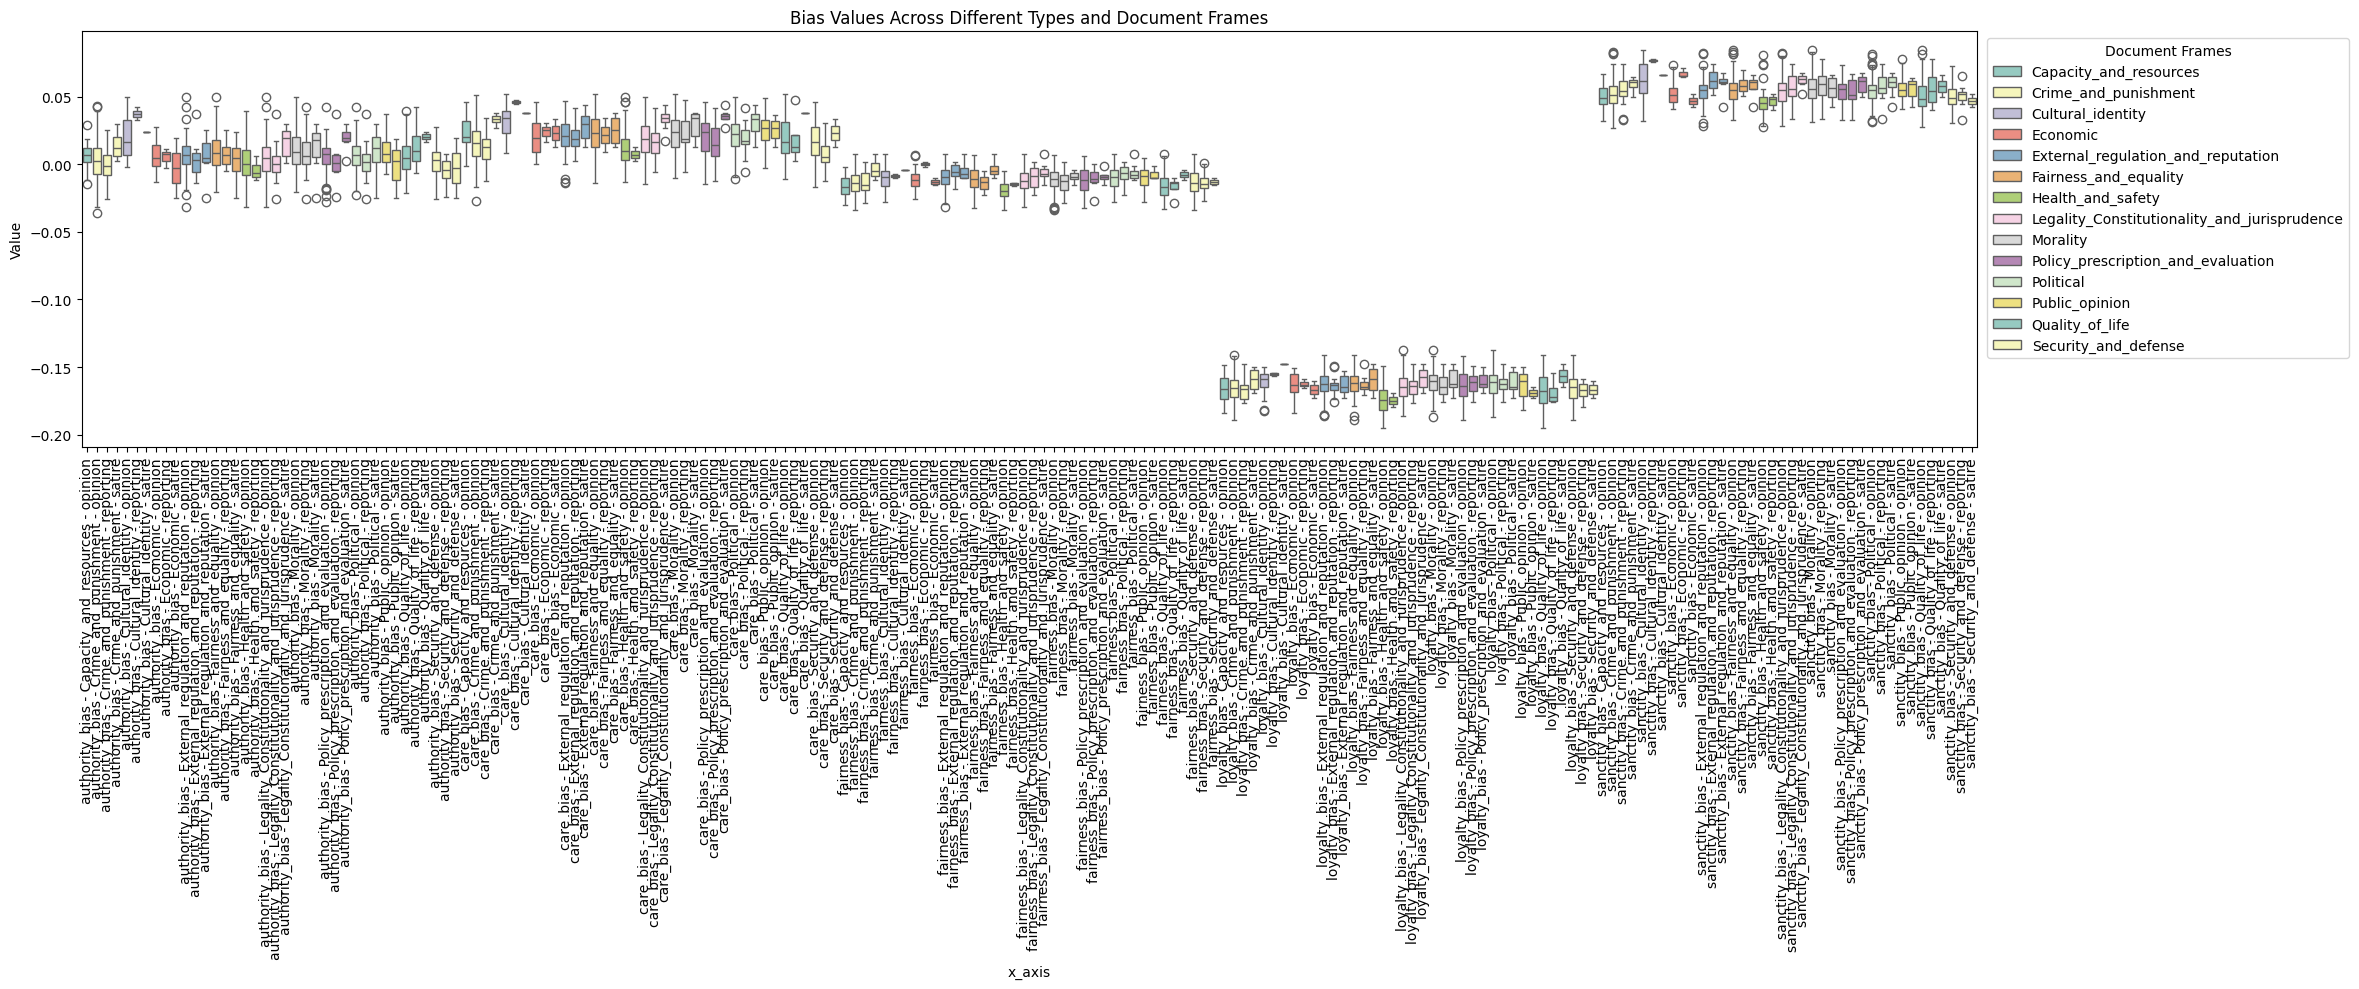

In [122]:
def plot_bias_foundations(df, foundations, types=['opinion', 'reporting', 'satire']):

    # Filtering the DataFrame for the types we are interested in
    df = df[df['type'].isin(types)]

    # Melting the DataFrame for the bias values we are interested in
    bias_columns = foundations
    melted_bias = df.melt(id_vars=[ 'frames', 'type'], value_vars=bias_columns, 
                          var_name='Metric', value_name='Value')

    # Drop NaN values
    melted_bias.dropna(inplace=True)

    # Creating a composite key for plotting, which combines the 'Metric', 'frames', and 'type'
    melted_bias['x_axis'] = melted_bias.apply(
        lambda x: f"{x['Metric']} - {x['frames']} - {x['type']}", axis=1
    )

    # Sort the melted DataFrame to define the order of boxplots
    melted_bias.sort_values(by=['Metric', 'frames', 'type'], inplace=True)

    # The order of x-ticks is defined by the sorted unique values of 'x_axis'
    x_ticks_order = melted_bias['x_axis'].unique()

    # Plotting
    plt.figure(figsize=(20, 10))
    
    # Create a boxplot and map colors to 'frames'
    boxplot = sns.boxplot(x='x_axis', y='Value', data=melted_bias, hue='frames', palette='Set3', order=x_ticks_order, dodge=False)

    plt.title('Bias Values Across Different Types and Document Frames')
    plt.xticks(rotation=90)  # Rotating the x-ticks to prevent overlap due to the long names
    plt.tight_layout()
    
    # Adding legend
    handles, labels = boxplot.get_legend_handles_labels()
    plt.legend(handles, labels, bbox_to_anchor=(1.20, 1), title="Document Frames", loc='upper right')
    
    plt.show()


# 'authority_bias', 'care_bias', 'fairness_bias', 'loyalty_bias', 'sanctity_bias'
plot_bias_foundations(df,  ['authority_bias', 'care_bias', 'fairness_bias', 'loyalty_bias', 'sanctity_bias'], types=['opinion', 'reporting', 'satire'])

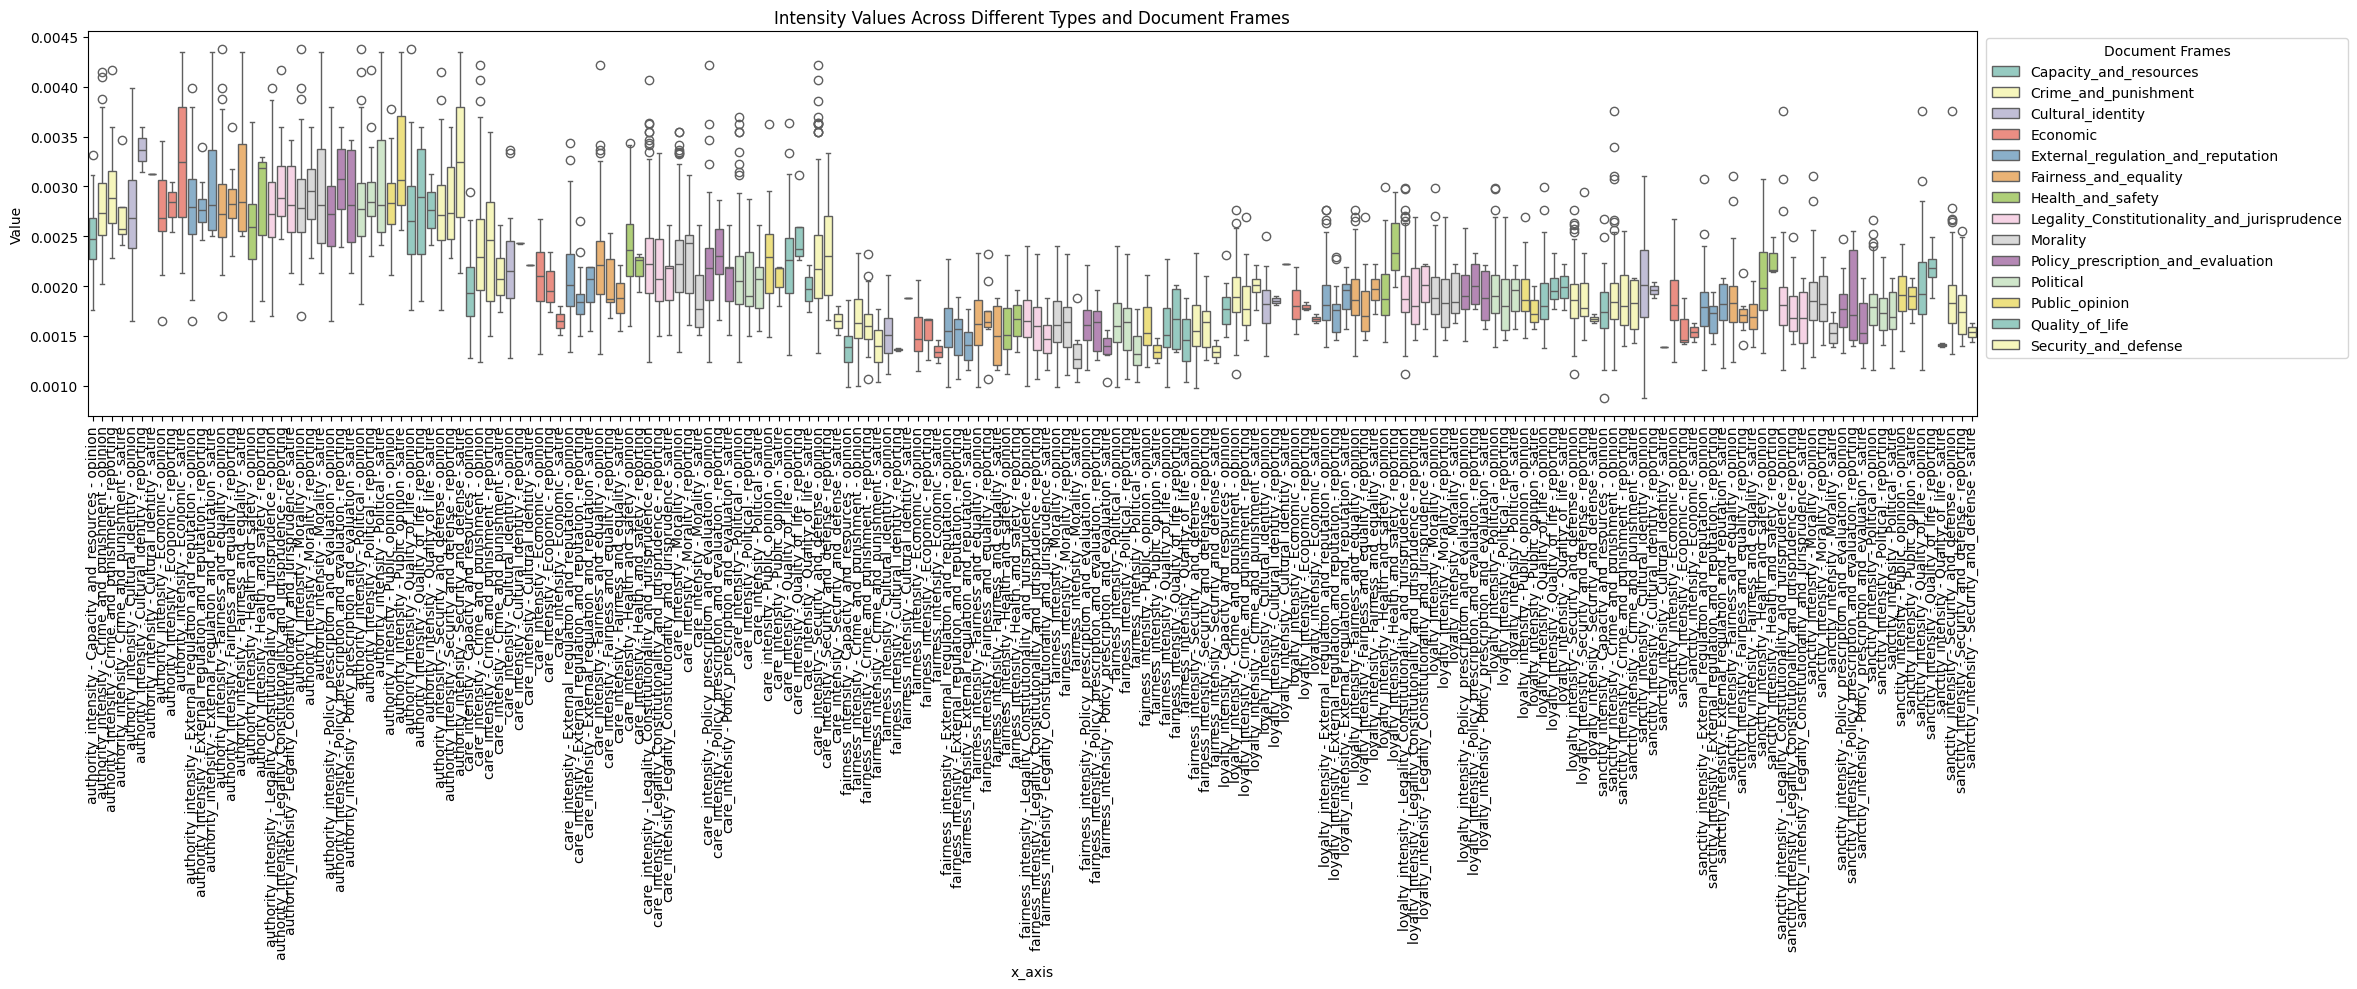

In [123]:
def plot_intensity_foundations(df, foundations, types=['opinion', 'reporting', 'satire']):
    # Filtering the DataFrame for the types we are interested in
    df = df[df['type'].isin(types)]

    # Melting the DataFrame for the bias values we are interested in
    bias_columns = foundations
    melted_bias = df.melt(id_vars=['article_id', 'frames', 'type', 'text'], value_vars=bias_columns, 
                          var_name='Metric', value_name='Value')

    # Drop NaN values
    melted_bias.dropna(inplace=True)

    # Creating a composite key for plotting, which combines the 'Metric', 'frames', and 'type'
    melted_bias['x_axis'] = melted_bias.apply(
        lambda x: f"{x['Metric']} - {x['frames']} - {x['type']}", axis=1
    )

    # Sort the melted DataFrame to define the order of boxplots
    melted_bias.sort_values(by=['Metric', 'frames', 'type'], inplace=True)

    # The order of x-ticks is defined by the sorted unique values of 'x_axis'
    x_ticks_order = melted_bias['x_axis'].unique()

    # Plotting
    plt.figure(figsize=(20, 10))
    
    # Create a boxplot and map colors to 'frames'
    boxplot = sns.boxplot(x='x_axis', y='Value', data=melted_bias, hue='frames', palette='Set3', order=x_ticks_order, dodge=False)

    plt.title('Intensity Values Across Different Types and Document Frames')
    plt.xticks(rotation=90)  # Rotating the x-ticks to prevent overlap due to the long names
    plt.tight_layout()
    
    # Adding legend
    handles, labels = boxplot.get_legend_handles_labels()
    plt.legend(handles, labels, bbox_to_anchor=(1.20, 1), title="Document Frames", loc='upper right')
    
    plt.show()


# 'authority_intensity', 'care_intensity', 'fairness_intensity', 'loyalty_intensity', 'sanctity_intensity'
plot_intensity_foundations(df,  ['authority_intensity', 'care_intensity', 'fairness_intensity', 'loyalty_intensity', 'sanctity_intensity'], types=['opinion', 'reporting', 'satire'])

C:\Users\elias\AppData\Local\Temp\ipykernel_12376\369596213.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='x_axis', y='Value', data=melted_bias, palette='Set3', order=x_ticks_order)


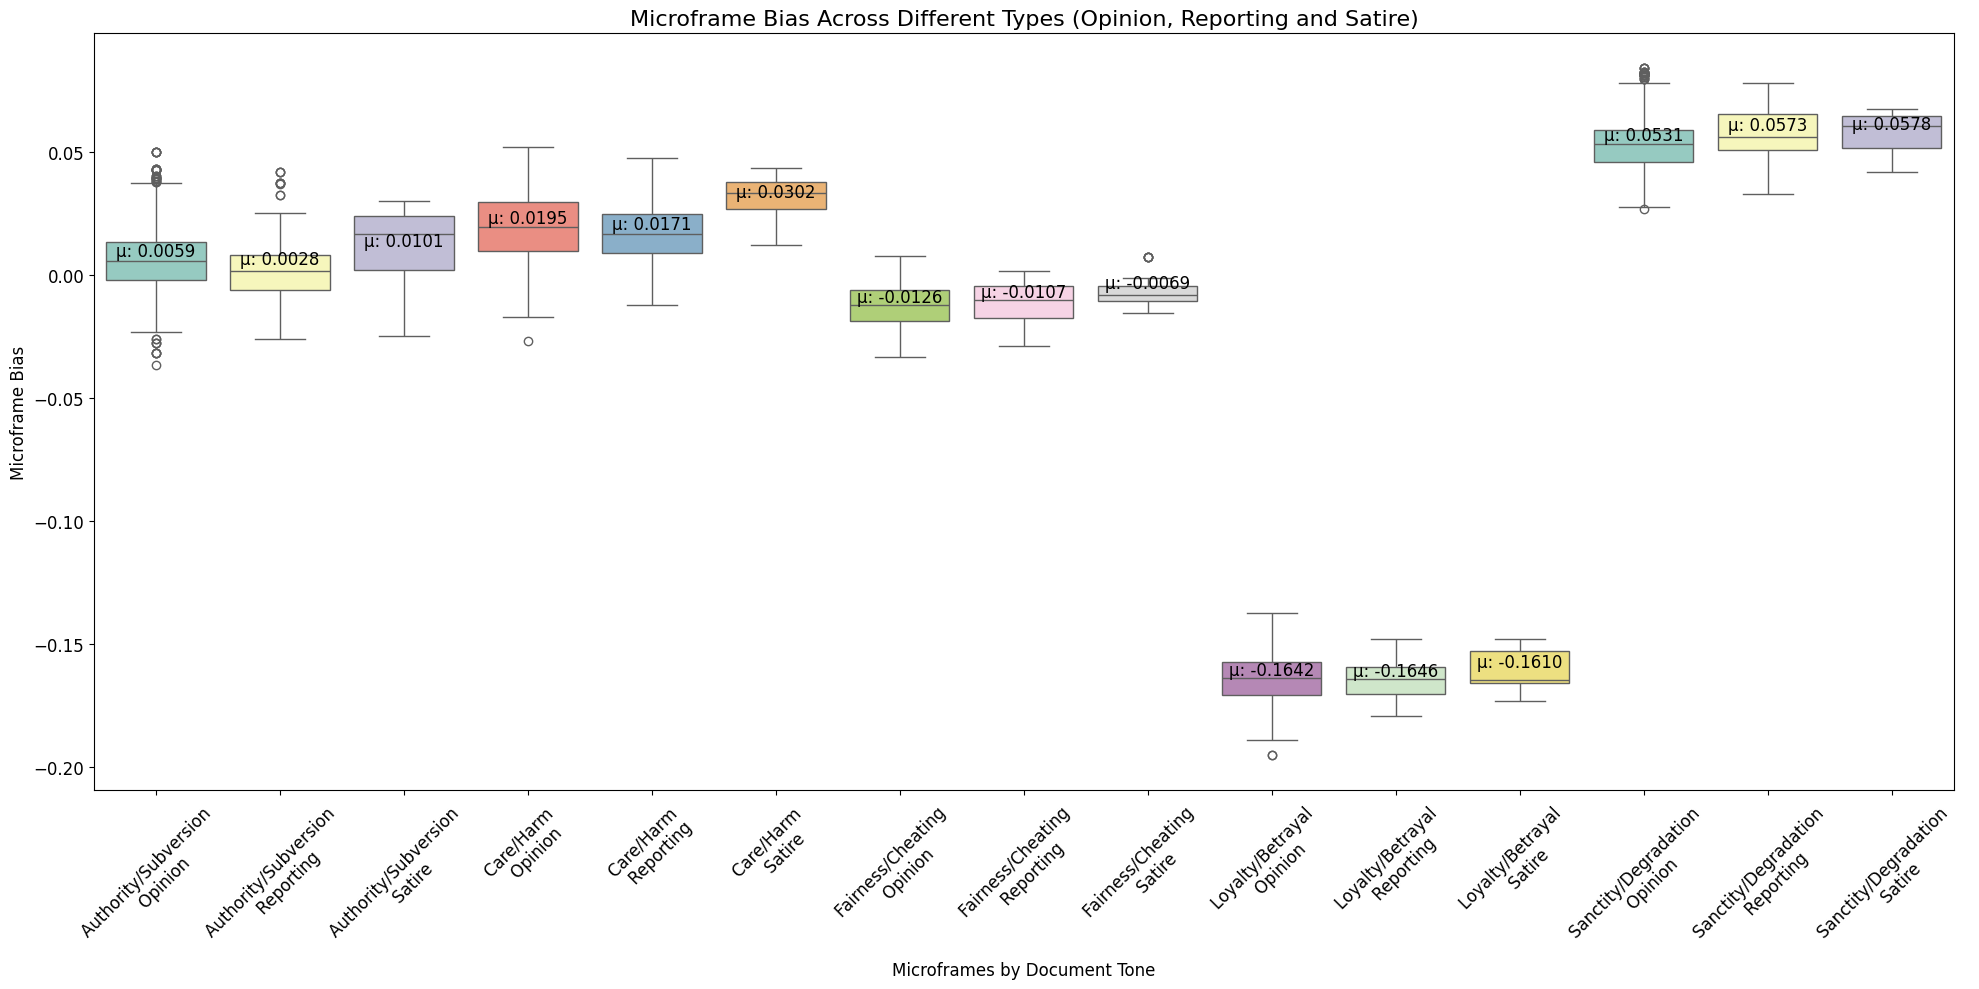

In [126]:
def plot_bias_foundations(df, foundations, types=['opinion', 'reporting', 'satire'], microframe_map=None):
    # Filtering the DataFrame for the types we are interested in
    df = df[df['type'].isin(types)]

    # Melting the DataFrame for the bias values we are interested in
    bias_columns = foundations
    melted_bias = df.melt(id_vars=['type'], value_vars=bias_columns, 
                          var_name='Metric', value_name='Value')

    # Drop NaN values
    melted_bias.dropna(inplace=True)

    # Map the metrics to their correct names using microframe_map if provided
    if microframe_map:
        melted_bias['Metric'] = melted_bias['Metric'].apply(lambda x: microframe_map.get(x.split('_')[0], x.split('_')[0]))

    # Creating a composite key for plotting, which combines the 'Metric' and 'type'
    melted_bias['x_axis'] = melted_bias.apply(
        lambda x: f"{x['Metric']} \n {x['type'].capitalize()}", axis=1
    )

    # Sort the melted DataFrame to define the order of boxplots
    melted_bias.sort_values(by=['Metric', 'type'], inplace=True)

    # The order of x-ticks is defined by the sorted unique values of 'x_axis'
    x_ticks_order = melted_bias['x_axis'].unique()

    # Plotting
    plt.figure(figsize=(20, 10))
    
    # Create a boxplot
    sns.boxplot(x='x_axis', y='Value', data=melted_bias, palette='Set3', order=x_ticks_order)

    plt.title('Microframe Bias Across Different Types (Opinion, Reporting and Satire)', fontsize=title_fontsize)
    plt.xlabel('Microframes by Document Tone', fontsize=label_fontsize)
    plt.ylabel('Microframe Bias', fontsize=label_fontsize)
    plt.xticks(rotation=45, fontsize=ticks_fontsize)
    plt.yticks(fontsize=ticks_fontsize)


    # Calculating and annotating the mean for each group in the boxplot
    for i, group in enumerate(x_ticks_order):
        # Getting the mean of the values in the current group
        group_data = melted_bias[melted_bias['x_axis'] == group]['Value']
        mean_val = group_data.mean()
        
        # Annotating the mean
        plt.text(i, mean_val, f'μ: {mean_val:.4f}', color='black', ha='center', va='bottom', fontsize=12)

    plt.tight_layout()
    plt.show()

# 'authority_bias', 'care_bias', 'fairness_bias', 'loyalty_bias', 'sanctity_bias'
plot_bias_foundations(df, ['authority_bias', 'care_bias', 'fairness_bias', 'loyalty_bias', 'sanctity_bias'], types=['opinion', 'reporting', 'satire'], microframe_map=microframe_map)

C:\Users\elias\AppData\Local\Temp\ipykernel_12376\1250505603.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='x_axis', y='Value', data=melted_intensity, palette='Set3', order=x_ticks_order)


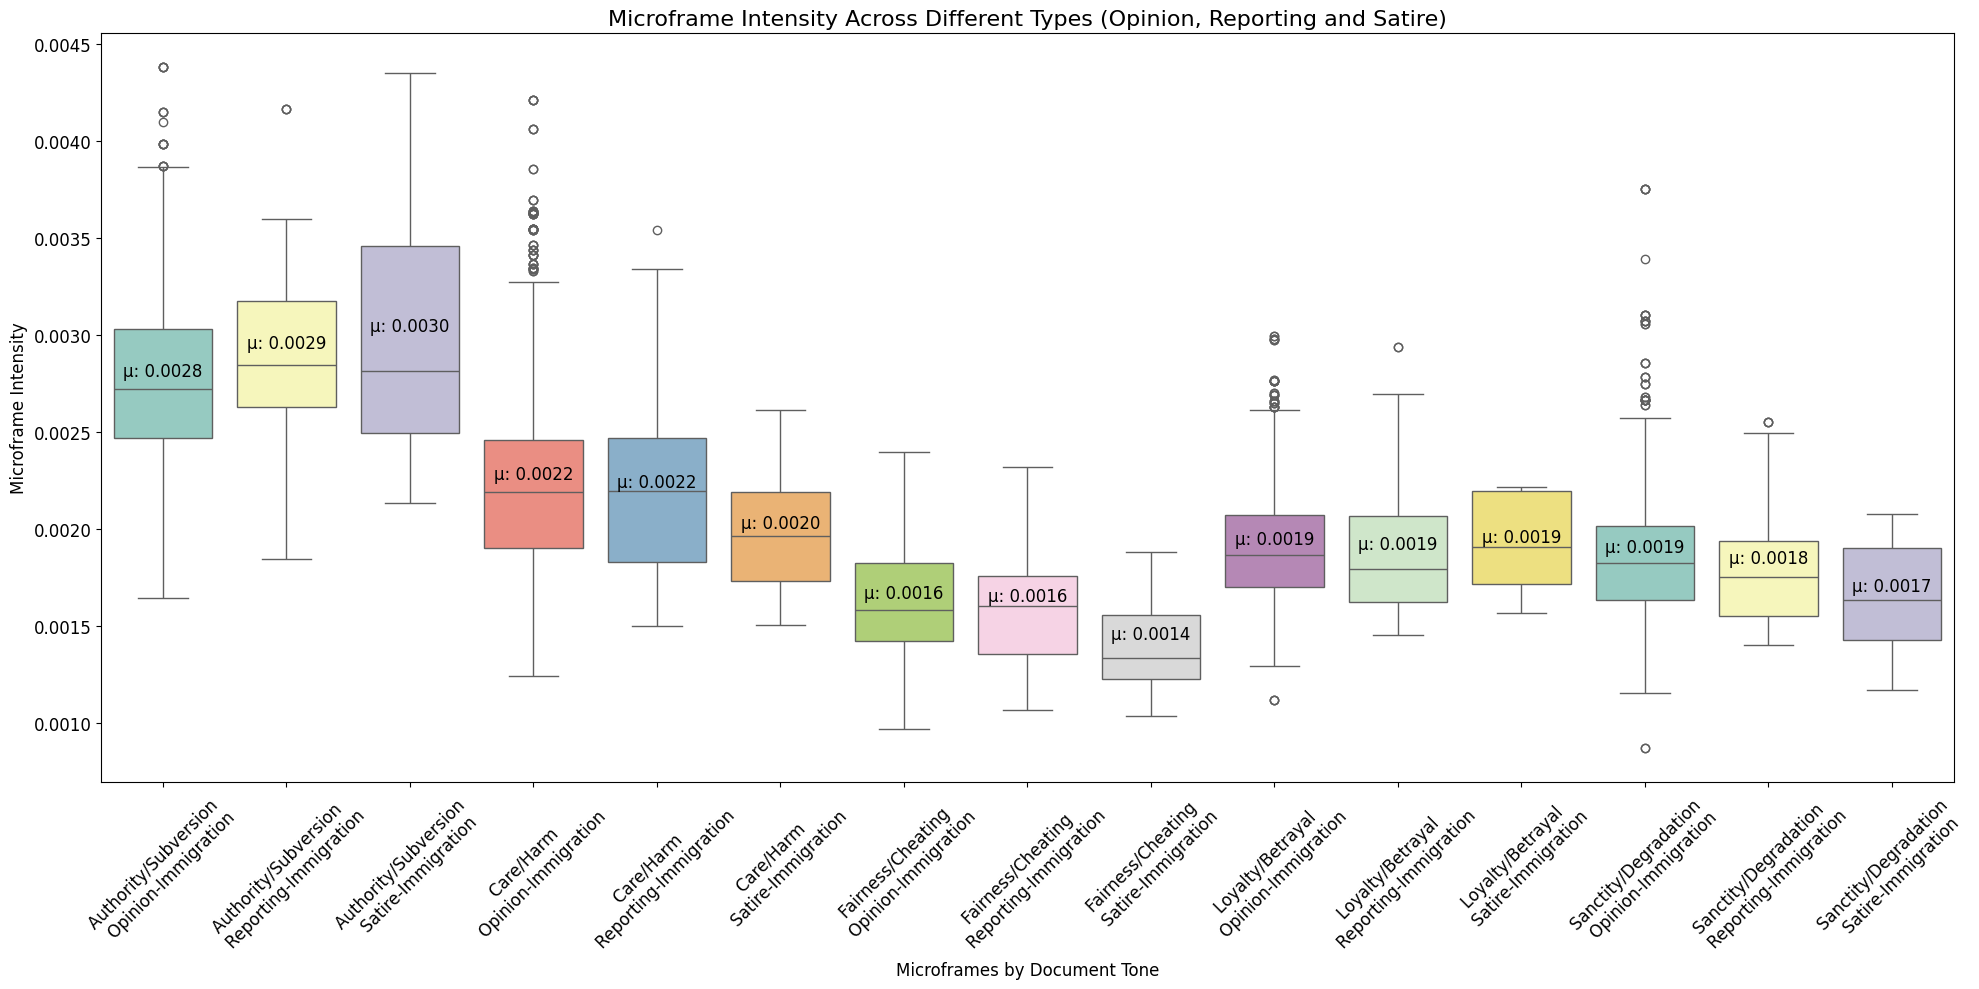

In [128]:
def plot_intensity_foundations(df, foundations, types=['opinion', 'reporting', 'satire']):
    # Filtering the DataFrame for the tones we are interested in
    df = df[df['type'].isin(types)]

    # Melting the DataFrame for the bias values we are interested in
    melted_intensity = df.melt(id_vars=['type'], value_vars=intensity_columns, 
                          var_name='Metric', value_name='Value')

    # Drop NaN values
    melted_intensity.dropna(inplace=True)
    
    # Map the metrics to their correct names using microframe_map if provided
    if microframe_map:
        melted_intensity['Metric'] = melted_intensity['Metric'].apply(lambda x: microframe_map.get(x.split('_')[0], x.split('_')[0]))

    # Creating a composite key for plotting, which combines the 'Metric' and 'type'
    melted_intensity['x_axis'] = melted_intensity.apply(
        lambda x: f"{x['Metric']} \n {x['type'].capitalize()}-Immigration", axis=1
    )
    
    # Sort the melted DataFrame to define the order of boxplots
    melted_intensity.sort_values(by=['Metric', 'type'], inplace=True)

    # The order of x-ticks is defined by the sorted unique values of 'x_axis'
    x_ticks_order = melted_intensity['x_axis'].unique()

    # Plotting
    plt.figure(figsize=(20, 10))
    
    # Create a boxplot
    sns.boxplot(x='x_axis', y='Value', data=melted_intensity, palette='Set3', order=x_ticks_order)

    plt.title('Microframe Intensity Across Different Types (Opinion, Reporting and Satire)', fontsize=title_fontsize)
    plt.xlabel('Microframes by Document Tone', fontsize=label_fontsize)
    plt.ylabel('Microframe Intensity', fontsize=label_fontsize)
    plt.xticks(rotation=45, fontsize=ticks_fontsize) 
    plt.yticks(fontsize=ticks_fontsize)

    # Calculating and annotating the mean for each group in the boxplot
    for i, group in enumerate(x_ticks_order):
        # Getting the mean of the values in the current group
        group_data = melted_intensity[melted_intensity['x_axis'] == group]['Value']
        mean_val = group_data.mean()
        
        # Annotating the mean
        plt.text(i, mean_val, f'μ: {mean_val:.4f}', color='black', ha='center', va='bottom', fontsize=12)

    plt.tight_layout()
    plt.show()


# 'authority_bias', 'care_bias', 'fairness_bias', 'loyalty_bias', 'sanctity_bias'
plot_intensity_foundations(df, ['authority_bias', 'care_bias', 'fairness_bias', 'loyalty_bias', 'sanctity_bias'], types=['opinion', 'reporting', 'satire'])

### Plot Bias and Intensity for each foundation WITHOUT tone

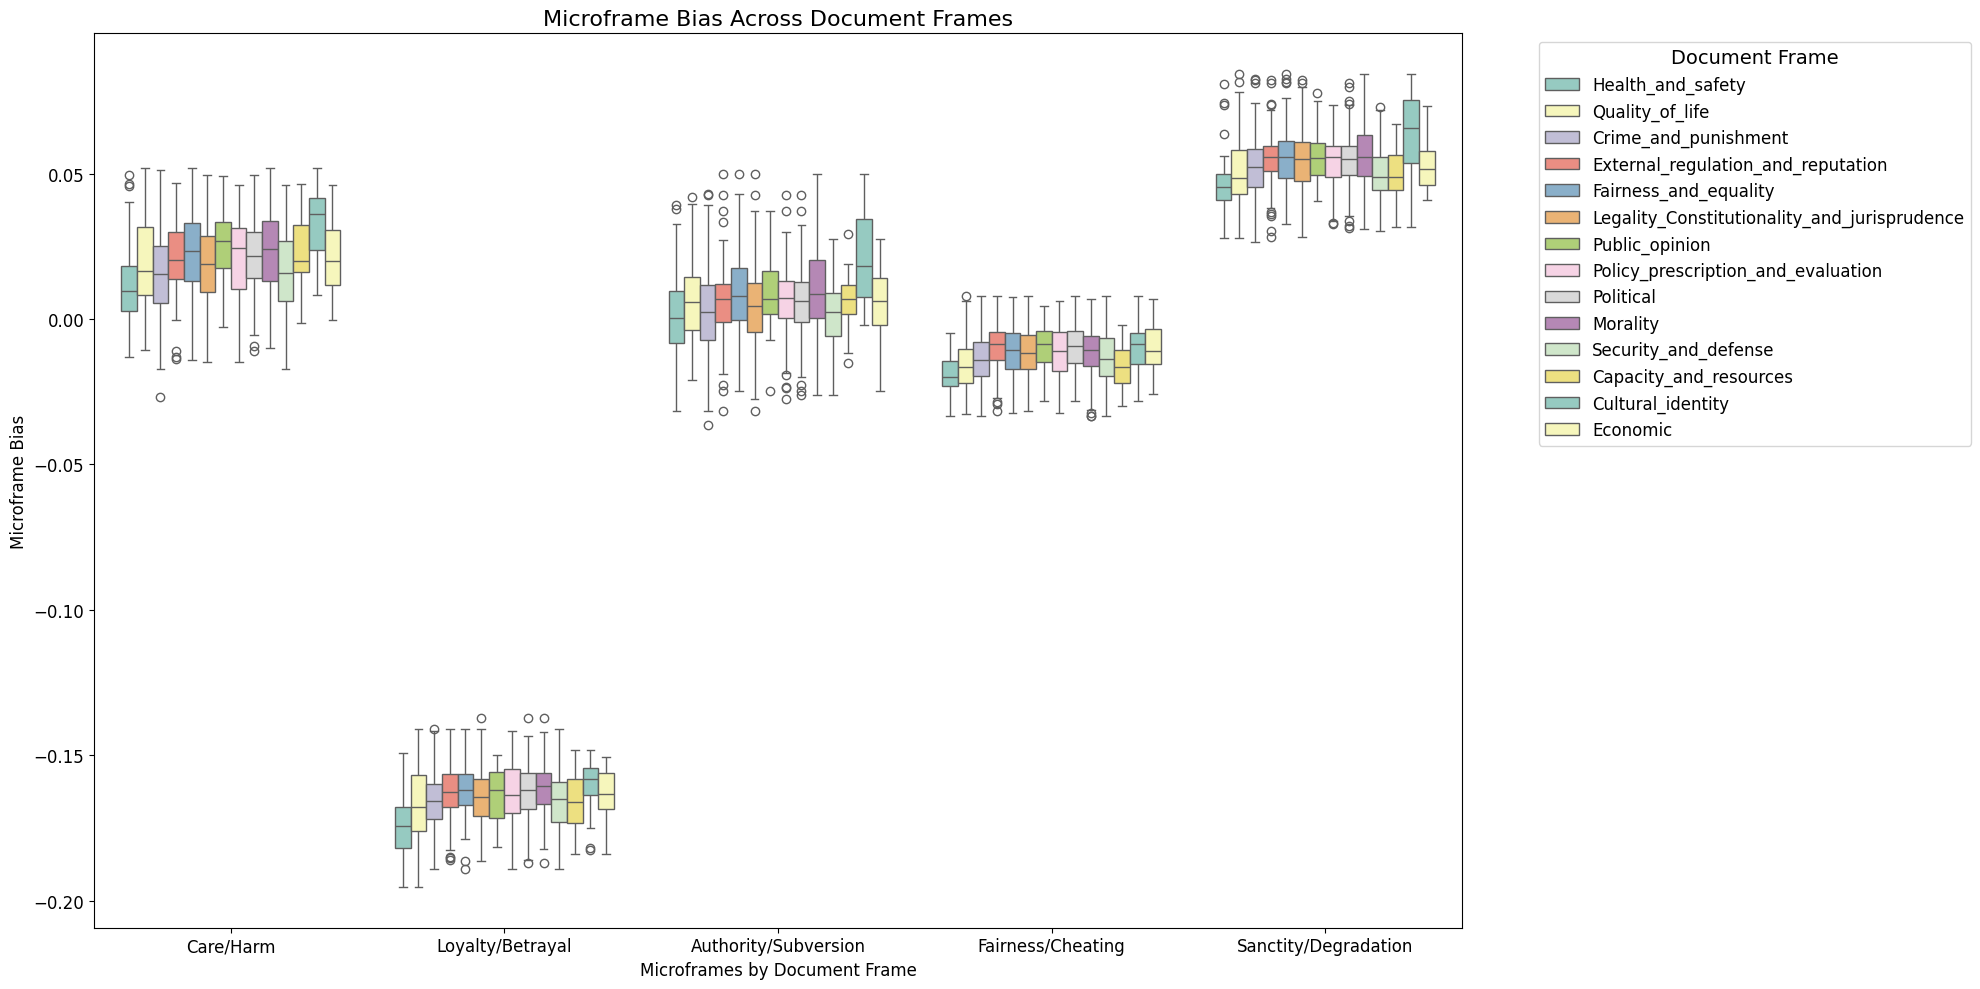

In [129]:
melted_bias = df.melt(
    id_vars=["frames"],
    value_vars=bias_columns,
    var_name="Metric",
    value_name="Value",
)
melted_bias["Type"] = "Bias"

melted_bias["Metric"] = melted_bias["Metric"].apply(
    lambda x: microframe_map.get(x.split("_")[0], x.split("_")[0])
)

# Combining bias and intensity data
combined_data = pd.concat([melted_bias])

# Plotting
plt.figure(figsize=(20, 10))
sns.boxplot(
    x="Metric", y="Value", hue="frames", data=combined_data, palette="Set3"
)
plt.title("Microframe Bias Across Document Frames", fontsize=title_fontsize)
plt.xlabel("Microframes by Document Frame", fontsize=label_fontsize)
plt.ylabel("Microframe Bias", fontsize=label_fontsize)
plt.xticks(rotation=0, fontsize=ticks_fontsize)
plt.yticks(fontsize=ticks_fontsize)
plt.legend(
    title="Document Frame",
    bbox_to_anchor=(1.05, 1),
    loc="upper left",
    fontsize=legend_fontsize,
    title_fontsize=legend_fontsize + 2,
)
plt.tight_layout()
plt.show()

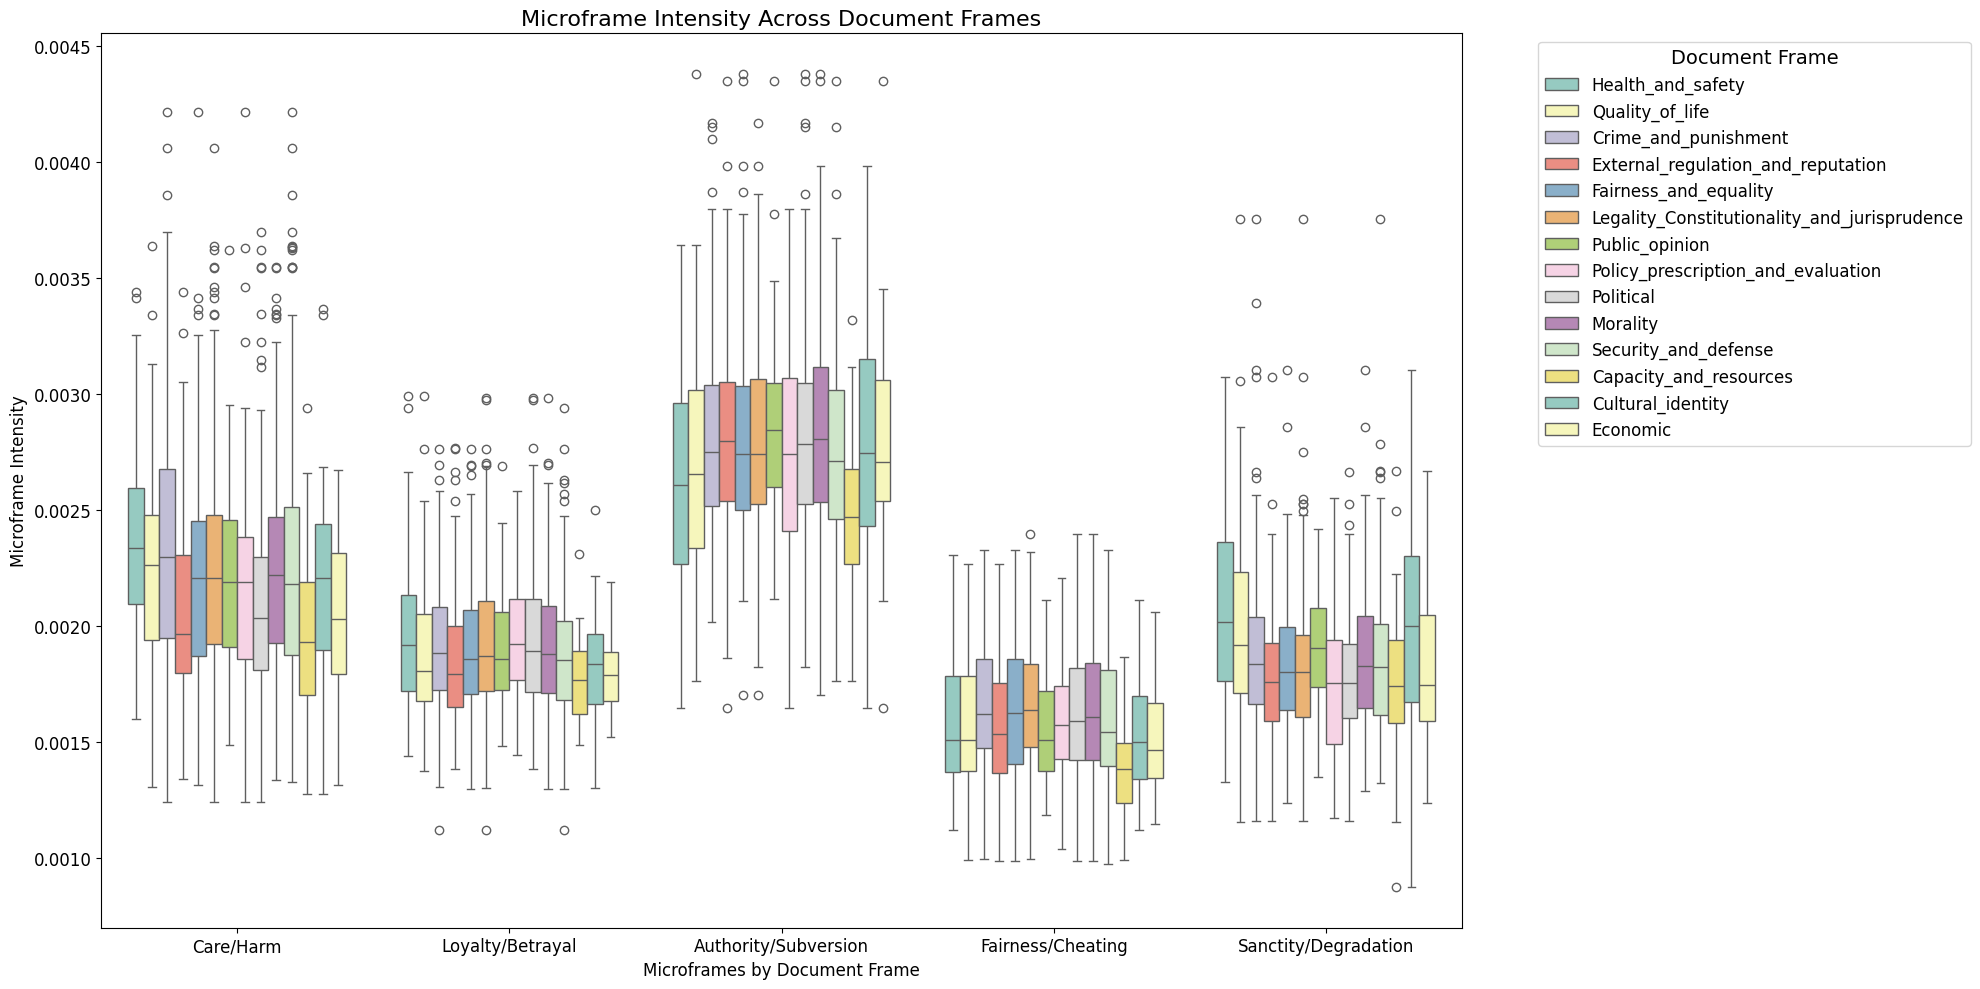

In [130]:
melted_intensity = df.melt(
    id_vars=["frames"],
    value_vars=intensity_columns,
    var_name="Metric",
    value_name="Value",
)
melted_intensity["Type"] = "Intensity"

melted_intensity["Metric"] = melted_intensity["Metric"].apply(
    lambda x: microframe_map.get(x.split("_")[0], x.split("_")[0])
)

# Combining bias and intensity data
combined_data = pd.concat([melted_intensity])

# Plotting
plt.figure(figsize=(20, 10))
sns.boxplot(
    x="Metric", y="Value", hue="frames", data=combined_data, palette="Set3"
)
plt.title("Microframe Intensity Across Document Frames", fontsize=title_fontsize)
plt.xlabel("Microframes by Document Frame", fontsize=label_fontsize)
plt.ylabel("Microframe Intensity", fontsize=label_fontsize)
plt.xticks(rotation=0, fontsize=ticks_fontsize)
plt.yticks(fontsize=ticks_fontsize)
plt.legend(
    title="Document Frame",
    bbox_to_anchor=(1.05, 1),
    loc="upper left",
    fontsize=legend_fontsize,
    title_fontsize=legend_fontsize + 2,
)
plt.tight_layout()
plt.show()

### Plot Bias & Intensity for single foundation WITHOUT tone

C:\Users\elias\AppData\Local\Temp\ipykernel_12376\2024163009.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='frames', y=foundation + '_bias', data=df, palette='Set2')


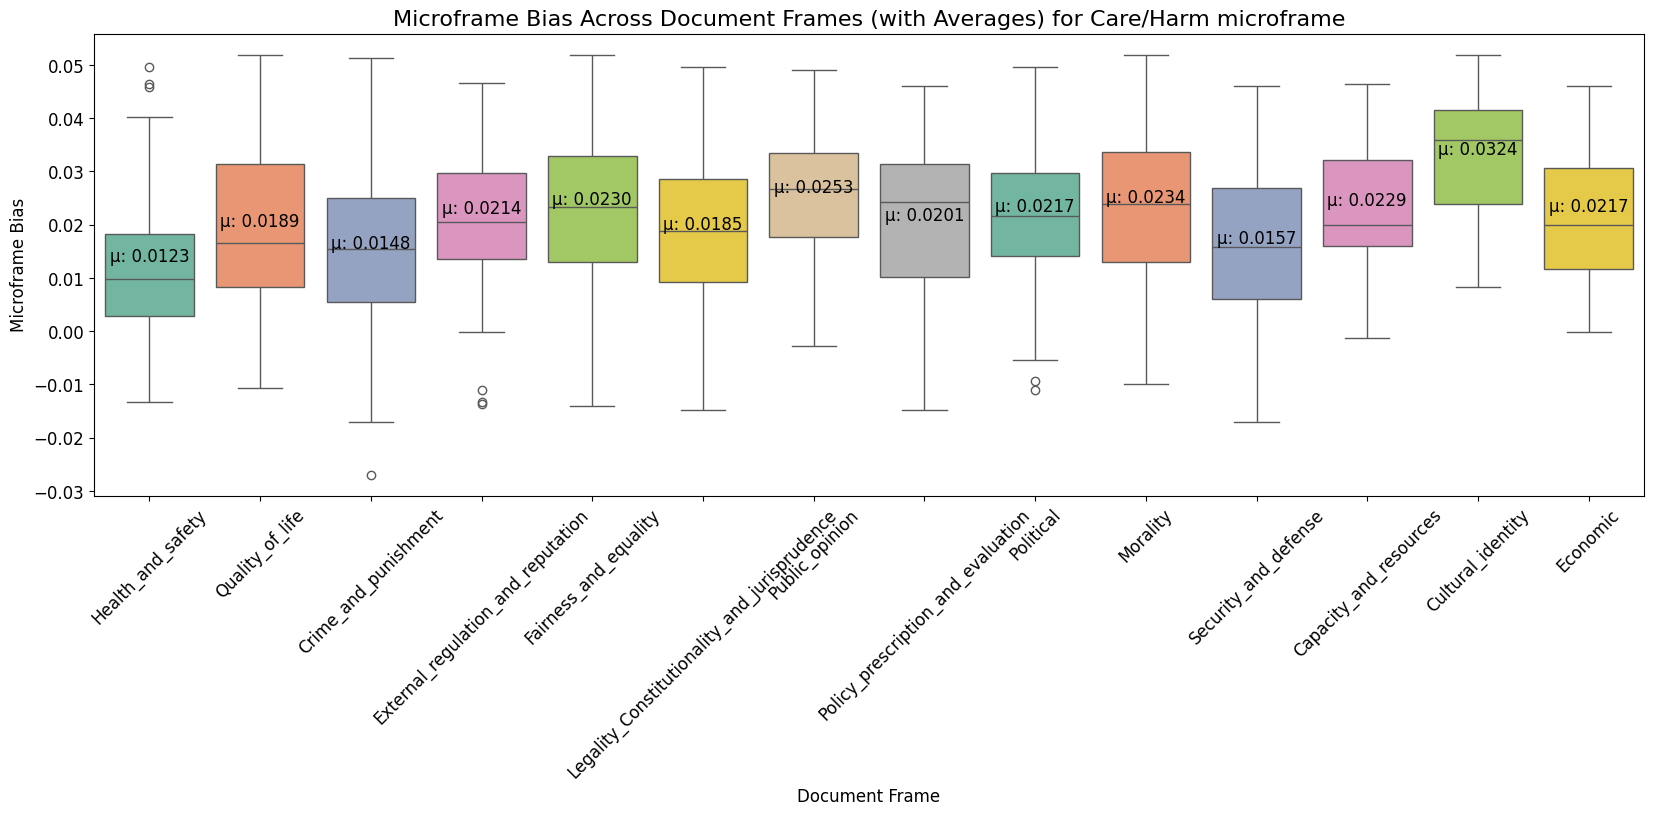

C:\Users\elias\AppData\Local\Temp\ipykernel_12376\2024163009.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='frames', y=foundation + '_bias', data=df, palette='Set2')


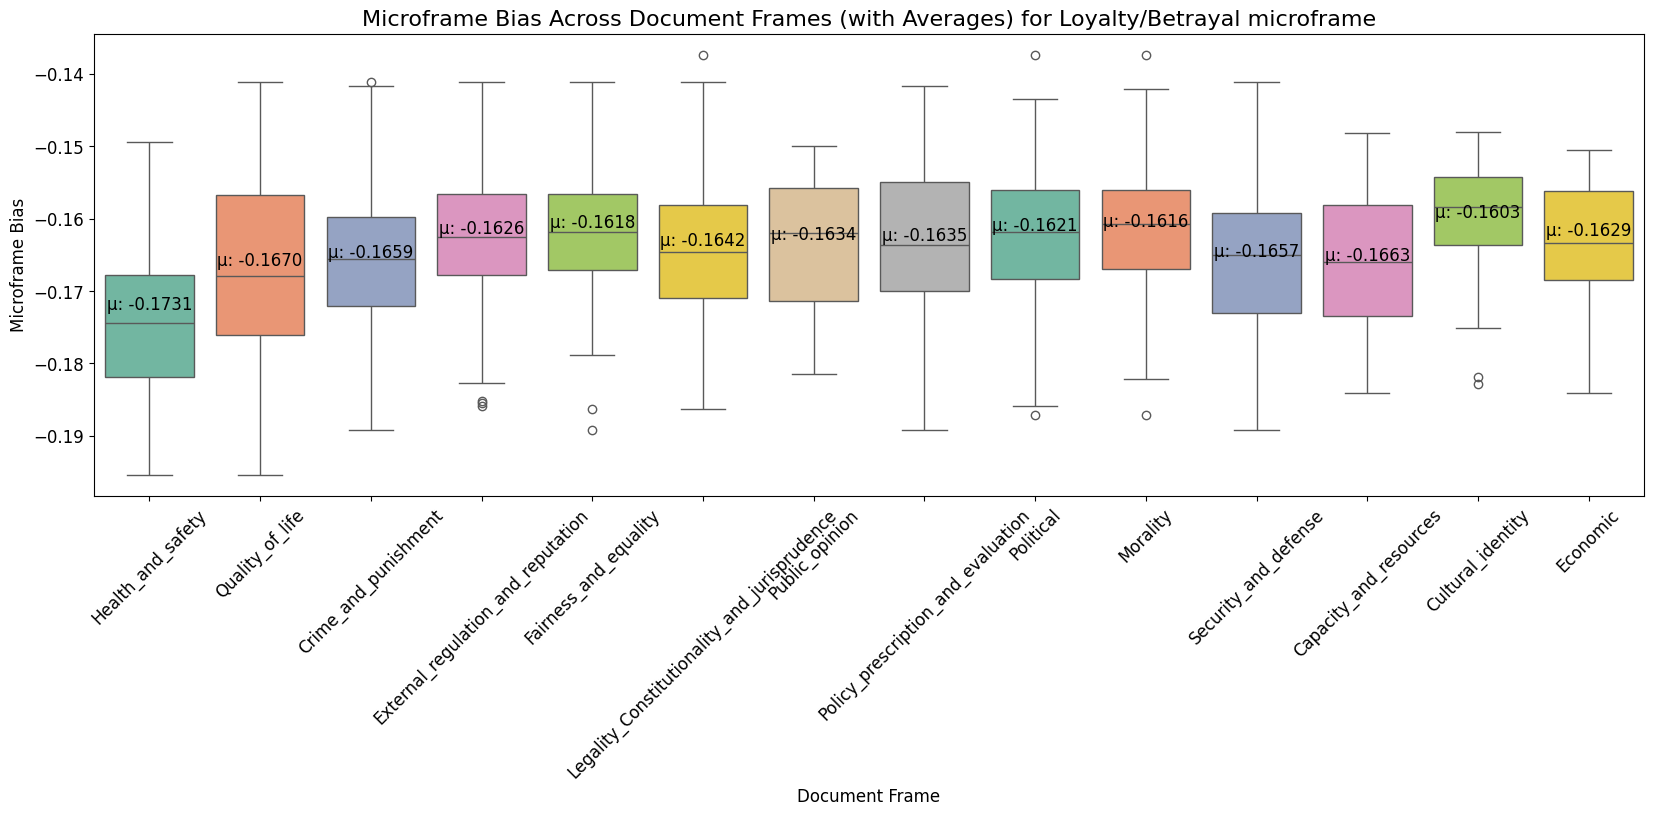

C:\Users\elias\AppData\Local\Temp\ipykernel_12376\2024163009.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='frames', y=foundation + '_bias', data=df, palette='Set2')


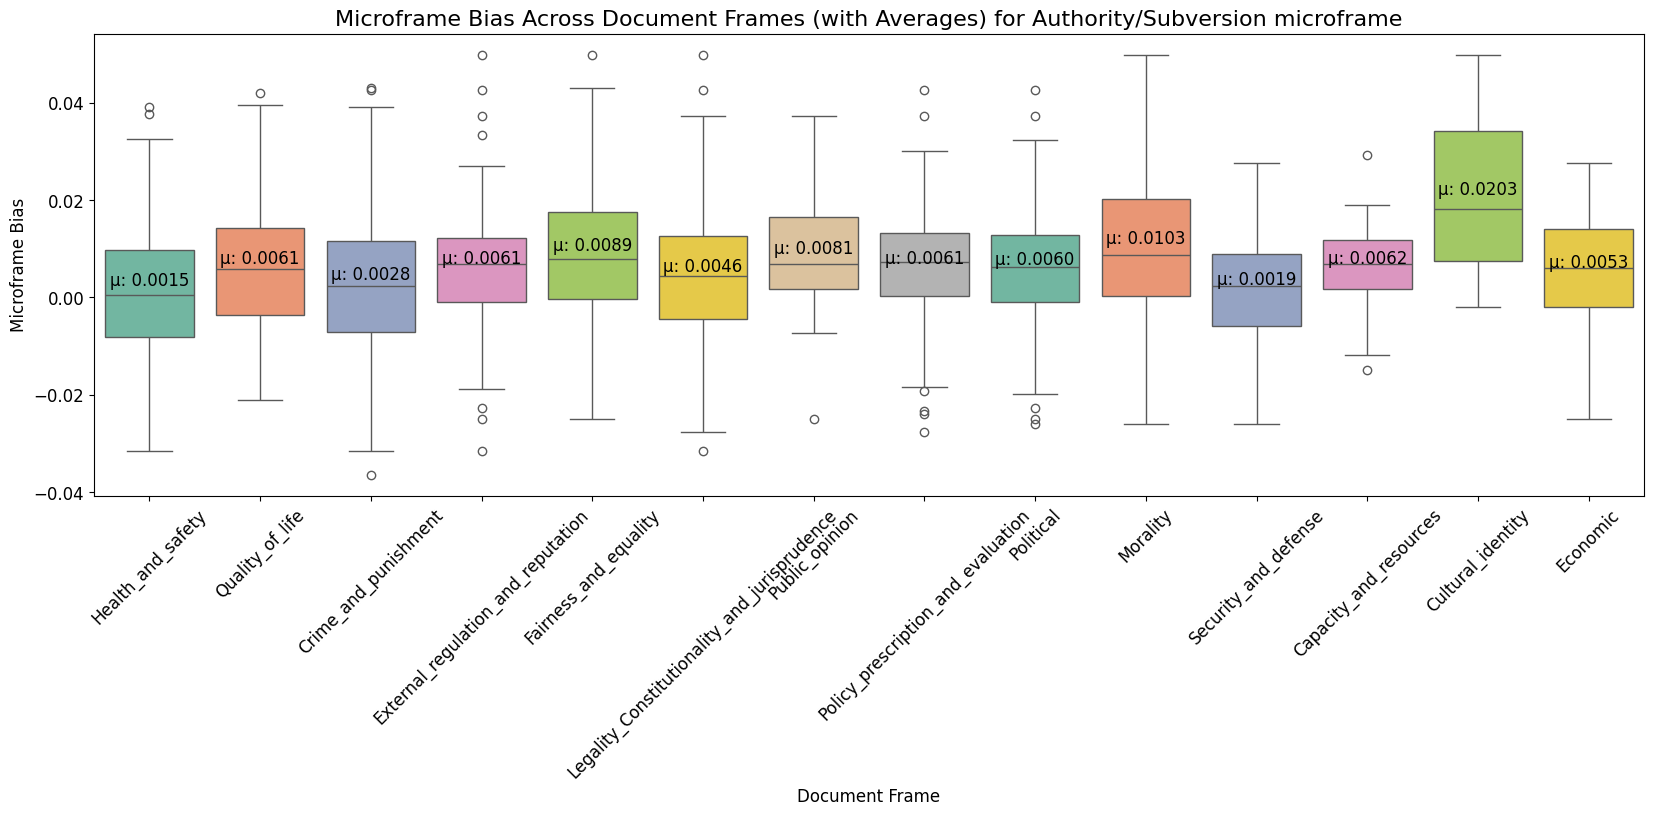

C:\Users\elias\AppData\Local\Temp\ipykernel_12376\2024163009.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='frames', y=foundation + '_bias', data=df, palette='Set2')


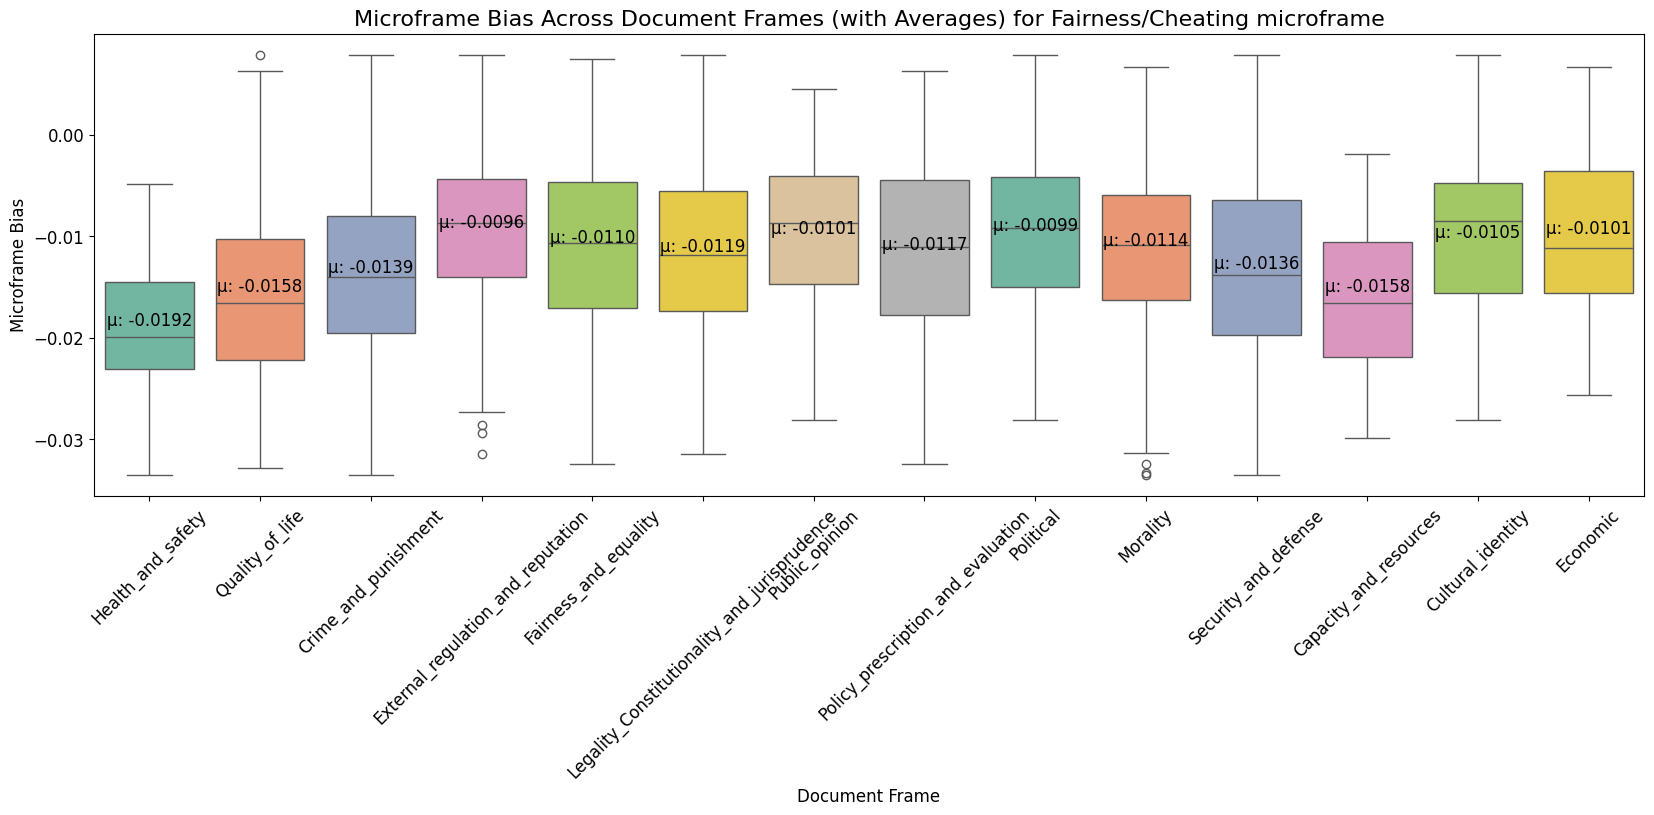

C:\Users\elias\AppData\Local\Temp\ipykernel_12376\2024163009.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='frames', y=foundation + '_bias', data=df, palette='Set2')


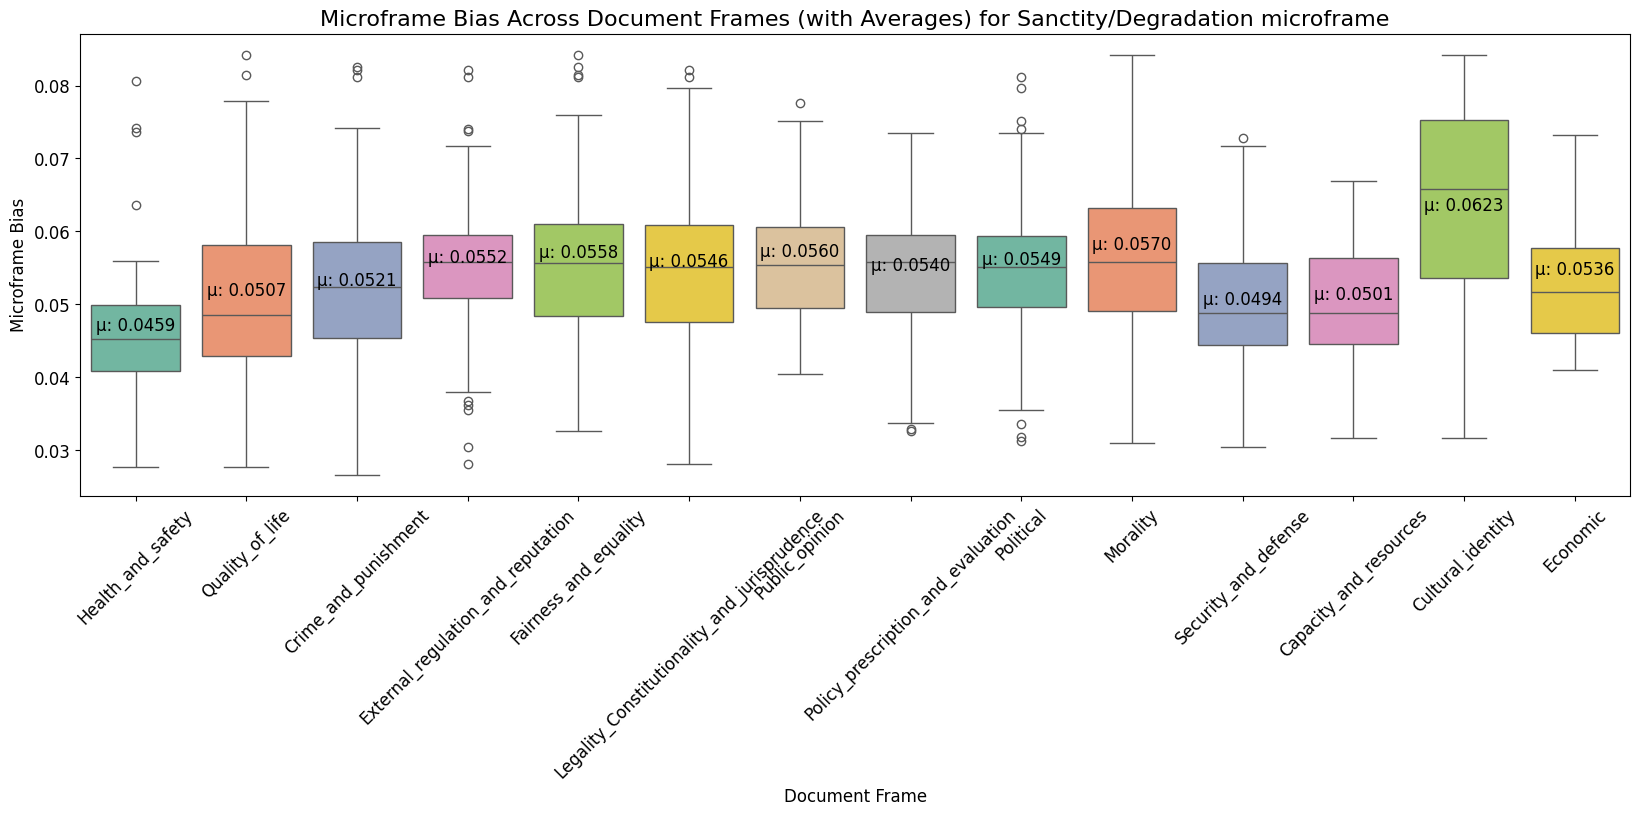

In [131]:
def plot_bias_per_foundation(foundation):
    means = df.groupby('frames')[foundation + '_bias'].mean().reset_index()

    # Plotting
    plt.figure(figsize=(20, 6))
    ax = sns.boxplot(x='frames', y=foundation + '_bias', data=df, palette='Set2')
    plt.title(f'Microframe Bias Across Document Frames (with Averages) for {microframe_map[foundation]} microframe', fontsize=title_fontsize)

    # Annotating each box with the mean value
    for i, frame in enumerate(ax.get_xticklabels()):
        frame = frame.get_text()
        mean_val = means.loc[means['frames'] == frame, foundation + '_bias'].values[0]
        plt.text(i, mean_val, f'μ: {mean_val:.4f}', fontsize=12, ha='center', va='bottom', color='black')

    plt.xlabel('Document Frame', fontsize=label_fontsize)
    plt.ylabel('Microframe Bias', fontsize=label_fontsize)
    plt.xticks(fontsize=ticks_fontsize, rotation=45)
    plt.yticks(fontsize=ticks_fontsize)
    plt.show()

plot_bias_per_foundation('care')
plot_bias_per_foundation('loyalty')
plot_bias_per_foundation('authority')
plot_bias_per_foundation('fairness')
plot_bias_per_foundation('sanctity')

C:\Users\elias\AppData\Local\Temp\ipykernel_12376\1049322301.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='frames', y=foundation + '_intensity', data=df, palette='Set2')


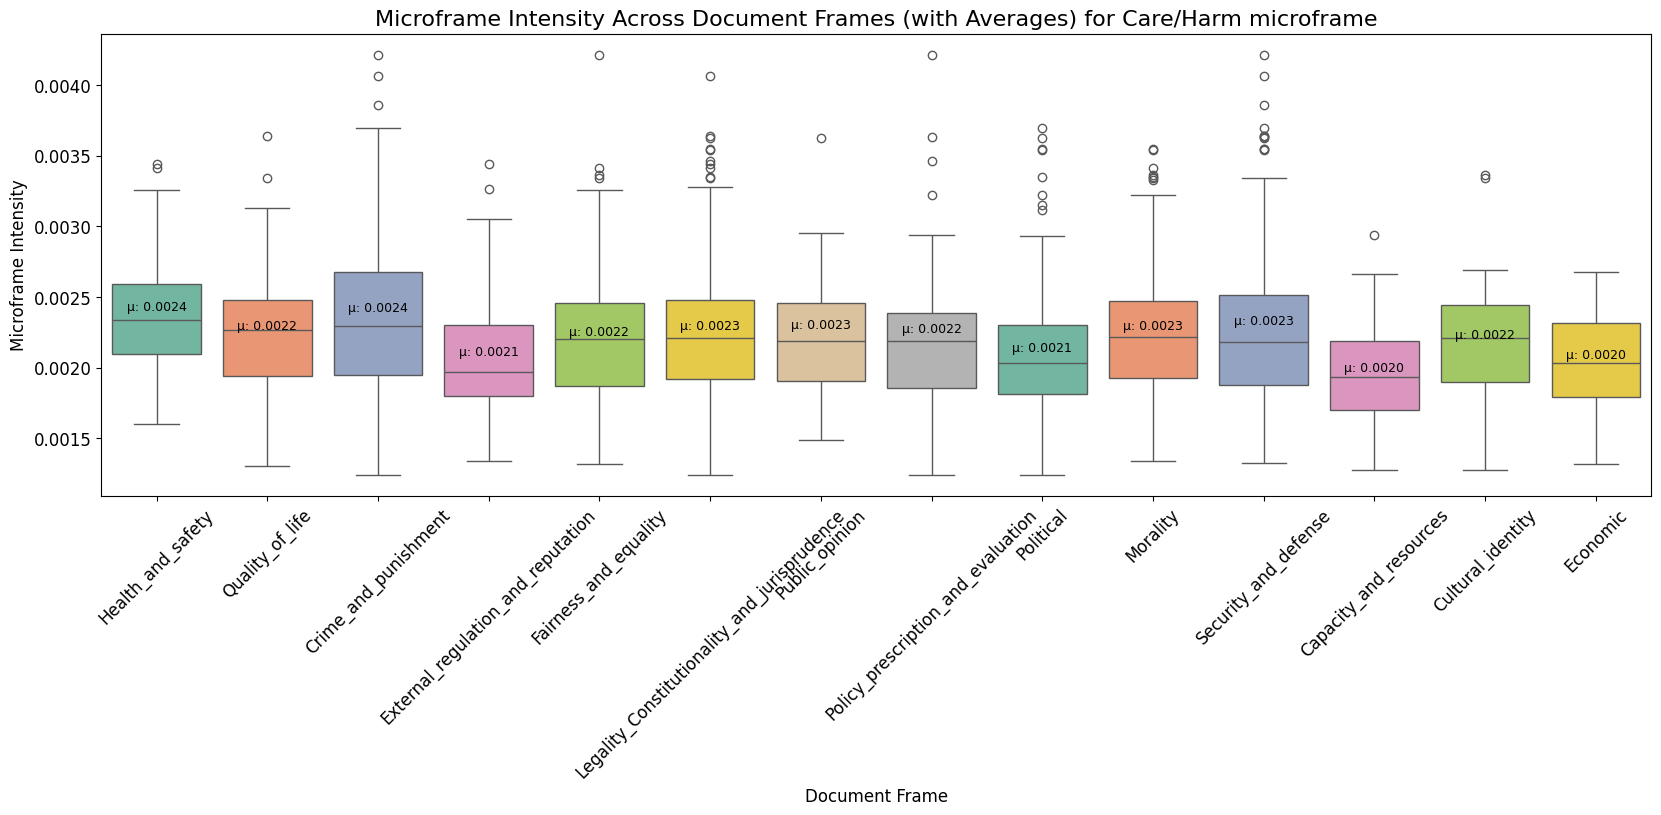

C:\Users\elias\AppData\Local\Temp\ipykernel_12376\1049322301.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='frames', y=foundation + '_intensity', data=df, palette='Set2')


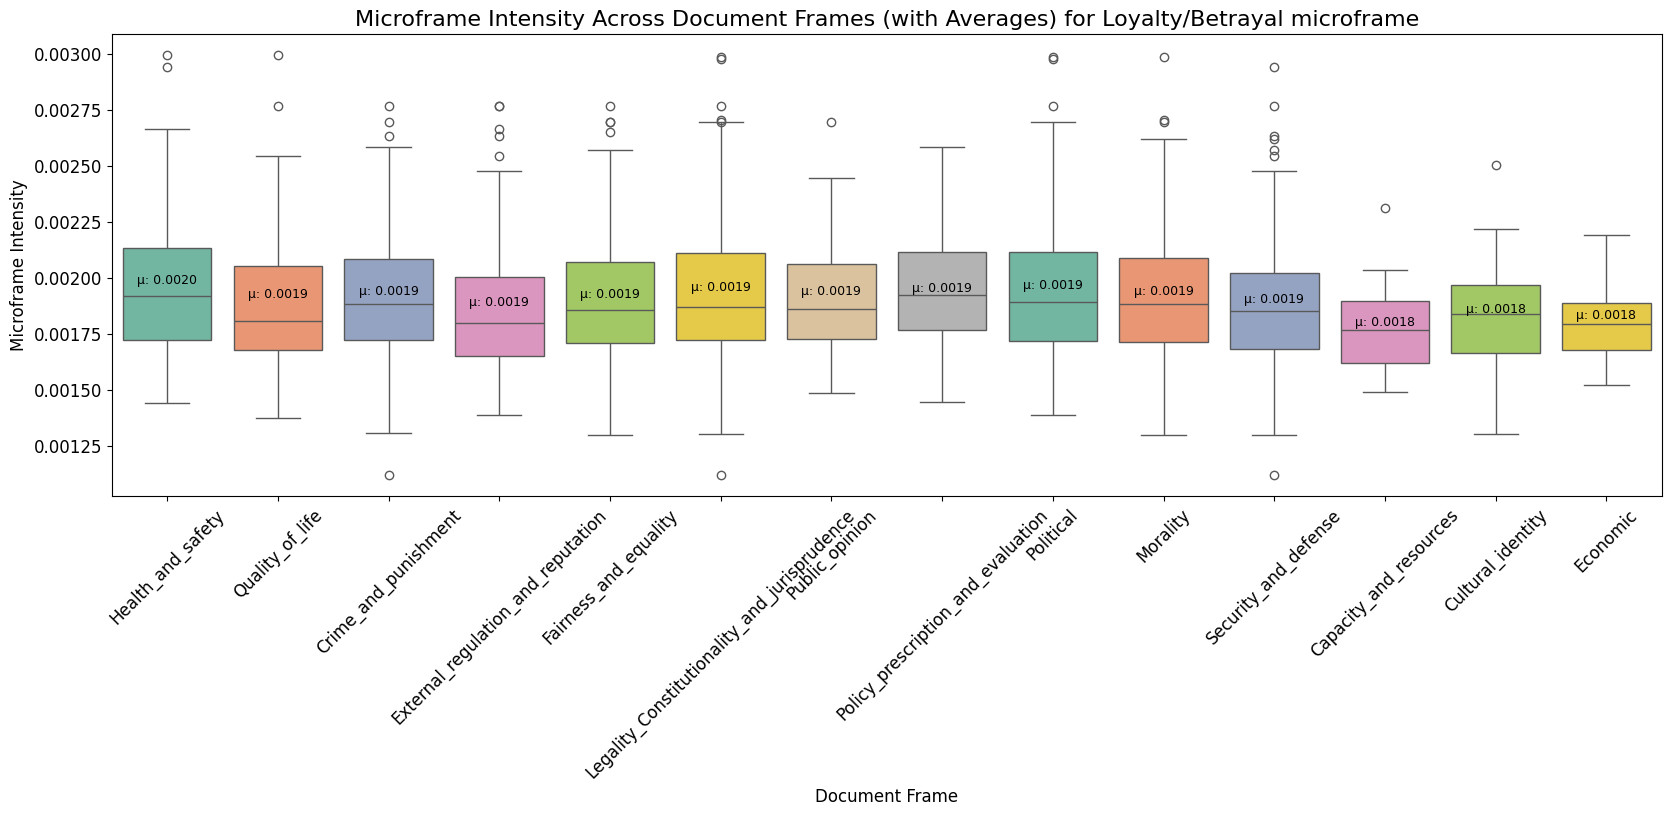

C:\Users\elias\AppData\Local\Temp\ipykernel_12376\1049322301.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='frames', y=foundation + '_intensity', data=df, palette='Set2')


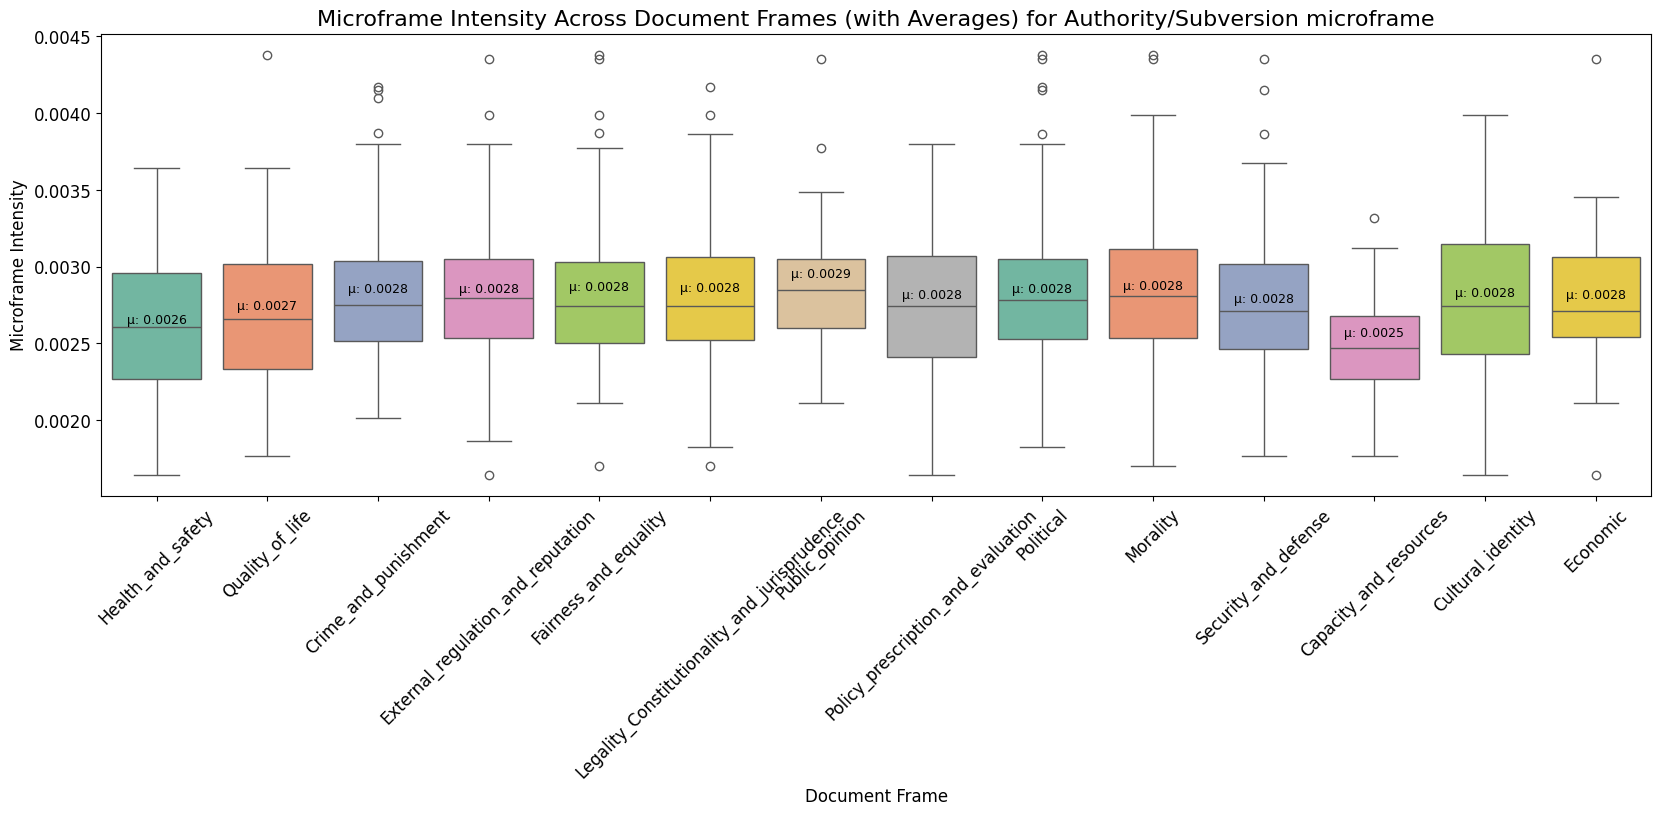

C:\Users\elias\AppData\Local\Temp\ipykernel_12376\1049322301.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='frames', y=foundation + '_intensity', data=df, palette='Set2')


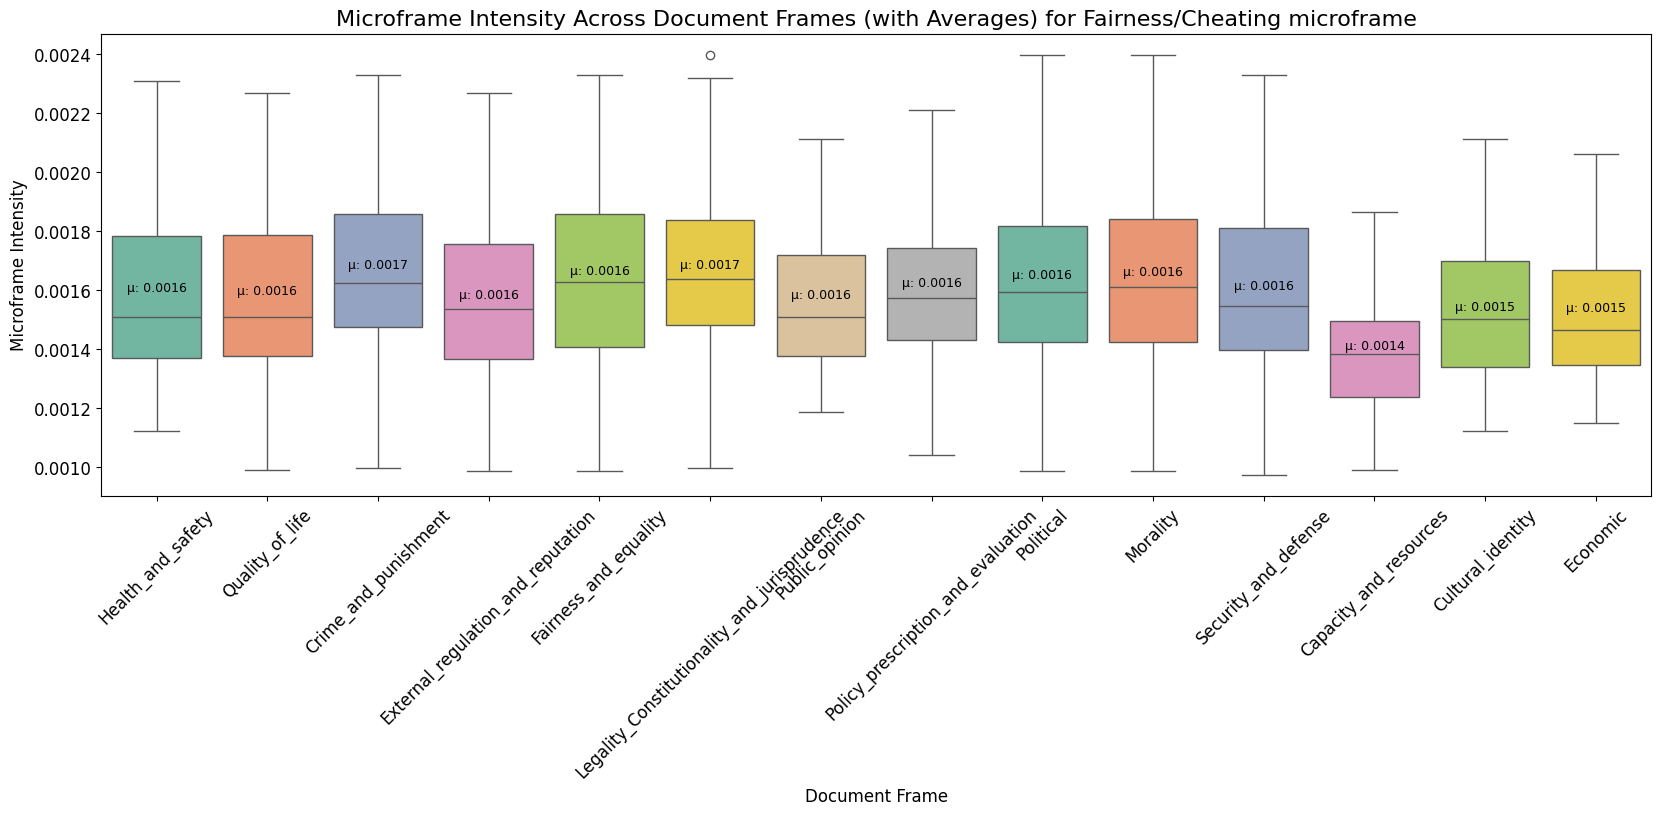

C:\Users\elias\AppData\Local\Temp\ipykernel_12376\1049322301.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='frames', y=foundation + '_intensity', data=df, palette='Set2')


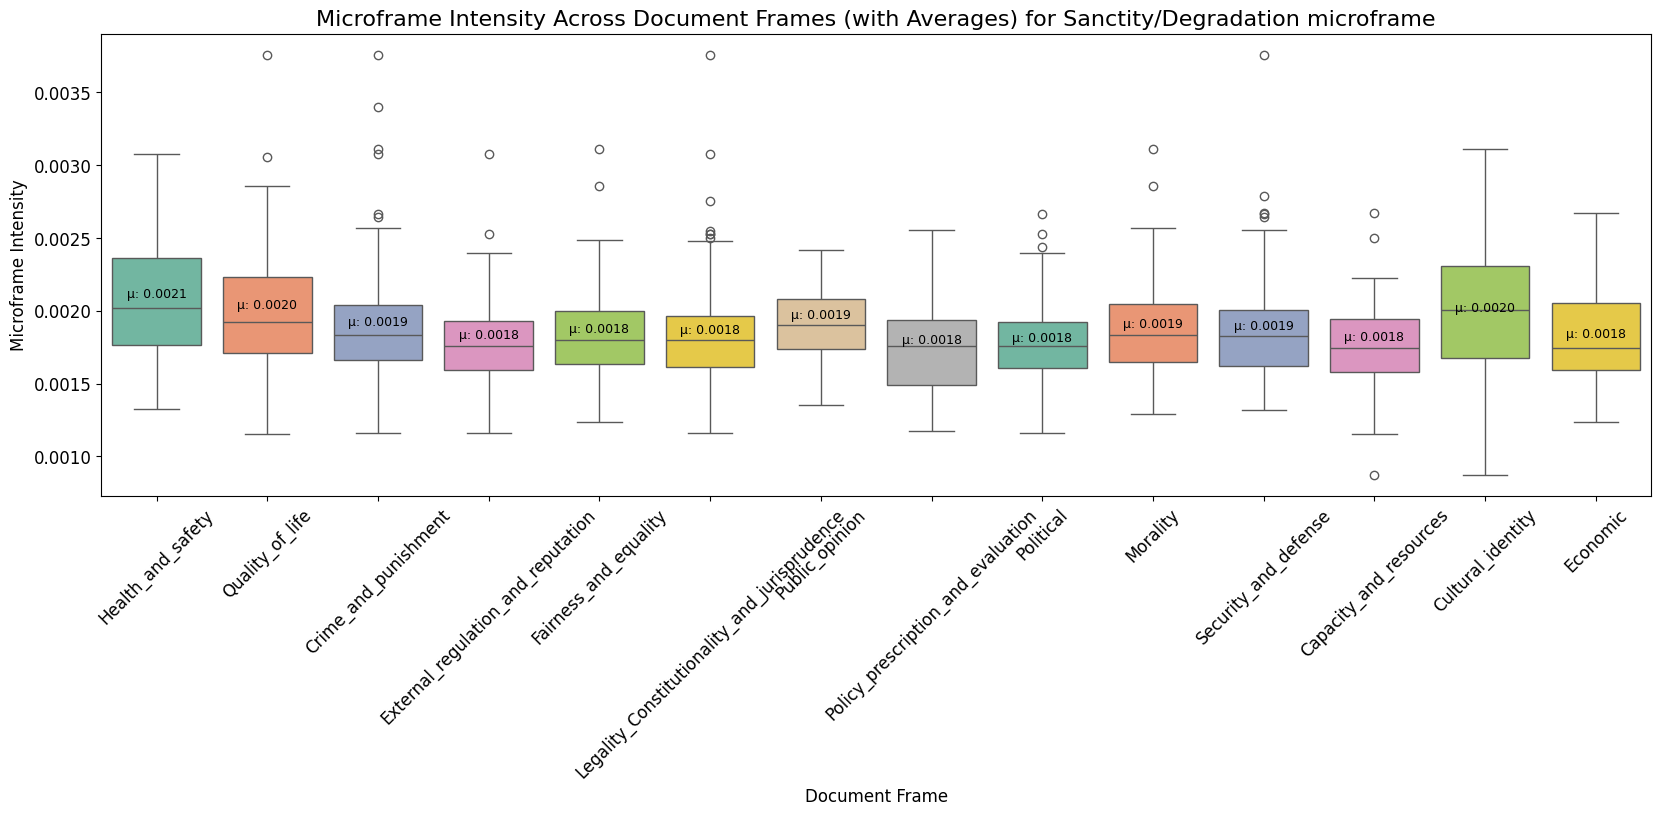

In [132]:
def plot_intensity_per_foundation(foundation):
    means = df.groupby('frames')[foundation + '_intensity'].mean().reset_index()

    # Plotting
    plt.figure(figsize=(20, 6))
    ax = sns.boxplot(x='frames', y=foundation + '_intensity', data=df, palette='Set2')
    plt.title(f'Microframe Intensity Across Document Frames (with Averages) for {microframe_map[foundation]} microframe', fontsize=title_fontsize)

    # Annotating each box with the mean value
    for i, frame in enumerate(ax.get_xticklabels()):
        frame = frame.get_text()
        mean_val = means.loc[means['frames'] == frame, foundation + '_intensity'].values[0]
        plt.text(i, mean_val, f'μ: {mean_val:.4f}', fontsize=9, ha='center', va='bottom', color='black')

    plt.xlabel('Document Frame', fontsize=label_fontsize)
    plt.ylabel('Microframe Intensity', fontsize=label_fontsize)
    plt.xticks(fontsize=ticks_fontsize, rotation=45)
    plt.yticks(fontsize=ticks_fontsize)
    plt.show()

plot_intensity_per_foundation('care')
plot_intensity_per_foundation('loyalty')
plot_intensity_per_foundation('authority')
plot_intensity_per_foundation('fairness')
plot_intensity_per_foundation('sanctity')

### Plot Bias as X and Intensity as Y axis

In [140]:
df.head(3)

article_id                frames  authority_bias  authority_intensity  \
0  111111111     Health_and_safety       -0.003820             0.002121   
1  111111111       Quality_of_life       -0.003820             0.002121   
2  111111112  Crime_and_punishment        0.009352             0.003776   

   care_bias  care_intensity  fairness_bias  fairness_intensity  loyalty_bias  \
0   0.016229        0.001979      -0.024629            0.001316     -0.183807   
1   0.016229        0.001979      -0.024629            0.001316     -0.183807   
2   0.037455        0.002702      -0.005936            0.001784     -0.159022   

   loyalty_intensity  sanctity_bias  sanctity_intensity  \
0           0.001861       0.027722            0.002681   
1           0.001861       0.027722            0.002681   
2           0.002073       0.060063            0.002007   

                                                text     type  \
0  Next plague outbreak in Madagascar could be 's...  opinion   
1  Next plague outbreak in Madagascar could be 's...  opinion   
2  US bloggers banned from entering UK. Two promi...  opinion   

                       frame_type  
0     Health_and_safety - opinion  
1       Quality_of_life - opinion  
2  Crime_and_punishment - opinion

In [133]:
# find text which includes: "BILL ON IMMIGRANT WORKERS"
df_merged[df_merged['text'].str.contains("BILL ON IMMIGRANT WORKERS")]

Empty DataFrame
Columns: [text, type, Capacity_and_resources, Crime_and_punishment, Cultural_identity, Economic, External_regulation_and_reputation, Fairness_and_equality, Health_and_safety, Legality_Constitutionality_and_jurisprudence, Morality, Policy_prescription_and_evaluation, Political, Public_opinion, Quality_of_life, Security_and_defense, authority_bias, authority_intensity, care_bias, care_intensity, fairness_bias, fairness_intensity, loyalty_bias, loyalty_intensity, sanctity_bias, sanctity_intensity]
Index: []

[0 rows x 26 columns]

In [141]:
df[df['article_id'] == "111111111"]

article_id             frames  authority_bias  authority_intensity  \
0  111111111  Health_and_safety        -0.00382             0.002121   
1  111111111    Quality_of_life        -0.00382             0.002121   

   care_bias  care_intensity  fairness_bias  fairness_intensity  loyalty_bias  \
0   0.016229        0.001979      -0.024629            0.001316     -0.183807   
1   0.016229        0.001979      -0.024629            0.001316     -0.183807   

   loyalty_intensity  sanctity_bias  sanctity_intensity  \
0           0.001861       0.027722            0.002681   
1           0.001861       0.027722            0.002681   

                                                text     type  \
0  Next plague outbreak in Madagascar could be 's...  opinion   
1  Next plague outbreak in Madagascar could be 's...  opinion   

                    frame_type  
0  Health_and_safety - opinion  
1    Quality_of_life - opinion

In [143]:
idx_article = 0

authority_example_value_article = {
    'x': df.iloc[idx_article]['authority_bias'],
    'y': df.iloc[idx_article]['authority_intensity'],
    'label': df.iloc[idx_article]['article_id'] + " - " + df.iloc[idx_article]['frame_type']
}

care_example_value_article = {
    'x': df.iloc[idx_article]['care_bias'],
    'y': df.iloc[idx_article]['care_intensity'],
    'label': df.iloc[idx_article]['article_id'] + " - " + df.iloc[idx_article]['frame_type']
}

fairness_example_value_article = {
    'x': df.iloc[idx_article]['fairness_bias'],
    'y': df.iloc[idx_article]['fairness_intensity'],
    'label': df.iloc[idx_article]['article_id'] + " - " + df.iloc[idx_article]['frame_type']
}

loyalty_example_value_article = {
    'x': df.iloc[idx_article]['loyalty_bias'],
    'y': df.iloc[idx_article]['loyalty_intensity'],
    'label': df.iloc[idx_article]['article_id'] + " - " + df.iloc[idx_article]['frame_type']
}

sanctity_example_value_article = {
    'x': df.iloc[idx_article]['sanctity_bias'],
    'y': df.iloc[idx_article]['sanctity_intensity'],
    'label': df.iloc[idx_article]['article_id'] + " - " + df.iloc[idx_article]['frame_type']
}

# print full text
print(df.iloc[idx_article]['text'])

df.iloc[idx_article]

Next plague outbreak in Madagascar could be 'stronger': WHO. Geneva - The World Health Organisation chief on Wednesday said a deadly plague epidemic appeared to have been brought under control in Madagascar, but warned the next outbreak would likely be stronger.. "The next transmission could be more pronounced or stronger," WHO Director-General Tedros Adhanom Ghebreyesus told reporters in Geneva, insisting that "the issue is serious.". An outbreak of both bubonic plague, which is spread by infected rats via flea bites, and pneumonic plague, spread person to person, has killed more than 200 people in the Indian Ocean island nation since August.. Madagascar has suffered bubonic plague outbreaks almost every year since 1980, often caused by rats fleeing forest fires.. The disease tends to make a comeback each hot rainy season, from September to April. On average, between 300 and 600 infections are recorded every year among a population approaching 25 million people, according to a UN esti

article_id                                                     111111111
frames                                                 Health_and_safety
authority_bias                                                  -0.00382
authority_intensity                                             0.002121
care_bias                                                       0.016229
care_intensity                                                  0.001979
fairness_bias                                                  -0.024629
fairness_intensity                                              0.001316
loyalty_bias                                                   -0.183807
loyalty_intensity                                               0.001861
sanctity_bias                                                   0.027722
sanctity_intensity                                              0.002681
text                   Next plague outbreak in Madagascar could be 's...
type                                               

In [165]:
df_sentences.head(2)

text     type  \
111111111  Next plague outbreak in Madagascar could be 's...  opinion   
111111111  Next plague outbreak in Madagascar could be 's...  opinion   

           authority_bias  authority_intensity  care_bias  care_intensity  \
111111111        0.021544             0.002952   0.017378        0.001236   
111111111        0.021544             0.002952   0.017378        0.001236   

           fairness_bias  fairness_intensity  loyalty_bias  loyalty_intensity  \
111111111      -0.055926            0.002614     -0.170797           0.001782   
111111111      -0.055926            0.002614     -0.170797           0.001782   

           sanctity_bias  sanctity_intensity             frames  \
111111111       0.000643            0.004666  Health_and_safety   
111111111       0.000643            0.004666    Quality_of_life   

                            frame_type article_id  
111111111  Health_and_safety - opinion  111111111  
111111111    Quality_of_life - opinion  111111111

In [164]:
idx_sentence = 542

authority_example_value_sentence = {
    "x": df_sentences.iloc[idx_sentence]["authority_bias"],
    "y": df_sentences.iloc[idx_sentence]["authority_intensity"],
    "label": df_sentences.iloc[idx_sentence]["article_id"] + " - " + df_sentences.iloc[idx_sentence]["frame_type"],
}

care_example_value_sentence = {
    "x": df_sentences.iloc[idx_sentence]["care_bias"],
    "y": df_sentences.iloc[idx_sentence]["care_intensity"],
    "label": df_sentences.iloc[idx_sentence]["article_id"] + " - " + df_sentences.iloc[idx_sentence]["frame_type"],
}

fairness_example_value_sentence = {
    "x": df_sentences.iloc[idx_sentence]["fairness_bias"],
    "y": df_sentences.iloc[idx_sentence]["fairness_intensity"],
    "label": df_sentences.iloc[idx_sentence]["article_id"] + " - " + df_sentences.iloc[idx_sentence]["frame_type"],
}

loyalty_example_value_sentence = {
    "x": df_sentences.iloc[idx_sentence]["loyalty_bias"],
    "y": df_sentences.iloc[idx_sentence]["loyalty_intensity"],
    "label": df_sentences.iloc[idx_sentence]["article_id"] + " - " + df_sentences.iloc[idx_sentence]["frame_type"],
}

sanctity_example_value_sentence = {
    "x": df_sentences.iloc[idx_sentence]["sanctity_bias"],
    "y": df_sentences.iloc[idx_sentence]["sanctity_intensity"],
    "label": df_sentences.iloc[idx_sentence]["article_id"] + " - " + df_sentences.iloc[idx_sentence]["frame_type"],
}

# print full text
print(df_merged.iloc[idx_sentence]["text"])

df_merged.iloc[idx_sentence]

This helps explain why Iran has placed so much importance on helping the Syrian regime establish control over the Deir ez-Zor area in eastern Syria, near the Iraqi border.


text                                            This helps explain why Iran has placed so much...
type                                                                                      opinion
Capacity_and_resources                                                                          0
Crime_and_punishment                                                                            1
Cultural_identity                                                                               0
Economic                                                                                        0
External_regulation_and_reputation                                                              1
Fairness_and_equality                                                                           0
Health_and_safety                                                                               0
Legality_Constitutionality_and_jurisprudence                                                    0
Morality            

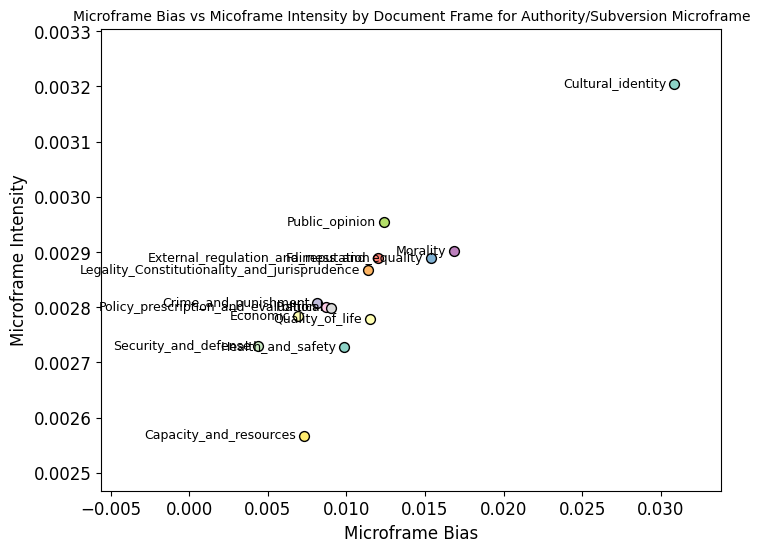

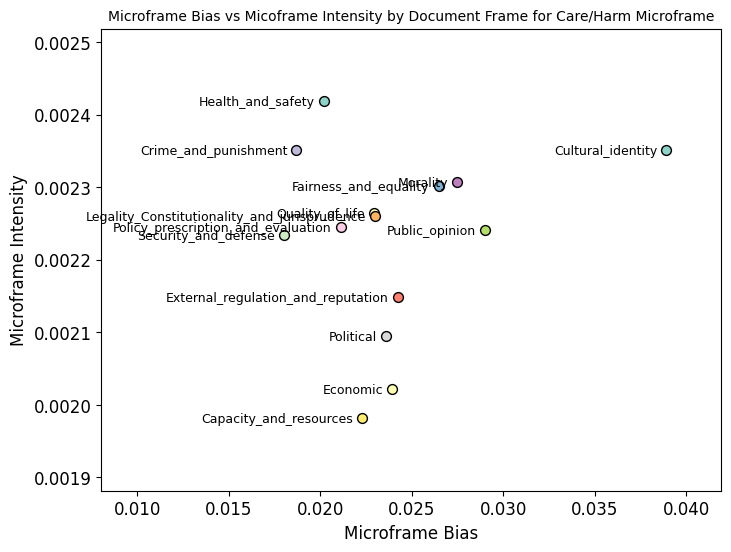

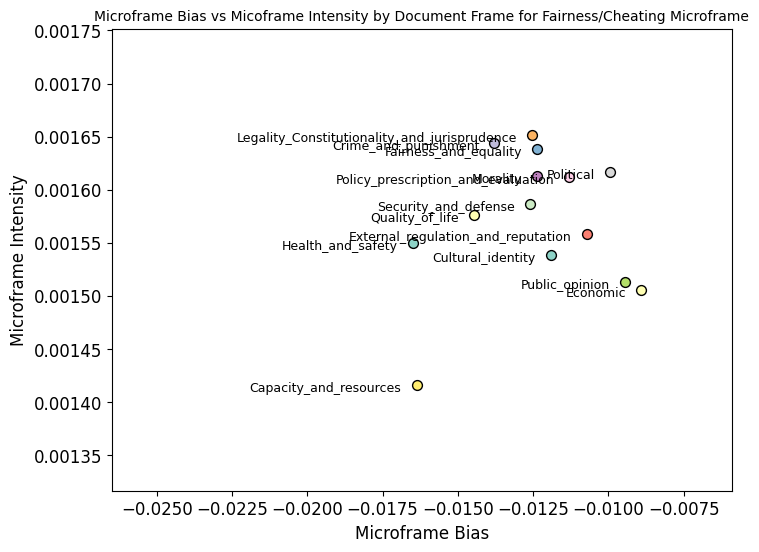

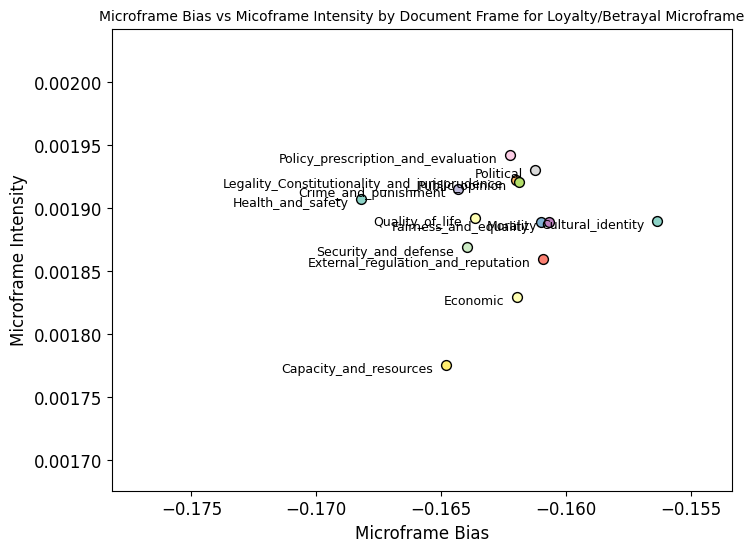

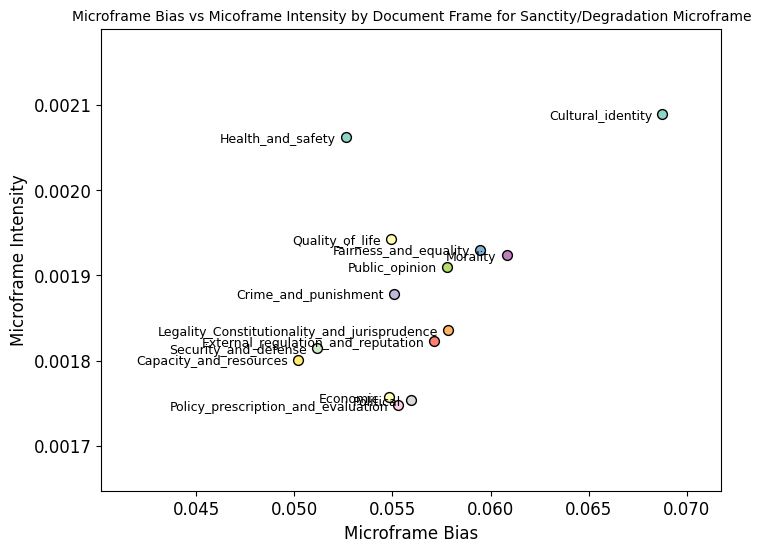

In [171]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_pair(df, pair, group_by=['frame_type'], plot_density={}, types=['opinion', 'reporting', 'satire'], example_plot_value={}):
    # Filter the DataFrame for the types we are interested in
    df_filtered = df[df['type'].isin(types)]
    
    # Set up plot
    plt.figure(figsize=(8, 6))
    
    # List to store points and their labels for later plotting
    points_with_labels = []

    # Iterate over each group type
    for group_type in group_by:
        if group_type in df.columns:
            # Process each unique group within the group type
            unique_groups = df_filtered[group_type].unique()
            for group_name in unique_groups:
                group_data = df_filtered[df_filtered[group_type] == group_name]
                
                # Calculate average values for the pair
                avg_bias = group_data[f'{pair}_bias'].mean()
                avg_intensity = group_data[f'{pair}_intensity'].mean()
                
                # Save the point and label for plotting
                points_with_labels.append((avg_bias, avg_intensity, group_name))

                # Extract bias and intensity for KDE plot
                bias_values = group_data[f'{pair}_bias']
                intensity_values = group_data[f'{pair}_intensity']

                if plot_density.get(group_type, False):
                    # KDE plot for the group
                    color = sns.color_palette('Set3')[len(points_with_labels) % len(sns.color_palette('Set3'))]
                    sns.kdeplot(x=bias_values, y=intensity_values, cmap=sns.light_palette(color, as_cmap=True),
                                fill=True, thresh=0.8, levels=10, alpha=0.8, bw_adjust=0.5)

    # Plot points and their labels
    for bias, intensity, label in points_with_labels:
        plt.scatter(bias, intensity, color=sns.color_palette('Set3')[points_with_labels.index((bias, intensity, label)) % len(sns.color_palette('Set3'))], s=50, edgecolor='black')
        plt.text(bias - 0.0005, intensity - 0.000006, label, fontsize=9, ha='right')

    if "x" in example_plot_value and "y" in example_plot_value and "label" in example_plot_value:
        print(f"Plotting example point: {example_plot_value['label']} at ({example_plot_value['x']}, {example_plot_value['y']})")

        points_with_labels.append((example_plot_value["x"], example_plot_value["y"], example_plot_value["label"]))

        # Plot the example point
        plt.scatter(example_plot_value["x"], example_plot_value["y"], color='red', s=50, edgecolor='black')
        plt.text(example_plot_value["x"] - 0.1, example_plot_value["y"], example_plot_value["label"], fontsize=9, ha='right')

    # Adjusting plot limits to fit all points comfortably
    plt.xlim([min([p[0] for p in points_with_labels]) - 0.01, max([p[0] for p in points_with_labels]) + 0.003])
    plt.ylim([min([p[1] for p in points_with_labels]) - 0.0001, max([p[1] for p in points_with_labels]) + 0.0001])

    grouping_method = ', '.join("Document Frame" if elem == "frames" else "Document Frame and Type" for elem in group_by)

    # Add labels and legend
    plt.xlabel(f'Microframe Bias', fontsize=label_fontsize)
    plt.ylabel(f'Microframe Intensity', fontsize=label_fontsize)
    plt.title(f'Microframe Bias vs Micoframe Intensity by {grouping_method} for {microframe_map[pair]} Microframe', fontsize=10)
    plt.xticks(fontsize=ticks_fontsize)
    plt.yticks(fontsize=ticks_fontsize)

    # Show plot
    plt.show()


# Example usage:
plot_pair(df_sentences, 'authority', group_by=['frames'], plot_density={ 'frames': False }, types=['opinion', 'reporting', 'satire']) 
plot_pair(df_sentences, 'care', group_by=['frames'], plot_density={ 'frames': False}, types=['opinion', 'reporting', 'satire'])
plot_pair(df_sentences, 'fairness', group_by=['frames'], plot_density={ 'frames': False}, types=['opinion', 'reporting', 'satire'])
plot_pair(df_sentences, 'loyalty', group_by=['frames'], plot_density={ 'frames': False}, types=['opinion', 'reporting', 'satire'])
plot_pair(df_sentences, 'sanctity', group_by=['frames'], plot_density={ 'frames': False}, types=['opinion', 'reporting', 'satire'])

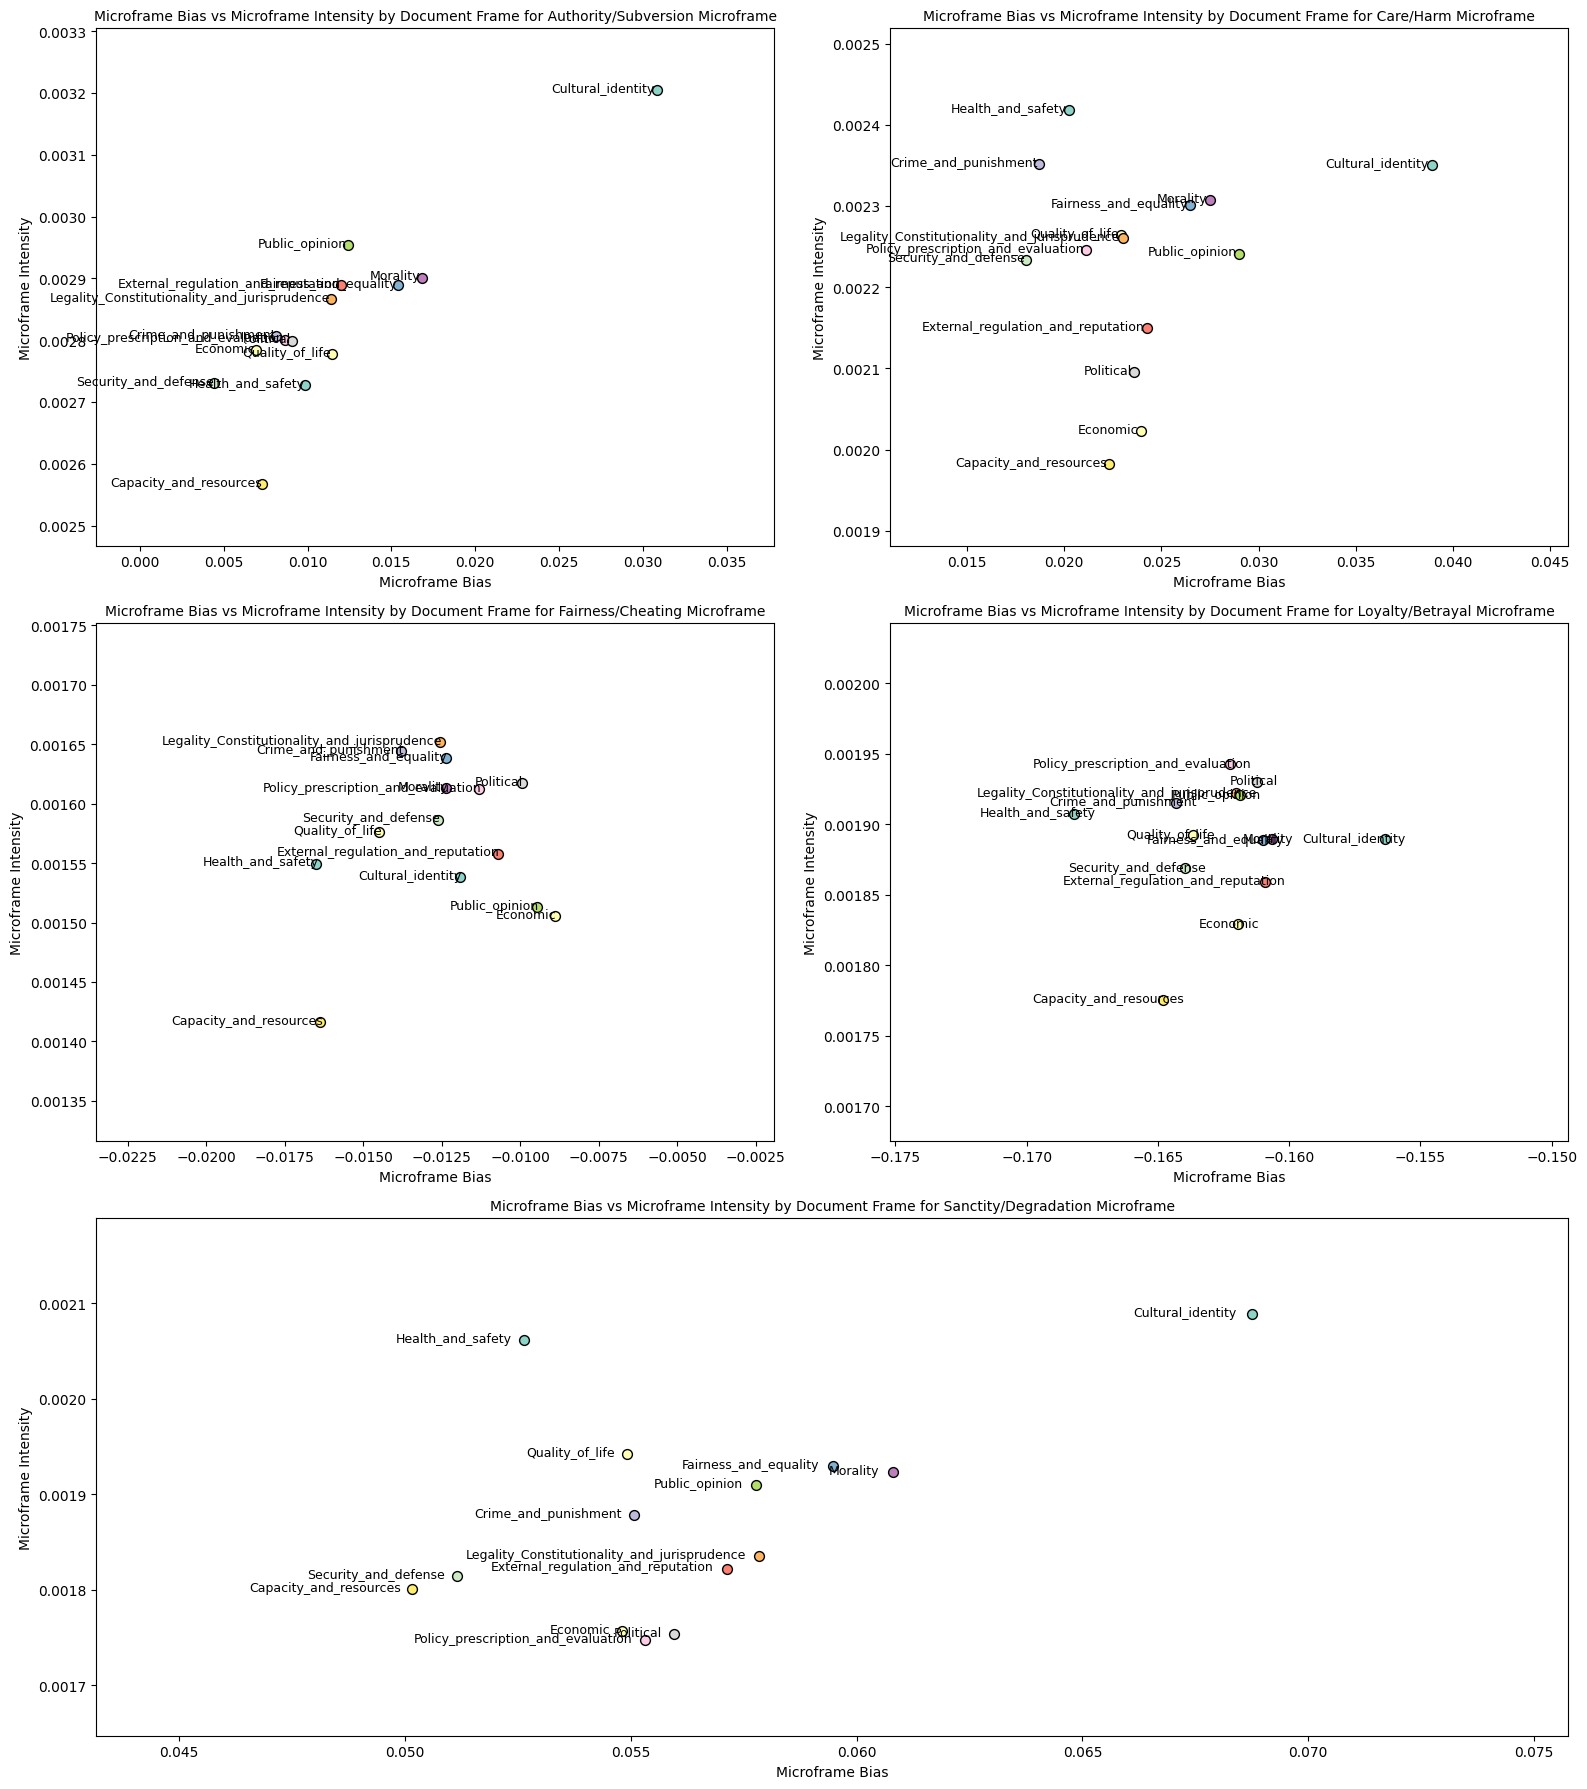

In [173]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_pair(df, pair, group_by=['frame_type'], plot_density={}, types=['opinion', 'reporting', 'satire'], example_plot_value={}, ax=None):
    # Filter the DataFrame for the tones we are interested in
    df_filtered = df[df['type'].isin(types)]
    
    # Set up plot in provided axis
    if ax is None:
        ax = plt.gca()
    
    points_with_labels = []

    for group_type in group_by:
        if group_type in df.columns:
            unique_groups = df_filtered[group_type].unique()
            for group_name in unique_groups:
                group_data = df_filtered[df_filtered[group_type] == group_name]
                
                avg_bias = group_data[f'{pair}_bias'].mean()
                avg_intensity = group_data[f'{pair}_intensity'].mean()
                
                points_with_labels.append((avg_bias, avg_intensity, group_name))

                bias_values = group_data[f'{pair}_bias']
                intensity_values = group_data[f'{pair}_intensity']

                if plot_density.get(group_type, False):
                    color = sns.color_palette('Set3')[len(points_with_labels) % len(sns.color_palette('Set3'))]
                    sns.kdeplot(x=bias_values, y=intensity_values, cmap=sns.light_palette(color, as_cmap=True),
                                fill=True, thresh=0.8, levels=10, alpha=0.8, bw_adjust=0.5, ax=ax)

    for bias, intensity, label in points_with_labels:
        ax.scatter(bias, intensity, color=sns.color_palette('Set3')[points_with_labels.index((bias, intensity, label)) % len(sns.color_palette('Set3'))], s=50, edgecolor='black')
        ax.text(bias * 0.995, intensity * 0.999, label, fontsize=9, ha='right')

    if "x" in example_plot_value and "y" in example_plot_value and "label" in example_plot_value:
        points_with_labels.append((example_plot_value["x"], example_plot_value["y"], example_plot_value["label"]))
        ax.scatter(example_plot_value["x"], example_plot_value["y"], color='red', s=50, edgecolor='black')
        ax.text(example_plot_value["x"], example_plot_value["y"], example_plot_value["label"], fontsize=9, ha='right')

    ax.set_xlim([min([p[0] for p in points_with_labels]) - 0.007, max([p[0] for p in points_with_labels]) + 0.007])
    ax.set_ylim([min([p[1] for p in points_with_labels]) - 0.0001, max([p[1] for p in points_with_labels]) + 0.0001])

    grouping_method = ', '.join("Document Frame" if elem == "frames" else "Document Frame and Types" for elem in group_by)

    ax.set_xlabel(f'Microframe Bias')
    ax.set_ylabel(f'Microframe Intensity')
    ax.set_title(f'Microframe Bias vs Microframe Intensity by {grouping_method} for {microframe_map[pair]} Microframe', fontsize=10)

# Create a figure with 2 columns and 3 rows, but make last plot span two columns
plt.figure(figsize=(16, 18))
pairs = ['authority', 'care', 'fairness', 'loyalty', 'sanctity']
for i, pair in enumerate(pairs):
    if i < 4:
        ax = plt.subplot(3, 2, i+1)
    else:
        ax = plt.subplot(3, 2, (i+1, i+3))  # Make the last plot span two columns
    plot_pair(df_sentences, pair, group_by=['frames'], plot_density={'frames': False}, types=['opinion', 'reporting', 'satire'], ax=ax)

plt.tight_layout()
plt.show()


### Plot Pair for single document_frame

frames
Crime_and_punishment    227
Name: count, dtype: int64
Plotting example point: 111111111 - Health_and_safety - opinion at (0.01622855800710342, 0.0019789471974952966)


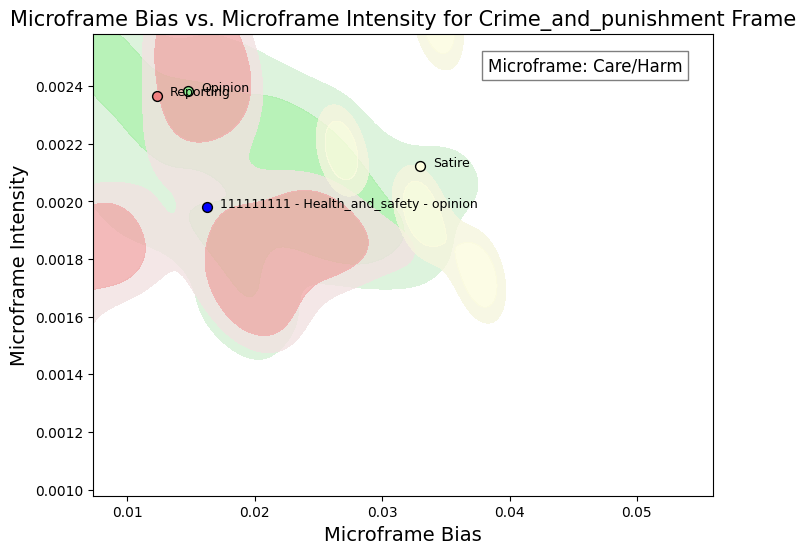

In [175]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.transforms as transforms


def plot_pair_by_type_within_frame(
    df,
    pair,
    frames,
    plot_density=True,
    types=["opinion", "reporting", "satire"],
    example_plot_value={},
    colors={"opinion": "lightgreen", "reporting": "lightcoral", "satire": "lightyellow"},
):
    # Filter the DataFrame for the specified document frame
    df_filtered = df[df["frames"] == frames]

    print(df_filtered["frames"].value_counts())

    # Set up plot
    plt.figure(figsize=(8, 6))

    # Initialize a list to keep track of points for plot limits
    points_with_labels = []

    # Iterate over each specified type within the document frame
    for type in types:
        type_data = df_filtered[df_filtered["type"] == type]

        if type == "opinion":
            type_label = "Opinion"
        elif type == "reporting":
            type_label = "Reporting"
        elif type == "satire":
            type_label = "Satire"

        # Calculate average values for the pair
        avg_bias = type_data[f"{pair}_bias"].mean()
        avg_intensity = type_data[f"{pair}_intensity"].mean()

        # Save the average point and label for plotting
        points_with_labels.append((avg_bias, avg_intensity, type))

        # Extract bias and intensity for KDE plot if required
        bias_values = type_data[f"{pair}_bias"]
        intensity_values = type_data[f"{pair}_intensity"]

        color = colors.get(
            type, "gray"
        )  # Default to gray if type is not in the colors dictionary

        if plot_density:
            sns.kdeplot(
                x=bias_values,
                y=intensity_values,
                cmap=sns.light_palette(color, as_cmap=True),
                fill=True,
                thresh=0.5,
                levels=3,
                alpha=0.8,
                bw_adjust=0.5,
            )

        # Plot the average point and label
        plt.scatter(
            avg_bias, avg_intensity, color=color, s=50, edgecolor="black", zorder=5
        )
        plt.text(
            avg_bias + 0.001, avg_intensity, type_label, fontsize=9, ha="left", zorder=6
        )

    if (
        "x" in example_plot_value
        and "y" in example_plot_value
        and "label" in example_plot_value
    ):
        print(
            f"Plotting example point: {example_plot_value['label']} at ({example_plot_value['x']}, {example_plot_value['y']})"
        )
        points_with_labels.append(
            (
                example_plot_value["x"],
                example_plot_value["y"],
                example_plot_value["label"],
            )
        )

        # Plot the example point
        plt.scatter(
            example_plot_value["x"],
            example_plot_value["y"],
            color="blue",
            s=50,
            edgecolor="black",
        )
        plt.text(
            example_plot_value["x"] + 0.001,
            example_plot_value["y"],
            example_plot_value["label"],
            fontsize=9,
            ha="left",
            zorder=6,
        )

    # Adjusting plot limits to fit all points comfortably
    plt.xlim(
        [
            min([p[0] for p in points_with_labels]) - 0.005,
            max([p[0] for p in points_with_labels]) + 0.023,
        ]
    )
    plt.ylim(
        [
            min([p[1] for p in points_with_labels]) - 0.001,
            max([p[1] for p in points_with_labels]) + 0.0002,
        ]
    )

    # Add labels and legend
    plt.xlabel("Microframe Bias", fontsize=14)
    plt.ylabel("Microframe Intensity", fontsize=14)
    plt.title(
        f"Microframe Bias vs. Microframe Intensity for {frames} Frame",
        fontsize=15,
    )

    # Add a text box for the pair
    plt.gca().text(
        0.95,
        0.95,
        f"Microframe: {microframe_map[pair]}",
        transform=plt.gca().transAxes,
        fontsize=12,
        verticalalignment="top",
        horizontalalignment="right",
        bbox=dict(facecolor="white", alpha=0.5),
    )

    # Show plot
    plt.show()


# Example usage:
plot_pair_by_type_within_frame(
    df,
    "care",
    frames="Crime_and_punishment",
    types=["opinion", "reporting", "satire"],
    example_plot_value=care_example_value_article,
)

### Plot Pair for single document_frame for all foundations in a single plot

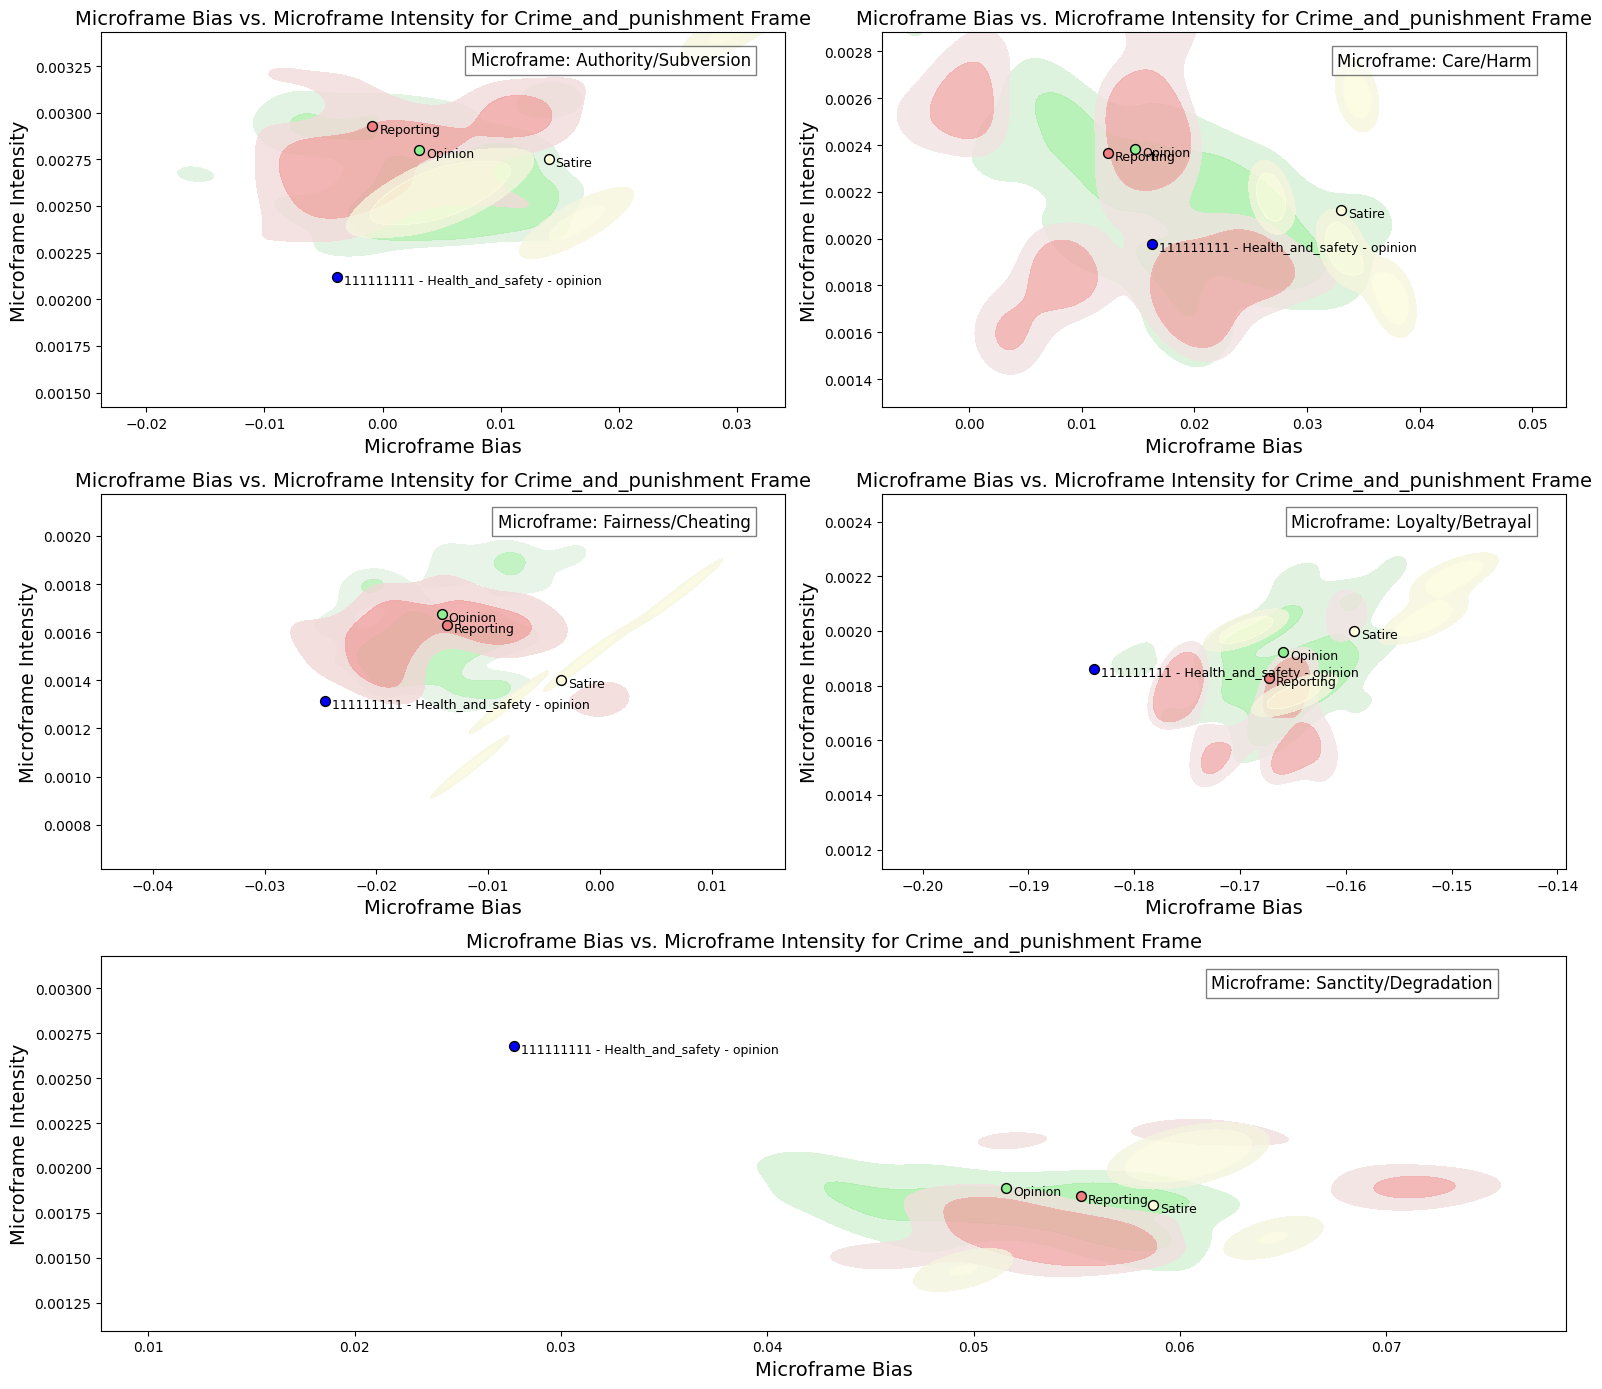

In [178]:
from matplotlib import gridspec

def plot_pairs_by_type_within_frame(df, pairs, frames, plot_density=True, types=['opinion', 'reporting', 'satire'], example_plot_values={}, colors={"opinion": "lightgreen", "reporting": "lightcoral", "satire": "lightyellow"}):
    # Set up the subplot grid
    fig = plt.figure(figsize=(16, 14))
    gs = gridspec.GridSpec(3, 2)

    # Define subplot placement
    axes = []
    for i in range(4):
        row = i // 2
        col = i % 2
        axes.append(fig.add_subplot(gs[row, col]))
    # Add the last subplot which spans both columns in the last row
    axes.append(fig.add_subplot(gs[2, :]))


    # Iterate over each pair and plot
    for i, pair in enumerate(pairs):
        ax = axes[i]
        # Filter the DataFrame for the specified document frame
        df_filtered = df[df['frames'] == frames]

        # Initialize a list to keep track of points for plot limits
        points_with_labels = []

        # Iterate over each specified type within the document frame
        for type in types:
            type_data = df_filtered[df_filtered['type'] == type]

            if type == "opinion":
                type_label = "Opinion"
            elif type == "reporting":
                type_label = "Reporting"
            elif type == "satire":
                type_label = "Satire"


            # Calculate average values for the pair
            avg_bias = type_data[f'{pair}_bias'].mean()
            avg_intensity = type_data[f'{pair}_intensity'].mean()

            # Save the average point and label for plotting
            points_with_labels.append((avg_bias, avg_intensity, type))

            # Extract bias and intensity for KDE plot if required
            bias_values = type_data[f'{pair}_bias']
            intensity_values = type_data[f'{pair}_intensity']

            color = colors.get(type, 'gray')  # Default to gray if type is not in the colors dictionary

            if plot_density:
                sns.kdeplot(x=bias_values, y=intensity_values, cmap=sns.light_palette(color, as_cmap=True),
                            fill=True, thresh=0.5, levels=3, alpha=0.8, bw_adjust=0.5, ax=ax)

            # Plot the average point and label
            ax.scatter(avg_bias, avg_intensity, color=color, s=50, edgecolor='black', zorder=5)
            offset = transforms.ScaledTranslation(5/72, -5/72, plt.gcf().dpi_scale_trans)
            ax.text(avg_bias, avg_intensity, type_label, fontsize=9, ha='left', transform=ax.transData + offset, zorder=6) 

        example_plot_value = example_plot_values.get(pair, {})
        if "x" in example_plot_value and "y" in example_plot_value and "label" in example_plot_value:
            # Plot the example point
            ax.scatter(example_plot_value["x"], example_plot_value["y"], color='blue', s=50, edgecolor='black')
            ax.text(example_plot_value["x"], example_plot_value["y"], example_plot_value["label"], fontsize=9, transform=ax.transData + offset, zorder=6, ha='left')

            points_with_labels.append((example_plot_value["x"], example_plot_value["y"], example_plot_value["label"]))

        # Adjusting plot limits to fit all points comfortably
        ax.set_xlim([min([p[0] for p in points_with_labels]) - 0.02, max([p[0] for p in points_with_labels]) + 0.02])
        ax.set_ylim([min([p[1] for p in points_with_labels]) - 0.0007, max([p[1] for p in points_with_labels]) + 0.0005])

        # Add a text box for the pair
        ax.text(0.95, 0.95, f"Microframe: {microframe_map[pair]}",
                   transform=ax.transAxes, fontsize=12,
                   verticalalignment='top', horizontalalignment='right',
                   bbox=dict(facecolor='white', alpha=0.5))

        # Add labels and title
        ax.set_xlabel('Microframe Bias', fontsize=14)
        ax.set_ylabel('Microframe Intensity', fontsize=14)
        ax.set_title(f'Microframe Bias vs. Microframe Intensity for {frames} Frame', fontsize=14)

    # Adjust layout
    plt.tight_layout()
    plt.show()

# Example usage:
pairs = ['authority', 'care', 'fairness', 'loyalty', 'sanctity']
example_plot_values = {
    'authority': authority_example_value_article,
    'care': care_example_value_article,
    'fairness': fairness_example_value_article,
    'loyalty': loyalty_example_value_article,
    'sanctity': sanctity_example_value_article
}
plot_pairs_by_type_within_frame(df, pairs, 'Crime_and_punishment', types=['opinion', 'reporting', 'satire'], example_plot_values=example_plot_values)

### Microframe Bias and Intensity Shift per Word

In [179]:
contributions_file_name = "frameaxis_semeval_mft_contributions"

In [180]:
import pandas as pd
import json

In [183]:
# read data\frameaxis\mfc\frameaxis_mft_contributions.pkl

df_wc = pd.read_pickle(f"../../data/frameaxis/semeval/{contributions_file_name}.pkl")

df_wc.set_index('article_id', inplace=True)

In [189]:
frame_columns = ['Capacity_and_resources', 'Crime_and_punishment', 'Cultural_identity', 'Economic',
                 'External_regulation_and_reputation', 'Fairness_and_equality', 'Health_and_safety',
                 'Legality_Constitutionality_and_jurisprudence', 'Morality', 'Policy_prescription_and_evaluation',
                 'Political', 'Public_opinion', 'Quality_of_life', 'Security_and_defense']

# Create an empty list to store the new rows
new_rows = []

# Iterate through each row in the dataframe
for idx, row in df_wc.iterrows():
    # For each row, iterate through the frame columns and check if they have a value of 1
    for frame in frame_columns:
        if row[frame] == 1:
            # Create a new row with the 'frames' column set to the current frame
            new_row = row.drop(frame_columns).copy()
            new_row['frames'] = frame
            new_rows.append(new_row)

# Create a new dataframe from the new rows
new_df = pd.DataFrame(new_rows)

In [191]:
df_wc = new_df

In [192]:
df_wc.head(3)

text     type  \
111111111  Next plague outbreak in Madagascar could be 's...  opinion   
111111111  Next plague outbreak in Madagascar could be 's...  opinion   
111111111  Geneva - The World Health Organisation chief o...  opinion   

                                          word_contributions  \
111111111  [{'word': 'next', 'authority': 0.1224514544010...   
111111111  [{'word': 'next', 'authority': 0.1224514544010...   
111111111  [{'word': 'geneva', 'authority': 0.02448894456...   

                      frames  
111111111  Health_and_safety  
111111111    Quality_of_life  
111111111  Health_and_safety

In [193]:
# concat primary_tone and document_frame to create frame_tone
df_wc["frame_type"] = df_wc["frames"] + " - " + df_wc["type"]

df_wc["type"] = pd.Categorical(df_wc["type"], categories=["reporting", "opinion", "satire", "nan"], ordered=True)

In [236]:
# TODO - dirty drop some bad words

In [238]:
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

In [239]:
# loop over df and find immigration as key in word_contributions col which is a list
from collections import Counter 

word_blacklist=['"', '“']
lemmatized_blacklist = [lemmatizer.lemmatize(word) for word in word_blacklist]



Counter({'“': 13672, '(“': 24, '“‘': 20, '“…': 18, '”“': 11, '“’': 9, '““': 7, '—“': 6, '[“': 5, '“…”': 4, '”—“': 3, '"…': 3, '“”': 2, '“\u202c': 1})


In [242]:
import re

def clean_and_lemmatize_word(word):
    # Remove all non-alphanumeric characters except for spaces
    cleaned_word = re.sub(r'[^\w\s]', '', word)
    # Lemmatize the cleaned word
    lemmatized_word = lemmatizer.lemmatize(cleaned_word)
    return lemmatized_word

def lemmatize_and_filter_contributions(contributions):
    filtered_contributions = []
    for contribution in contributions:
        # Clean and lemmatize the 'word' key in each dictionary
        cleaned_lemmatized_word = clean_and_lemmatize_word(contribution['word'])
        
        # Check if the cleaned and lemmatized word is not in the blacklisted words
        if cleaned_lemmatized_word and cleaned_lemmatized_word not in lemmatized_blacklist:
            contribution['word'] = cleaned_lemmatized_word
            filtered_contributions.append(contribution)

    return filtered_contributions

df_wc['word_contributions'] = df_wc['word_contributions'].apply(lemmatize_and_filter_contributions)

In [272]:
to_find = ["yellow"]


variants = []
for idx, row in df_wc.iterrows():
    for d in row["word_contributions"]:
        for word in to_find:
            if word in d["word"]:
                variants.append(d["word"])

# print unique with count per variant
print(Counter(variants))

Counter({'yellow': 162})


In [244]:
group_by_col = "frame_type"

In [245]:
def calculate_bias_shifts(data):
    # Initialize a dictionary to hold cumulative scores and counts
    contributions = {}
    total_counts = {'authority': 0, 'care': 0, 'fairness': 0, 'loyalty': 0, 'sanctity': 0}

    # Loop through each row's contribution data
    for contributions_list in data:
        for word_data in contributions_list:
            word = word_data['word']
            if word not in contributions:
                contributions[word] = {
                    'authority': {'values': [], 'sum': 0, 'count': 0},
                    'care': {'values': [], 'sum': 0, 'count': 0},
                    'fairness': {'values': [], 'sum': 0, 'count': 0},
                    'loyalty': {'values': [], 'sum': 0, 'count': 0},
                    'sanctity': {'values': [], 'sum': 0, 'count': 0}
                }
            # Append the bias values for each microframe and update sum and count
            for frame in ['authority', 'care', 'fairness', 'loyalty', 'sanctity']:
                bias_value = word_data.get(frame, 0)
                if bias_value != 0:  # Only count non-zero contributions
                    contributions[word][frame]['values'].append(bias_value)
                    contributions[word][frame]['sum'] += bias_value
                    contributions[word][frame]['count'] += 1
                    total_counts[frame] += 1

    # Calculate averages and prepare output with sum and count
    results = {}
    for word, frames in contributions.items():
        results[word] = {}
        for frame, details in frames.items():
            avg = details['sum'] / total_counts[frame]
            results[word][frame] = {
                'average': avg,
                'sum': details['sum'],
                'count': details['count']
            }

    return results

# Apply the function to each group of document frame
bias_shift_grouped = df_wc.groupby(group_by_col)['word_contributions'].apply(calculate_bias_shifts)

In [246]:
# Microframe lists
microframe_data = {
    'authority_bias_background': [],
    'care_bias_background': [],
    'fairness_bias_background': [],
    'loyalty_bias_background': [],
    'sanctity_bias_background': []
}

# Function to parse contributions and accumulate values for each microframe
def accumulate_contributions(row):
    for contribution in row:
        for frame, value in contribution.items():
            frame = f"{frame}_bias_background"
            if frame in microframe_data:
                microframe_data[frame].append(value)

# Process each row
df_wc['word_contributions'].apply(accumulate_contributions)

# Calculate the mean for each microframe and store in a dictionary
background_biases = {frame: sum(values) / len(values) for frame, values in microframe_data.items() if values}

# Creating the DataFrame of background biases
df_background_bias = pd.DataFrame(list(background_biases.items()), columns=['microframe', 'background_bias'])

# T the df, drop first row and first col
df_background_bias = df_background_bias.T
df_background_bias.columns = df_background_bias.iloc[0]
df_background_bias = df_background_bias[1:]

In [247]:
df_background_bias

microframe      authority_bias_background care_bias_background  \
background_bias                  0.001919             0.020032   

microframe      fairness_bias_background loyalty_bias_background  \
background_bias                -0.007649               -0.171458   

microframe      sanctity_bias_background  
background_bias                   0.0581

In [248]:
def calculate_intensity_shifts(group, background_biases):
    contributions = {}
    total_counts = {'authority': 0, 'care': 0, 'fairness': 0, 'loyalty': 0, 'sanctity': 0}

    # Loop through each entry in the group
    for word_contributions in group:
        for word_data in word_contributions:
            word = word_data['word']
            if word not in contributions:
                contributions[word] = {
                    'authority': {'values': [], 'sum': 0, 'count': 0},
                    'care': {'values': [], 'sum': 0, 'count': 0},
                    'fairness': {'values': [], 'sum': 0, 'count': 0},
                    'loyalty': {'values': [], 'sum': 0, 'count': 0},
                    'sanctity': {'values': [], 'sum': 0, 'count': 0}
                }
            # Calculate the intensity shift for each microframe and append
            for frame in ['authority', 'care', 'fairness', 'loyalty', 'sanctity']:
                ca_w = word_data.get(frame, 0)
                Bf = background_biases.get(f'{frame}_bias_background', 0)
                if ca_w != 0:  # Only consider non-zero contributions for calculating
                    shift = (ca_w - Bf) ** 2
                    contributions[word][frame]['values'].append(shift)
                    contributions[word][frame]['sum'] += shift
                    contributions[word][frame]['count'] += 1
                    total_counts[frame] += 1

    # Calculate the normalized intensity for each word based on the total counts of each frame
    results = {}
    for word, frames in contributions.items():
        results[word] = {}
        for frame, frame_details in frames.items():
            if frame_details['count'] > 0:
                average = frame_details['sum'] / total_counts[frame]
            else:
                average = 0
            results[word][frame] = {
                'average': average,
                'sum': frame_details['sum'],
                'count': frame_details['count']
            }

    return results

# Apply the function for each document frame group
intensity_shift_grouped = df_wc.groupby(group_by_col)['word_contributions'].apply(lambda x: calculate_intensity_shifts(x, background_biases))

In [249]:
data = []
for (doc_frame, word), intensities in intensity_shift_grouped.items():
    # if shift type = float print
    if isinstance(intensities, float):
        # ignore
        continue

    for microframe, shift in intensities.items():
        data.append({
            group_by_col: doc_frame,
            'word': word,
            'microframe': microframe,
            'intensity_shift': shift["average"],
            'intensity_sum': shift["sum"],
            'intensity_count': shift["count"]
        })

df_intensities = pd.DataFrame(data)

In [250]:
df_intensities

frame_type         word microframe  \
0       Capacity_and_resources - opinion      popular  authority   
1       Capacity_and_resources - opinion      popular       care   
2       Capacity_and_resources - opinion      popular   fairness   
3       Capacity_and_resources - opinion      popular    loyalty   
4       Capacity_and_resources - opinion      popular   sanctity   
...                                  ...          ...        ...   
704640     Security_and_defense - satire  unexplained  authority   
704641     Security_and_defense - satire  unexplained       care   
704642     Security_and_defense - satire  unexplained   fairness   
704643     Security_and_defense - satire  unexplained    loyalty   
704644     Security_and_defense - satire  unexplained   sanctity   

        intensity_shift  intensity_sum  intensity_count  
0          1.141372e-07       0.001169                2  
1          5.157298e-07       0.005282                2  
2          2.311662e-07       0.002367                2  
3          5.712753e-07       0.005850                2  
4          2.343711e-07       0.002400                2  
...                 ...            ...              ...  
704640     2.847054e-06       0.003021                1  
704641     3.236242e-06       0.003434                1  
704642     3.951475e-07       0.000419                1  
704643     1.279122e-06       0.001357                1  
704644     5.113046e-06       0.005425                1  

[704645 rows x 6 columns]

In [251]:
data = []
for (doc_frame, word), biases in bias_shift_grouped.items():
    # if shift type = float print
    if isinstance(biases, float):
        # ignore
        continue

    for microframe, bias in biases.items():
        data.append({
            group_by_col: doc_frame,
            'word': word,
            'microframe': microframe,
            'bias_shift': bias["average"],
            'bias_sum': bias["sum"],
            'bias_count': bias["count"]
        })

df_bias = pd.DataFrame(data)

In [252]:
df_bias

frame_type         word microframe  bias_shift  \
0       Capacity_and_resources - opinion      popular  authority    0.000004   
1       Capacity_and_resources - opinion      popular       care    0.000013   
2       Capacity_and_resources - opinion      popular   fairness   -0.000008   
3       Capacity_and_resources - opinion      popular    loyalty   -0.000026   
4       Capacity_and_resources - opinion      popular   sanctity    0.000006   
...                                  ...          ...        ...         ...   
704640     Security_and_defense - satire  unexplained  authority   -0.000050   
704641     Security_and_defense - satire  unexplained       care   -0.000036   
704642     Security_and_defense - satire  unexplained   fairness   -0.000027   
704643     Security_and_defense - satire  unexplained    loyalty   -0.000196   
704644     Security_and_defense - satire  unexplained   sanctity   -0.000015   

        bias_sum  bias_count  
0       0.037346           2  
1       0.128495           2  
2      -0.080438           2  
3      -0.269390           2  
4       0.056742           2  
...          ...         ...  
704640 -0.053042           1  
704641 -0.038565           1  
704642 -0.028125           1  
704643 -0.208297           1  
704644 -0.015554           1  

[704645 rows x 6 columns]

In [253]:
import matplotlib.pyplot as plt

In [254]:
# calculate target specific background corpus bias
def get_background_word_shift_bias(df_bias, group_by_col="frame_type"):
    # Get unique frames from the grouping column
    frames = df_bias[group_by_col].unique()

    # Initialize an empty DataFrame to store the background biases
    background_biases = pd.DataFrame()

    # Calculate background biases for each word not in the same document frame
    for doc_frame in frames:
        # Filter out data from the current document frame
        df_background = df_bias[df_bias[group_by_col] != doc_frame]

        full_grouped = df_background.groupby('microframe')
        count_data = full_grouped['bias_count'].sum().reset_index(name='count')
        
        # Group by word and microframe and calculate cumulative sum and count
        grouped_data = df_background.groupby(['word', 'microframe'])
        sum_data = grouped_data['bias_sum'].sum().reset_index(name='sum')

        # Merge sum and count data
        merged_data = pd.merge(sum_data, count_data, on=['microframe'])

        # Calculate the mean bias
        merged_data['bias_background'] = merged_data['sum'] / merged_data['count']
        
        # Assign the current document frame to which this background data applies
        merged_data[group_by_col] = doc_frame
        
        # Append the calculated background means to the overall DataFrame
        background_biases = pd.concat([background_biases, merged_data], ignore_index=True)

    # Select required columns to match the output structure
    background_biases = background_biases[['word', 'microframe', 'bias_background', group_by_col]]

    return background_biases

In [255]:
df_background_shift_bias = get_background_word_shift_bias(df_bias, group_by_col=group_by_col)

In [256]:
df_background_shift_bias[(df_background_shift_bias["word"] == "welcome") & (df_background_shift_bias[group_by_col] == "Political")]

Empty DataFrame
Columns: [word, microframe, bias_background, frame_type]
Index: []

In [257]:
df_bias[(df_bias["word"] == "welcome") & (df_bias[group_by_col] == "Economic")]

Empty DataFrame
Columns: [frame_type, word, microframe, bias_shift, bias_sum, bias_count]
Index: []

In [258]:
def get_background_word_shift_intensity(df_intensity, group_by_col="frame_type"):
    # Convert 'intensity_shift' to numeric if it's not already
    df_intensity['intensity_shift'] = pd.to_numeric(df_intensity['intensity_shift'], errors='coerce')

    # Get unique frames from the grouping column
    frames = df_intensity[group_by_col].unique()

    # Initialize an empty DataFrame to store the background intensities
    background_intensities = pd.DataFrame()

    # Calculate background intensities for each word not in the same document frame
    for doc_frame in frames:
        # Filter out data from the current document frame
        df_background = df_intensity[df_intensity[group_by_col] != doc_frame]

        full_grouped = df_background.groupby('microframe')
        count_data = full_grouped['intensity_count'].sum().reset_index(name='count')
        
        # Group by word and microframe and calculate cumulative sum and count
        grouped_data = df_background.groupby(['word', 'microframe'])
        sum_data = grouped_data['intensity_sum'].sum().reset_index(name='sum')

        # Merge sum and count data
        merged_data = pd.merge(sum_data, count_data, on=['microframe'])

        # Calculate the mean intensity_count
        merged_data['intensity_background'] = merged_data['sum'] / merged_data['count']
        
        # Assign the current document frame to which this background data applies
        merged_data[group_by_col] = doc_frame
        
        # Append the calculated background means to the overall DataFrame
        background_intensities = pd.concat([background_intensities, merged_data], ignore_index=True)

    background_intensities = background_intensities[['word', 'microframe', 'intensity_background', group_by_col]]

    return background_intensities

In [259]:
df_background_shift_intensity = get_background_word_shift_intensity(df_intensities, group_by_col=group_by_col)

In [260]:
def plot_word_bias_comparisons(df_bias, df_background_shift_bias, selected_document_frames, selected_microframes, group_by_col="frame_type", top_n=10, types=["reporting", "opinion", "satire"]):
    df_merged = df_bias.merge(df_background_shift_bias, on=[group_by_col, 'word', 'microframe']).rename(columns={'bias_shift': 'bias_target'})

    # Add bias_difference
    df_merged['bias_difference'] = df_merged['bias_target'] - df_merged['bias_background']
    df_merged['abs_difference'] = df_merged['bias_difference'].abs()

    # Filter selected_document_frames based on tone_filter
    filtered_document_frames = []
    for doc_frame in selected_document_frames:
        
        type = doc_frame.split(" - ")[1]

        if type in types:
            filtered_document_frames.append(doc_frame)

    num_document_frames = len(filtered_document_frames)
    num_microframes = len(selected_microframes)

    if num_document_frames == 0 or num_microframes == 0:
        print("No frames to plot based on the tone filter.")
        return

    # Plot setup
    fig, axes = plt.subplots(num_document_frames, num_microframes, figsize=(num_microframes * 6, num_document_frames * 5), sharex='col')
    fig.subplots_adjust(hspace=0.4, wspace=0.3, top=0.80, bottom=0.0, left=0.1, right=0.95)

    # Ensure axes are always in a 2D array format
    if num_document_frames == 1 and num_microframes == 1:
        axes = np.array([[axes]])
    elif num_document_frames == 1:
        axes = np.array([axes])
    elif num_microframes == 1:
        axes = axes[:, np.newaxis]

    # Plotting
    for frame_index, doc_frame in enumerate(filtered_document_frames):
        for microframe_index, microframe in enumerate(selected_microframes):
            ax = axes[frame_index, microframe_index]

            # Get top_words for the selected document frame and microframe
            top_words = df_merged[(df_merged[group_by_col] == doc_frame) & (df_merged['microframe'] == microframe)].nlargest(top_n, 'abs_difference')

            # Reverse the order of the top_words
            top_words = top_words.iloc[::-1]

            bar_width = 0.3

            # Plot target corpus biases
            ax.barh(top_words['word'], top_words['bias_target'], height=bar_width, color='green', label='Target Corpus')

            # Plot background biases for these top words
            ax.barh(top_words['word'], top_words['bias_background'], height=bar_width*2, color='gray', alpha=0.5, label='Background Corpus')

            # Plot difference
            ax.barh(top_words['word'], top_words['bias_difference'], height=bar_width/2, color='orange', alpha=0.5, label='Difference')

            # Determine tone
            if doc_frame.split(" - ")[1] == "reporting":
                tone = "Reporting"
            elif doc_frame.split(" - ")[1] == "opinion":
                tone = "Opinion"
            elif doc_frame.split(" - ")[1] == "satire":
                tone = "Satire"

            # Add text annotation for tone
            ax.text(0.95, 0.95, tone, transform=ax.transAxes, fontsize=12, verticalalignment='top', horizontalalignment='right', bbox=dict(facecolor='white', alpha=0.5))

            ax.set_title(f"{doc_frame.split('-')[0]} \n {microframe_map[microframe]} Microframe")
            ax.set_xlabel('Bias')
            ax.set_ylabel('Words')

    # Legend handling
    handles, labels = axes[0, 0].get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    fig.legend(by_label.values(), by_label.keys(), loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.15))
    plt.suptitle('Comparison of Top Words Bias vs. Background Corpus', fontsize=16, y=0.98)
    plt.show()

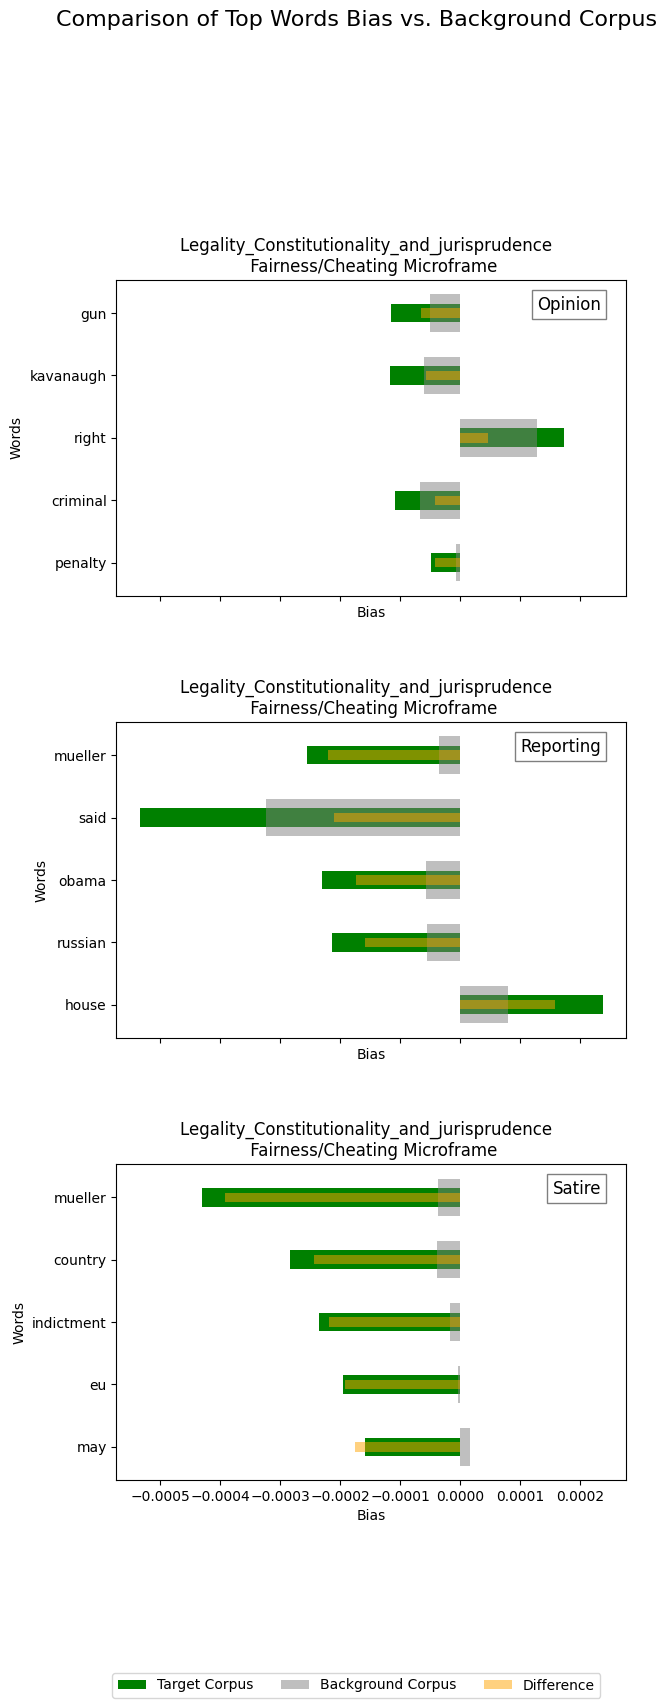

In [261]:
selected_frame_tone = ['Legality_Constitutionality_and_jurisprudence - opinion',
    'Legality_Constitutionality_and_jurisprudence - reporting',
    'Legality_Constitutionality_and_jurisprudence - satire']

selected_frames = ['Legality, Constitutionality, Jurisdiction',]
selected_microframes = ['fairness']

plot_word_bias_comparisons(df_bias, df_background_shift_bias, selected_frame_tone, selected_microframes, group_by_col=group_by_col, top_n=5, types=["reporting", "opinion", "satire"])

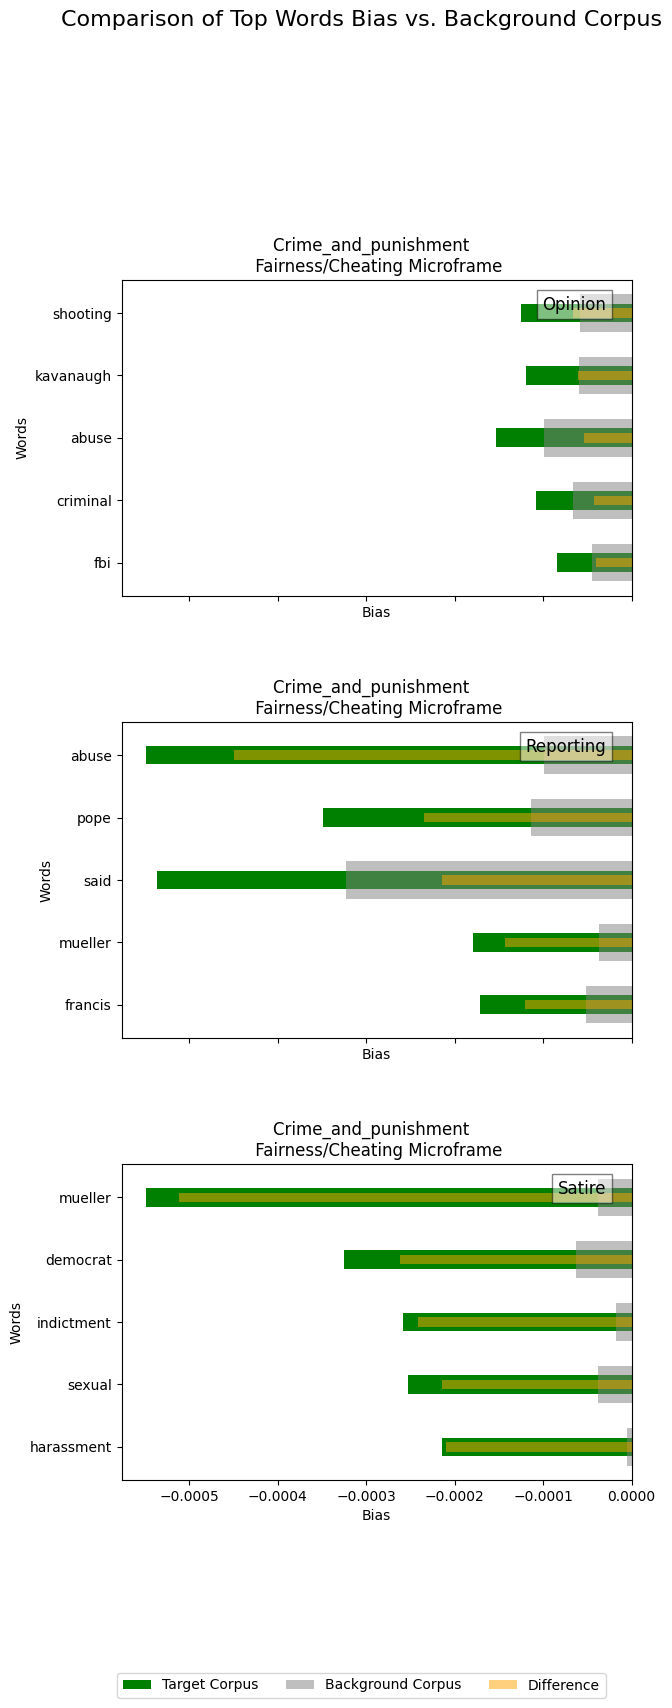

In [262]:
selected_frame_tone = ['Crime_and_punishment - opinion',
    'Crime_and_punishment - reporting',
    'Crime_and_punishment - satire']


selected_frames = ['Legality, Constitutionality, Jurisdiction',]
selected_microframes = ['fairness']

plot_word_bias_comparisons(df_bias, df_background_shift_bias, selected_frame_tone, selected_microframes, group_by_col=group_by_col, top_n=5)

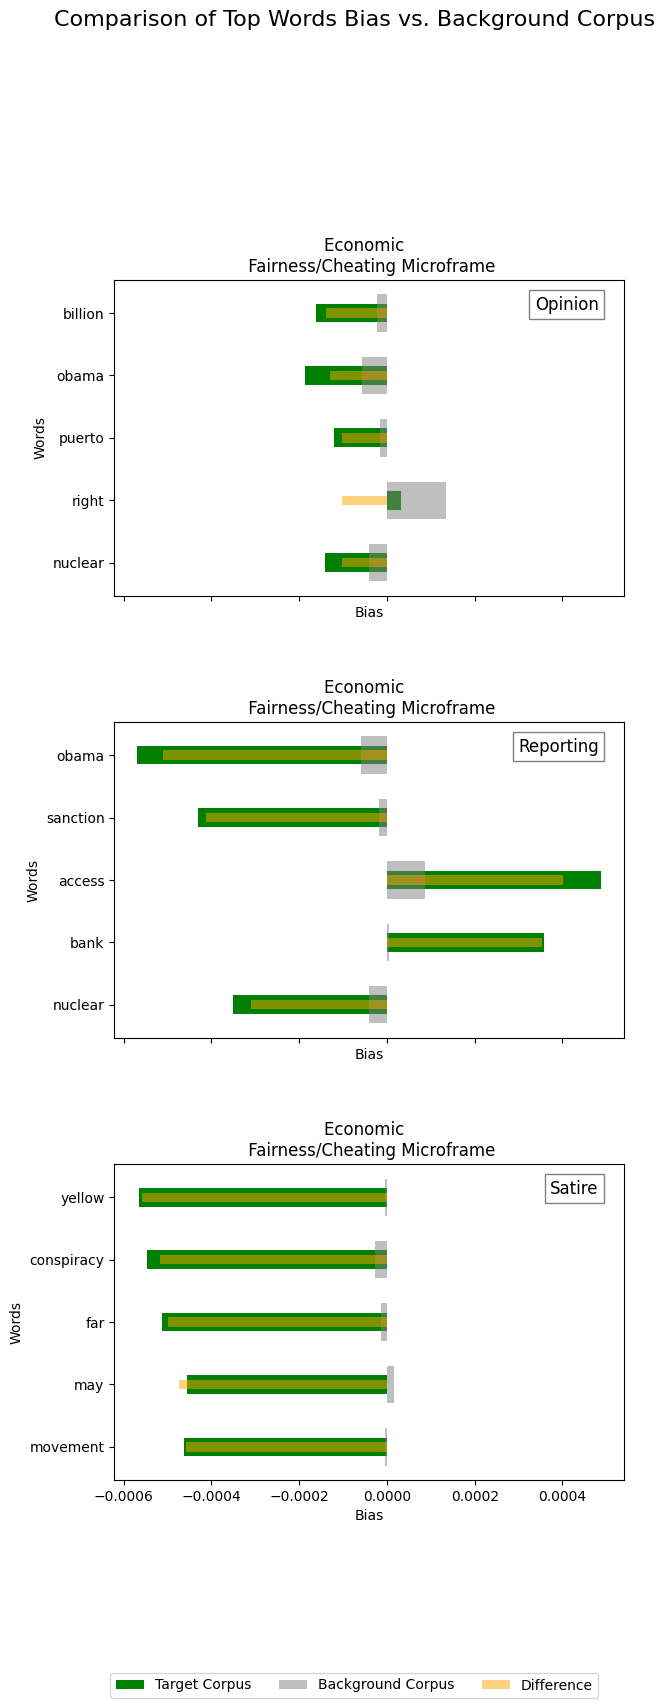

In [263]:
selected_frame_tone = ['Economic - opinion',
 'Economic - reporting', 'Economic - satire']

selected_frames = ['Legality, Constitutionality, Jurisdiction',]
selected_microframes = ['fairness']

plot_word_bias_comparisons(df_bias, df_background_shift_bias, selected_frame_tone, selected_microframes, group_by_col=group_by_col, top_n=5)

In [264]:
def plot_word_intensity_comparisons(
    df_intensity,
    df_background_shift_intensity,
    selected_document_frames,
    selected_microframes,
    group_by_col="frame_type",
    top_n=10,
):
    df_merged = df_intensity.merge(
        df_background_shift_intensity, on=[group_by_col, "word", "microframe"]
    ).rename(columns={"intensity_shift": "intensity_target"})

    # Add intensity_difference
    df_merged["intensity_difference"] = (
        df_merged["intensity_target"] - df_merged["intensity_background"]
    )

    # Plot setup
    num_document_frames = len(selected_document_frames)
    num_microframes = len(selected_microframes)
    fig, axes = plt.subplots(
        num_document_frames,
        num_microframes,
        figsize=(num_microframes * 6, num_document_frames * 5),
        sharex=False,
    )
    fig.subplots_adjust(
        hspace=0.4, wspace=0.3, top=0.9, bottom=0.2, left=0.05, right=0.95
    )

    # Ensure axes are always in a 2D array format
    if num_document_frames == 1 and num_microframes == 1:
        axes = np.array([[axes]])
    elif num_document_frames == 1:
        axes = np.array([axes])
    elif num_microframes == 1:
        axes = axes[:, np.newaxis]

    # Plotting
    for frame_index, doc_frame in enumerate(selected_document_frames):
        for microframe_index, microframe in enumerate(selected_microframes):
            ax = axes[frame_index, microframe_index]

            # Get top_words for the selected document frame and microframe
            top_words = df_merged[
                (df_merged[group_by_col] == doc_frame)
                & (df_merged["microframe"] == microframe)
            ].nlargest(top_n, "intensity_difference")

            # Reverse the order of the top_words
            top_words = top_words.iloc[::-1]

            bar_width = 0.3

            # Plot target corpus intensities
            ax.barh(
                top_words["word"],
                top_words["intensity_target"],
                height=bar_width,
                color="green",
                label="Target Corpus",
            )

            # Plot background intensities for these top words
            ax.barh(
                top_words["word"],
                top_words["intensity_background"],
                height=bar_width * 2,
                color="gray",
                alpha=0.5,
                label="Background Corpus",
            )

            # Plot difference
            ax.barh(
                top_words["word"],
                top_words["intensity_difference"],
                height=bar_width / 2,
                color="orange",
                alpha=0.5,
                label="Difference",
            )

            # Determine tone
            if doc_frame.split(" - ")[1] == "reporting":
                tone = "Reporting"
            elif doc_frame.split(" - ")[1] == "opinion":
                tone = "Opinion"
            elif doc_frame.split(" - ")[1] == "satire":
                tone = "Satire"

            # Add text annotation for tone
            ax.text(
                0.95,
                0.95,
                tone,
                transform=ax.transAxes,
                fontsize=12,
                verticalalignment="top",
                horizontalalignment="right",
                bbox=dict(facecolor="white", alpha=0.5),
            )

            ax.set_title(
                f"{doc_frame.split('-')[0]} \n {microframe_map[microframe]} Microframe"
            )
            ax.set_xlabel("Intensity")
            ax.set_ylabel("Words")

            # Adjust the x-axis range to fit the data better
            max_intensity = max(top_words["intensity_target"].max(), top_words["intensity_background"].max())
            ax.set_xlim(0, max_intensity * 1.1)  # Add some padding

    # Legend handling
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    fig.legend(by_label.values(), by_label.keys(), loc='lower center', ncol=3)
    fig.suptitle(
        "Comparison of Top Words Intensity vs. Background Corpus", fontsize=16, y=0.98
    )
    plt.show()

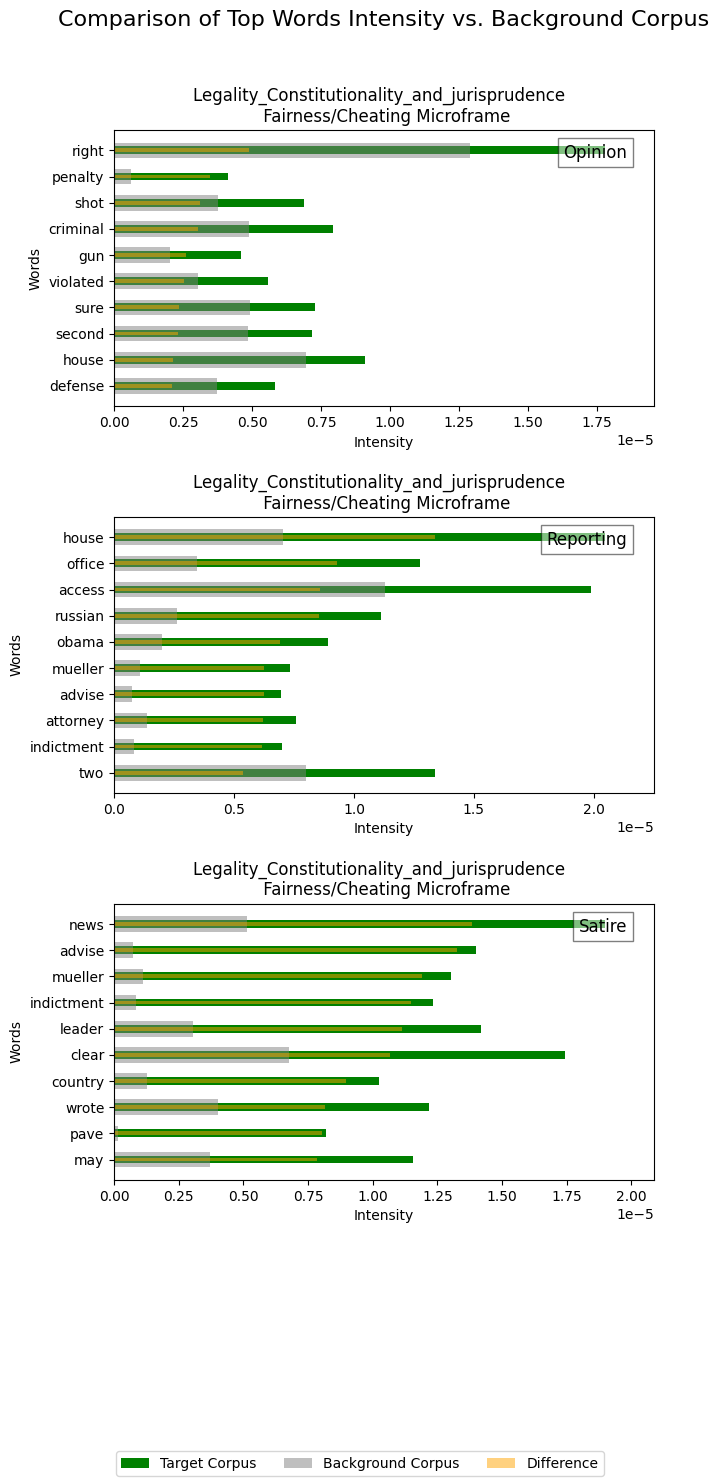

In [265]:
selected_frame_tone = [
       'Legality_Constitutionality_and_jurisprudence - opinion',
       'Legality_Constitutionality_and_jurisprudence - reporting',
       'Legality_Constitutionality_and_jurisprudence - satire',
]

selected_frames = [
    "Quality of Life",
    "Legality, Constitutionality, Jurisdiction",
    "Capacity and Resources",
    "Cultural Identity",
    "Health and Safety",
    "Security and Defense",
    "Economic",
    "Crime and Punishment",
    "External Regulation and Reputation",
    "Political",
    "Fairness and Equality",
    "Policy Presecription and Evaluation",
    "Morality",
    "Public Sentiment",
    "Other",
]
selected_microframes = ["fairness"]

plot_word_intensity_comparisons(
    df_intensities,
    df_background_shift_intensity,
    selected_frame_tone,
    selected_microframes,
    group_by_col=group_by_col,
    top_n=10,
)

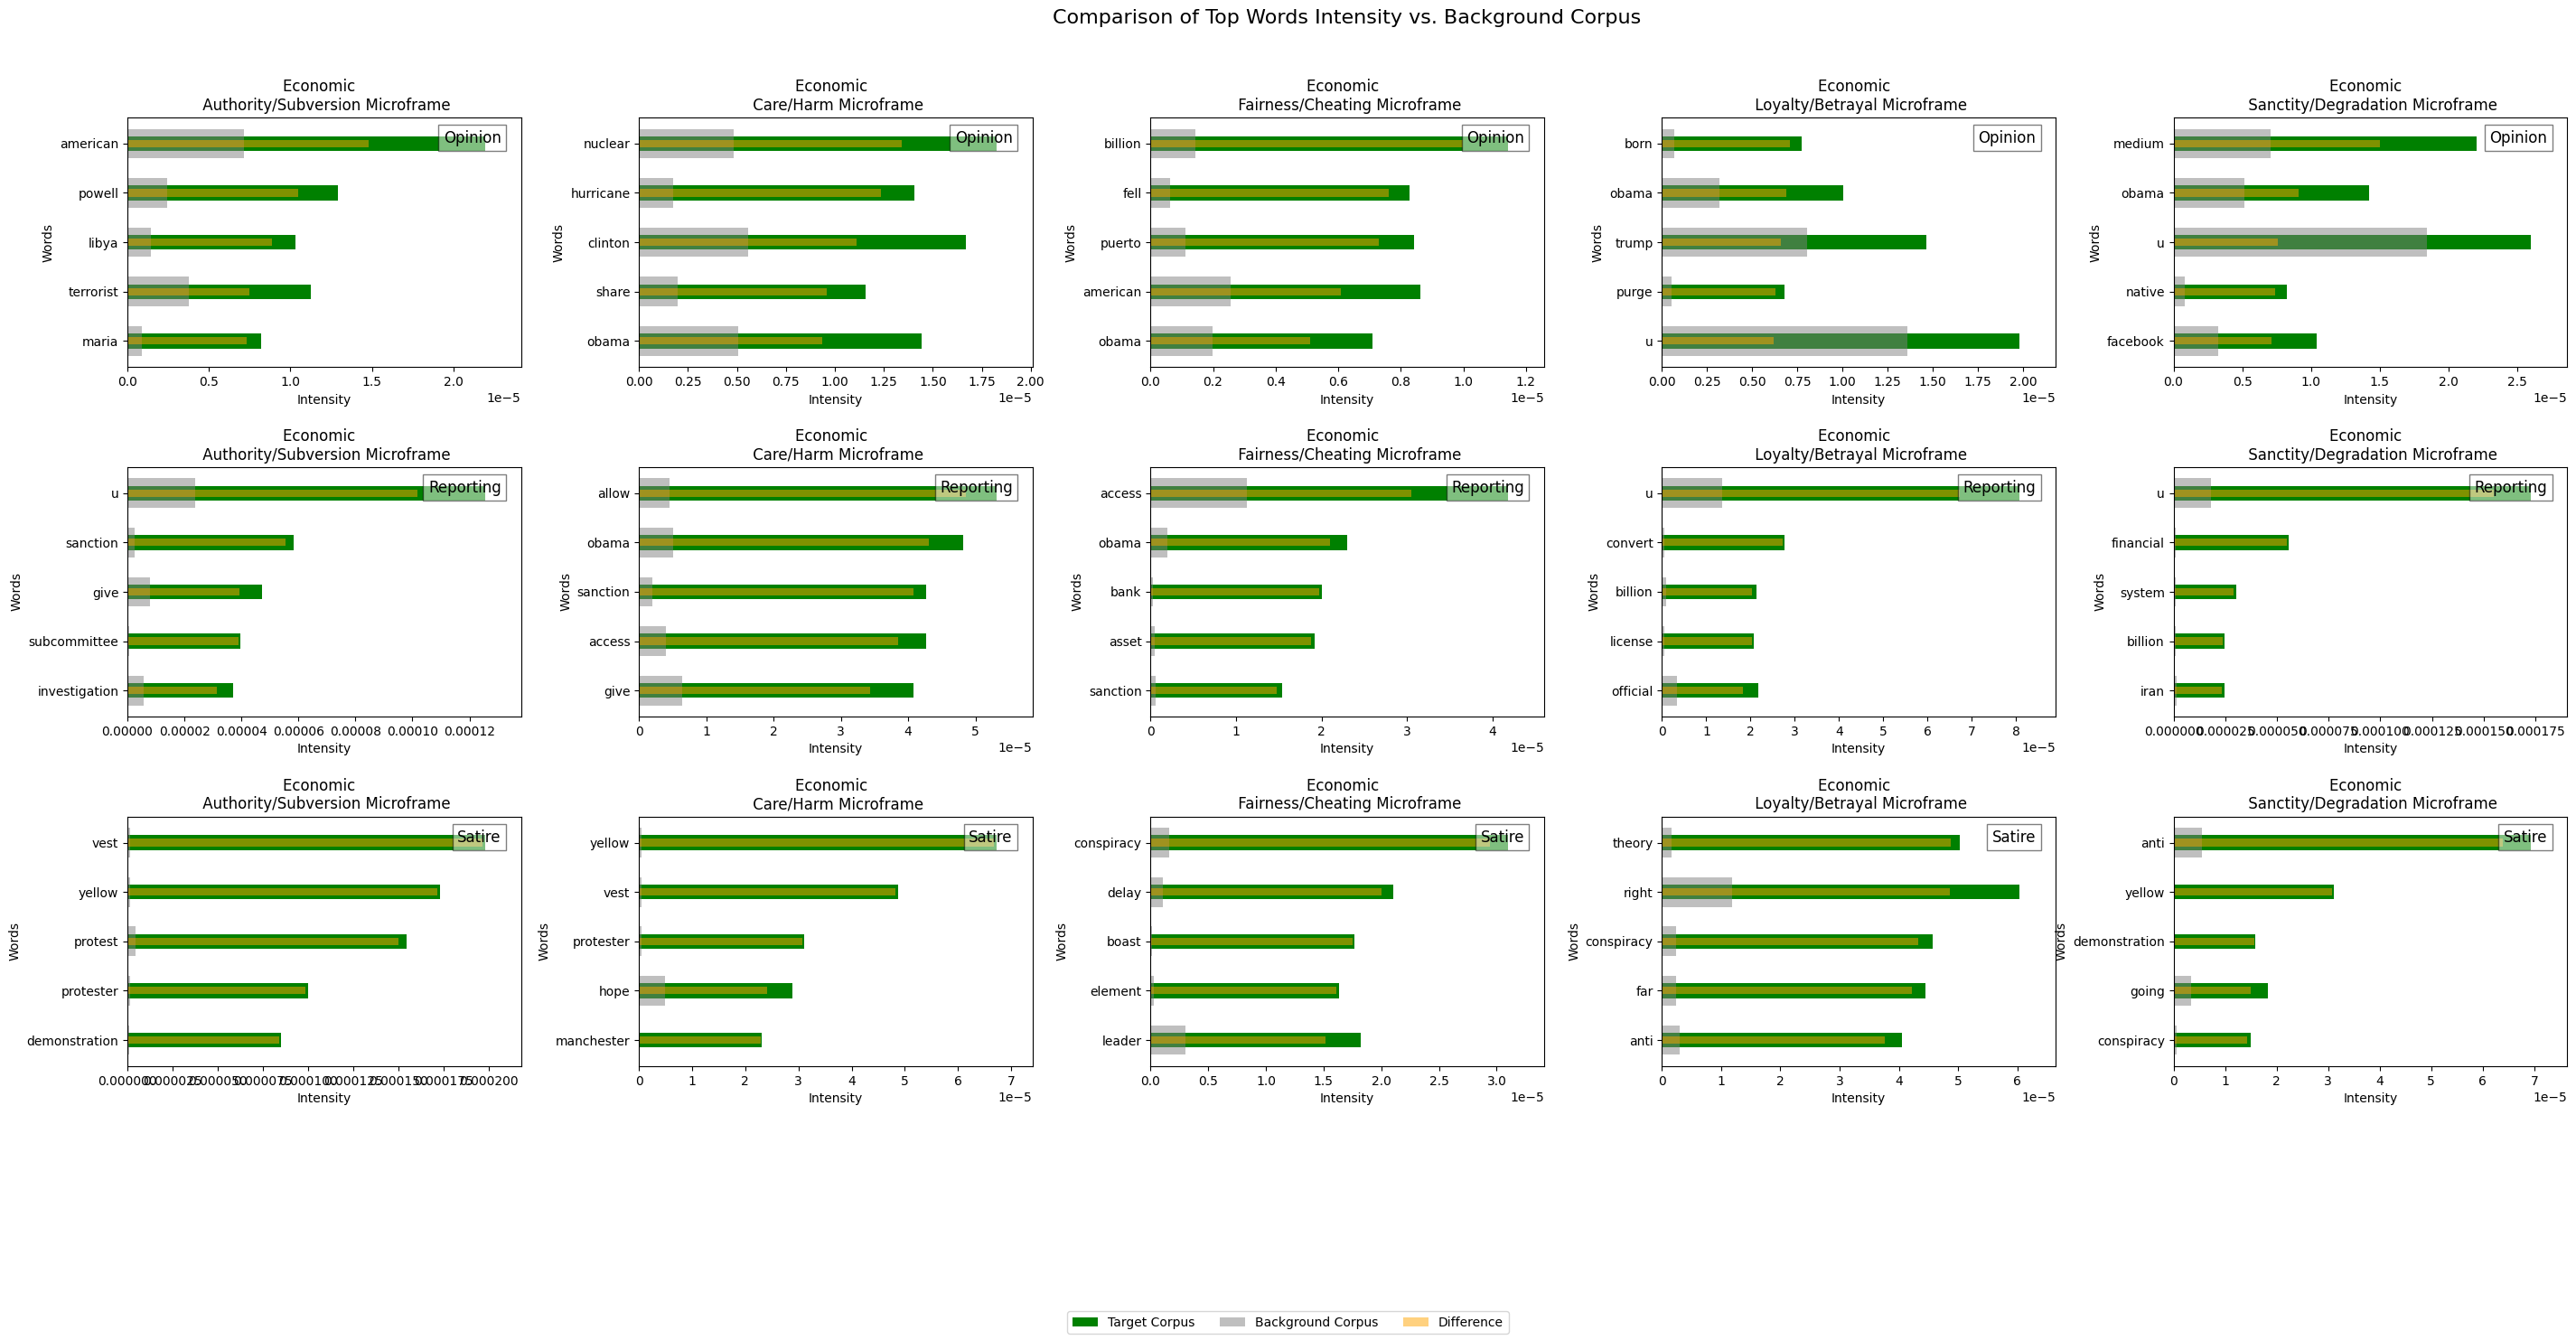

In [266]:
selected_frame_tone = [
       'Economic - opinion', 'Economic - reporting', 'Economic - satire',
]

selected_frames = [
    "Quality of Life",
    "Legality, Constitutionality, Jurisdiction",
    "Capacity and Resources",
    "Cultural Identity",
    "Health and Safety",
    "Security and Defense",
    "Economic",
    "Crime and Punishment",
    "External Regulation and Reputation",
    "Political",
    "Fairness and Equality",
    "Policy Presecription and Evaluation",
    "Morality",
    "Public Sentiment",
    "Other",
]
selected_microframes = ["authority", "care", "fairness", "loyalty", "sanctity"]

plot_word_intensity_comparisons(
    df_intensities,
    df_background_shift_intensity,
    selected_frame_tone,
    selected_microframes,
    group_by_col=group_by_col,
    top_n=5,
)

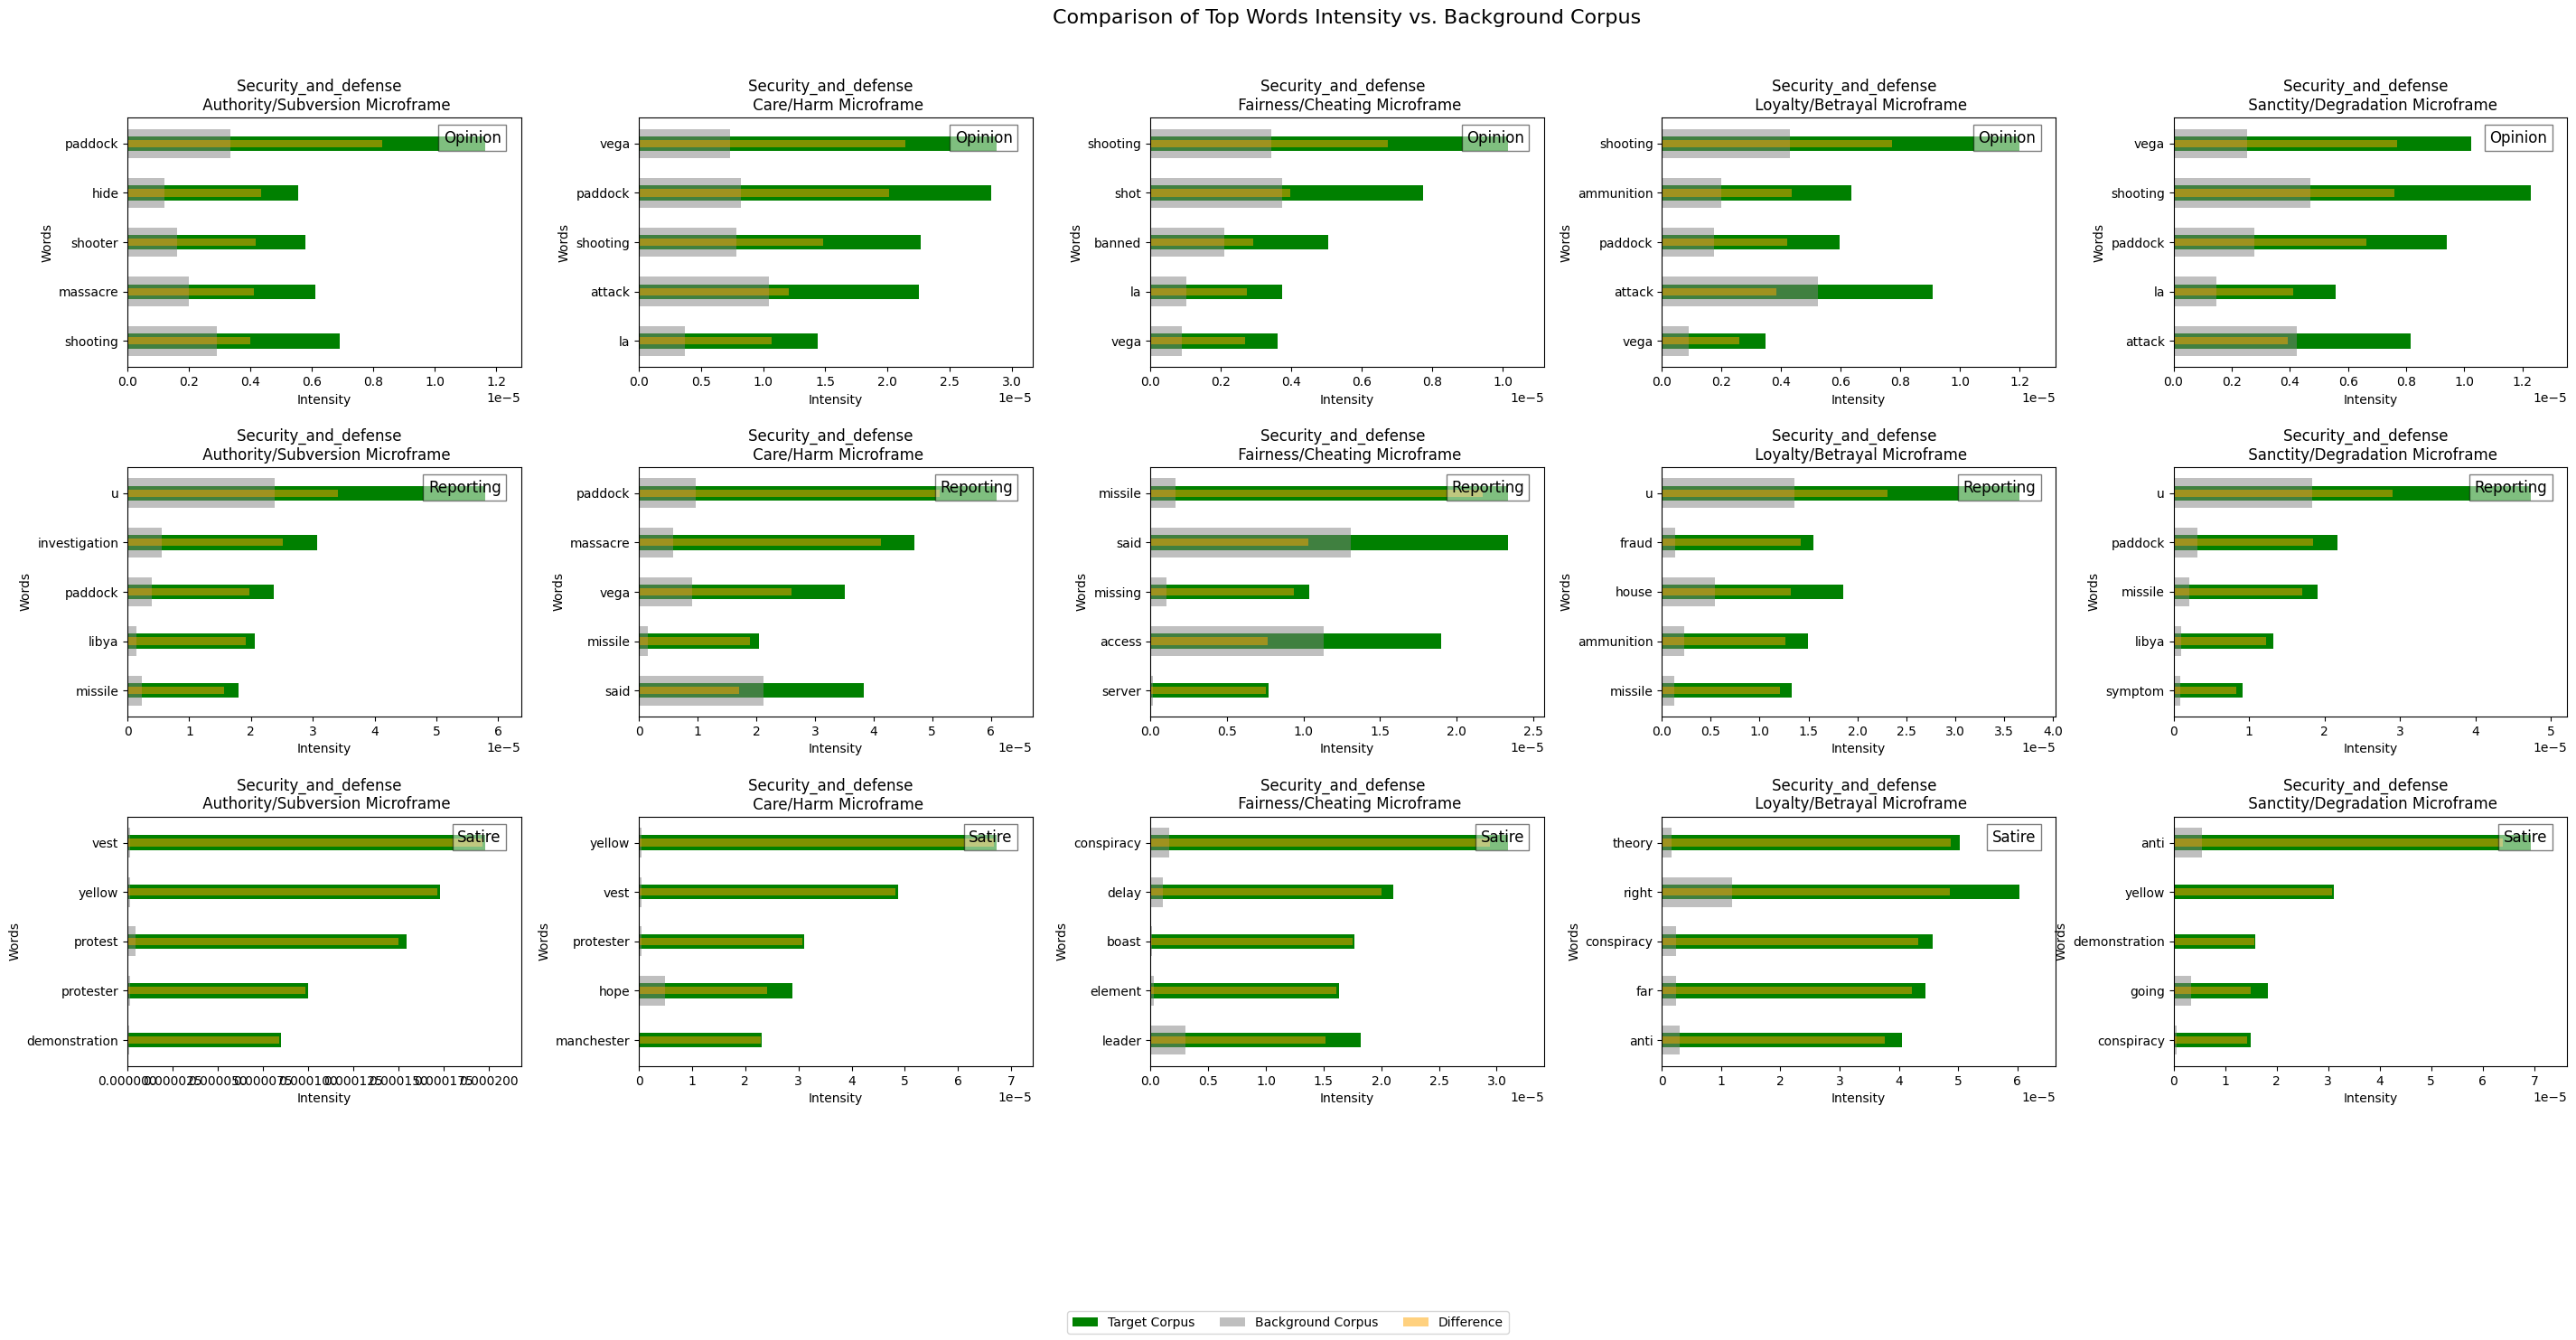

In [267]:
selected_frame_tone = [
       'Security_and_defense - opinion',
       'Security_and_defense - reporting',
       'Security_and_defense - satire'
]

selected_frames = [
    "Quality of Life",
    "Legality, Constitutionality, Jurisdiction",
    "Capacity and Resources",
    "Cultural Identity",
    "Health and Safety",
    "Security and Defense",
    "Economic",
    "Crime and Punishment",
    "External Regulation and Reputation",
    "Political",
    "Fairness and Equality",
    "Policy Presecription and Evaluation",
    "Morality",
    "Public Sentiment",
    "Other",
]
selected_microframes = ["authority", "care", "fairness", "loyalty", "sanctity"]

plot_word_intensity_comparisons(
    df_intensities,
    df_background_shift_intensity,
    selected_frame_tone,
    selected_microframes,
    group_by_col=group_by_col,
    top_n=5,
)

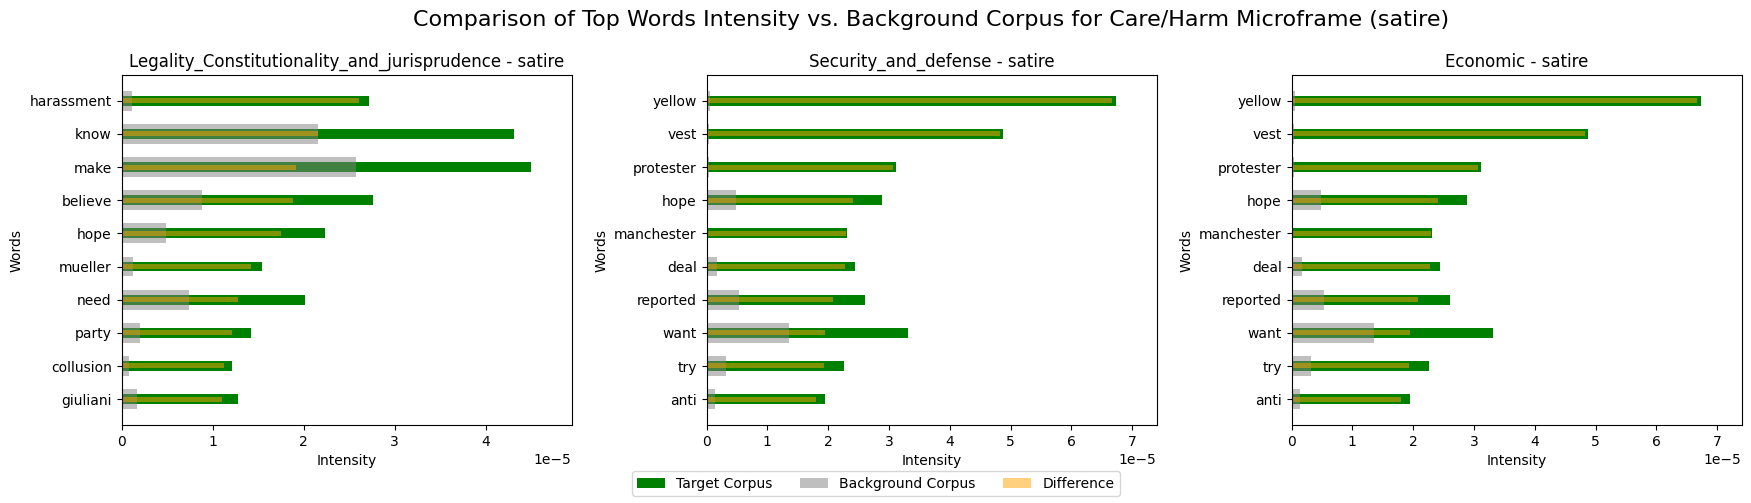

In [271]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def plot_specific_word_intensity_comparisons(
    df_intensity,
    df_background_shift_intensity,
    selected_frames,
    selected_type="opinion",
    microframe="care",
    group_by_col="frame_type",
    top_n=10,
):
    df_merged = df_intensity.merge(
        df_background_shift_intensity, on=[group_by_col, "word", "microframe"]
    ).rename(columns={"intensity_shift": "intensity_target"})

    # add intensity_difference
    df_merged["intensity_difference"] = (
        df_merged["intensity_target"] - df_merged["intensity_background"]
    )

    fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharex=False)
    fig.subplots_adjust(hspace=0.4, wspace=0.3, top=0.85, bottom=0.15, left=0.05, right=0.95)

    for col_index, frame in enumerate(selected_frames):
        ax = axes[col_index]

        # get top_words for the selected document frame and microframe
        top_words = df_merged[
            (df_merged[group_by_col].str.contains(frame))
            & (df_merged[group_by_col].str.contains(selected_type))
            & (df_merged["microframe"] == microframe)
        ].nlargest(top_n, "intensity_difference")

        # reverse the order of the top_words
        top_words = top_words.iloc[::-1]

        bar_width = 0.3

        # Plot target corpus intensities
        ax.barh(
            top_words["word"],
            top_words["intensity_target"],
            height=bar_width,
            color="green",
            label="Target Corpus"
        )

        # Plot background intensities for these top words
        ax.barh(
            top_words["word"],
            top_words["intensity_background"],
            height=bar_width * 2,
            color="gray",
            alpha=0.5,
            label="Background Corpus"
        )

        # Plot difference
        ax.barh(
            top_words["word"],
            top_words["intensity_difference"],
            height=bar_width / 2,
            color="orange",
            alpha=0.5,
            label="Difference"
        )

        ax.set_title(f"{frame} - {selected_type}")
        ax.set_xlabel("Intensity")
        ax.set_ylabel("Words")

        # Adjust the x-axis range to fit the data better
        max_intensity = max(top_words["intensity_target"].max(), top_words["intensity_background"].max())
        ax.set_xlim(0, max_intensity * 1.1)  # Add some padding

    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    fig.legend(by_label.values(), by_label.keys(), loc='lower center', ncol=3)
    fig.suptitle(f"Comparison of Top Words Intensity vs. Background Corpus for Care/Harm Microframe ({selected_type})", fontsize=16, y=0.98)
    plt.show()

selected_frames = [
    "Legality_Constitutionality_and_jurisprudence",
    "Security_and_defense",
    "Economic"
]

plot_specific_word_intensity_comparisons(
    df_intensities,
    df_background_shift_intensity,
    selected_frames,
    selected_type="satire",
    microframe="care",
    group_by_col="frame_type",
    top_n=10,
)
